# Create a dynamics file

In [255]:
%%writefile long_dynamics.py
#!/home/kevin/software/xplor-nih/executables/pyXplor

import os, sys, re, glob, os, shutil, json, argparse
import datetime
import numpy as np

class Capturing(list):
    """Class to capture print statements from function calls.

    Examples:
        >>> # write a function
        >>> def my_func(arg='argument'):
        ...     print(arg)
        ...     return('fin')
        >>> # use capturing context manager
        >>> with Capturing() as output:
        ...     my_func('new_argument')
        >>> print(output)
        ['new_argument', "'fin'"]

    """

    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self

    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio  # free up some memory
        sys.stdout = self._stdout

def output_json(calc_energy_in, file):
    with open(file, 'w') as f:
        f.write(calc_energy_in)

def run_dyn(pdb, psol_restraints, relax_restraints_600, relax_restraints_800, out_dir, temp, nsteps, pdb_write_step):
    start_time = datetime.datetime.now().astimezone().replace(microsecond=0).isoformat()
    print(f"{start_time}: Starting long XPLOR sim with {nsteps} steps. Writing into {out_dir}")
    import protocol
    
    # create psolpot
    radius = 4.0
    protocol.loadPDB(pdb, deleteUnknownAtoms=True)
    from psolPotTools import create_PSolPot
    psol = create_PSolPot("psol", file=psol_restraints)

    # psol options
    psol.setRmin(0.8)
    #psol.setRadMax(30.0)
    #psol.setThkIni(1.0)
    #psol.setThkFac(1.4)
    #psol.setTcType("fix")
    psol.setTauC(0.2)
    #psol.setPconc(4.0)
    psol.setSqn(3.5)
    psol.setRho0(0.24)
    psol.setFreqI(600)
    psol.tessellation().setVerbose(True)
    psol.setThreshold(0)
    psol.setProbeRadius(radius)
    psol.setRadiusOffset(radius)
    psol.setScale(0.002)

    # create relaxpot
    from diffPotTools import readInRelaxData
    from relaxRatioPotTools import create_RelaxRatioPot
    
    relax_data_in = readInRelaxData(relax_restraints_600, pattern=['resid', 'R1', 'R1_err', 'R2', 'R2_err', 'NOE', 'NOE_err'])
    r_ratio_600 = create_RelaxRatioPot('rrp600', data_in=relax_data_in, freq=600, temperature=temp)
    r_ratio_600.setScale(0.002)
    relax_data_in = readInRelaxData(relax_restraints_800, pattern=['resid', 'R1', 'R1_err', 'R2', 'R2_err', 'NOE', 'NOE_err'])
    r_ratio_800 = create_RelaxRatioPot('rrp800', data_in=relax_data_in, freq=800, temperature=temp)
    r_ratio_800.setScale(0.002)
    
    import potList
    plist = potList.PotList('PotList')
    for i in [psol, r_ratio_600, r_ratio_800]:
        plist.append(i)
    from simulationTools import analyze
    out = analyze(plist)
    
    # dynamics in internal coordinates
    from ivm import IVM
    dyn = IVM()
    protocol.torsionTopology(dyn)
    
    loops, remainder = divmod(nsteps, pdb_write_step)
    if remainder != 0:
        raise Exception("Division of nsteps and pdb_write_step gives remainder. Please choose Numbers without remainder.")
    protocol.initDynamics(dyn, bathTemp=temp, printInterval=10, numSteps=int(nsteps/ loops), potList=plist)
    for loop in range(loops):
        out_pdb = f"{out_dir}{start_time}_dyanmics_run_{loop}.pdb"
        dyn.run()
        protocol.writePDB(out_pdb)
    print("finished")


if __name__ == '__main__':    
    parser = argparse.ArgumentParser(description="Run PsolPot using XPLOR-NIH python shell.")
    parser.add_argument('-pdb', metavar='<string>', required=True, type=str, help="The pdb file used to run PSolPot on.")
    parser.add_argument('-psol_restraints', metavar='<string>', required=True, type=str, help="Path to the restraints.tbl file for PSolPot.")
    parser.add_argument('-relax_restraints_600', metavar='<string>', required=True, type=str, help="Path to the restraints.tbl file dor RelaxRatioPot with 600 MHz frequency.")
    parser.add_argument('-relax_restraints_800', metavar='<string>', required=True, type=str, help="Path to the restraints.tbl file dor RelaxRatioPot with 800 MHz frequency.")
    parser.add_argument('-out_dir', metavar='<string>', required=True, type=str, help="Path for the directory for pdb_output.")
    parser.add_argument('-temp', metavar='<float>', required=True, type=float, help="Temperature of the experiment.")
    parser.add_argument('-nsteps', metavar='<int>', required=True, type=int, help="How many steps to run for the simulations.")
    parser.add_argument('-pdb_write_step', metavar='<int>', required=True, type=int, help="Write a pdb every pdb_write_step steps.")
    args = vars(parser.parse_args())
    run_dyn(**args)

Overwriting long_dynamics.py


# New Protocol

In [150]:
%%writefile new_protocol.py
#!/home/kevin/software/xplor-nih/executables/pyXplor

import os, sys, re, glob, os, shutil, json, argparse
import datetime
import numpy as np

rampString = """
for medium in tensors.values():
    calcTensor(medium)
"""

def main(pdb_file, spre_file, relax_600_file, relax_800_file, nstructures):

    import protocol
    protocol.loadPDB(pdb_file, deleteUnknownAtoms=True)
    protocol.initParams('protein')
    protocol.initRandomSeed(42)
    from potList import PotList
    etotal = PotList()

    from simulationTools import MultRamp, StaticRamp, InitialParams

    highTempParams = []
    rampedParams = []

    from varTensorTools import create_VarTensor, calcTensor
    tensors = {}
    #                          medium     Da   Rh
    for (medium, Da, Rh) in [('tmv107',  -6.5, 0.62),
                             ('bicelle', -9.9, 0.23)]:
        tensor = create_VarTensor(medium)
        tensor.setDa(Da)
        tensor.setRh(Rh)
        tensors[medium] = tensor

    highTempParams.append(StaticRamp(rampString))
    
    from diffPotTools import readInRelaxData
    from relaxRatioPotTools import create_RelaxRatioPot

    relax_data_in = readInRelaxData(relax_600_file, pattern=['resid', 'R1', 'R1_err', 'R2', 'R2_err', 'NOE', 'NOE_err'])
    rrp600 = create_RelaxRatioPot('rrp600', data_in=relax_data_in, freq=600, temperature=300)
    # r_ratio_600.setScale(0.002)
    etotal.append(rrp600)
    rampedParams.append(MultRamp(0.01, 1.0, "rrp600.setScale(VALUE)"))

    relax_data_in = readInRelaxData(relax_800_file, pattern=['resid', 'R1', 'R1_err', 'R2', 'R2_err', 'NOE', 'NOE_err'])
    rrp800 = create_RelaxRatioPot('rrp800', data_in=relax_data_in, freq=800, temperature=300)
    # r_ratio_800.setScale(0.002)
    etotal.append(rrp800)
    rampedParams.append(MultRamp(0.01, 1.0, "rrp800.setScale(VALUE)"))

    from psolPotTools import create_PSolPot
    psol = create_PSolPot("psol", file=spre_file)
    # psol.setScale(0.002)

    radius = 4.0
    # psol options
    psol.setRmin(0.8)
    #psol.setRadMax(30.0)
    #psol.setThkIni(1.0)
    #psol.setThkFac(1.4)
    #psol.setTcType("fix")
    psol.setTauC(0.2)
    #psol.setPconc(4.0)
    psol.setSqn(3.5)
    psol.setRho0(0.24)
    psol.setFreqI(600)
    psol.tessellation().setVerbose(True)
    psol.setThreshold(0)
    psol.setProbeRadius(radius)
    psol.setRadiusOffset(radius)

    etotal.append(psol)
    rampedParams.append(MultRamp(0.01, 1.0, "psol.setScale(VALUE)"))

    from xplorPot import XplorPot
    protocol.initHBDB()
    etotal.append(XplorPot('HBDB'))

    import torsionDBPotTools
    torsiondb = torsionDBPotTools.create_TorsionDBPot(name='torsiondb', system='protein')
    etotal.append(torsiondb)

    from repelPotTools import create_RepelPot, initRepel
    repel = create_RepelPot('repel')
    etotal.append(repel)

    highTempParams.append( StaticRamp("""initRepel(repel,
                                                   use14=True,
                                                   scale=0.004,
                                                   repel=1.2,
                                                   moveTol=45,
                                                   interactingAtoms='name CA'
                                                   )""") )

    rampedParams.append(StaticRamp("initRepel(repel, use14=False)"))
    rampedParams.append(MultRamp(0.004, 4, "repel.setScale(VALUE)"))

    import torsionDBPotTools
    repel14 = torsionDBPotTools.create_Terminal14Pot('repel14')
    etotal.append(repel14)
    highTempParams.append(StaticRamp("repel14.setScale(0)"))
    rampedParams.append(MultRamp(0.004, 4, "repel14.setScale(VALUE)"))

    etotal.append(XplorPot('BOND'))

    etotal.append(XplorPot('ANGL'))
    rampedParams.append(MultRamp(0.4, 1.0, "etotal['ANGL'].setScale(VALUE)"))

    etotal.append(XplorPot('DIHE'))
    rampedParams.append(MultRamp(0.4, 1.0, "etotal['DIHE'].setScale(VALUE)"))

    etotal.append(XplorPot('IMPR'))
    rampedParams.append(MultRamp(0.1, 1.0, "etotal['IMPR'].setScale(VALUE)"))

    from simulationTools import analyze
    out = analyze(etotal)

    from ivm import IVM
    dyn = IVM()

    # Alignment tensor setup - fix tensor Rh and Da, vary orientation.
    for tensor in tensors.values():
        tensor.setFreedom("fixDa, fixRh")

    protocol.torsionTopology(dyn)

    # IVM object for final Cartesian minimization.
    #
    minc = IVM()

    # Alingment tensor setup - allow all tensor parameters to float.
    for tensor in tensors.values():
        tensor.setFreedom("varyDa, varyRh")

    protocol.cartesianTopology(minc)

    protocol.massSetup()

    temp_ini = 3000.0   # initial temperature
    temp_fin = 25.0     # final temperature

    
    def calcOneStructure(loopInfo):
        """Calculate a single structure.

        """
        # High Temperature Dynamics Stage.
        # Initialize parameters for high temperature dynamics.
        InitialParams(rampedParams)
        InitialParams(highTempParams)

        # Set up IVM object and run.
        protocol.initDynamics(dyn,
                              potList=etotal,
                              bathTemp=temp_ini,
                              initVelocities=True,
                              finalTime=100,
                              numSteps=1000,
                              printInterval=100)

        dyn.setETolerance(temp_ini/100)# used to set step size (default: temp/1000)
        dyn.run()

        # Simulated Annealing Stage.
        # Set up IVM object for annealing.
        protocol.initDynamics(dyn,
                              finalTime=0.2,
                              numSteps=100,
                              printInterval=100)
        # Set up cooling loop and run.
        from simulationTools import AnnealIVM
        AnnealIVM(initTemp=temp_ini,
                  finalTemp=temp_fin,
                  tempStep=12.5,
                  ivm=dyn,
                  rampedParams=rampedParams).run()

        # Torsion angle minimization.
        protocol.initMinimize(dyn,
                              printInterval=50)
        dyn.run()
        # Cartesian minimization.
        protocol.initMinimize(minc,
                              potList=etotal,
                              dEPred=10)
        minc.run()
        
    from simulationTools import StructureLoop
    StructureLoop(numStructures=nstructures,
                  structLoopAction=calcOneStructure,
                  doWriteStructures=True,
                  # Arguments for generating structure statistics:
                  genViolationStats=True,
                  averageSortPots=[etotal['BOND'], # terms for structure sorting.
                                   etotal['ANGL'],
                                   etotal['IMPR'],
                                   etotal['DIHE']],
                  averageTopFraction=0.1, # top fraction of structs. to report on.
                  averagePotList=etotal, # terms analyzed.
                  averageFitSel='not (name H* or PSEUDO)', # selection to fit...
                  ).run()                               # to average structure...
                                                        # and report precision.
        
if __name__ == '__main__':
    parser = argparse.ArgumentParser(description="Run new protocol with PSolPot, 2xRelaxRatioPot and generate 100 structures.")
    parser.add_argument('-pdb_file', metavar='<string>', required=True, type=str, help="The pdb file to run the sim on.")
    parser.add_argument('-spre_file', metavar='<string>', required=True, type=str, help="Path to the restraints.tbl file for PSolPot.")
    parser.add_argument('-relax_600_file', metavar='<string>', required=True, type=str, help="Path to the restraints.tbl file dor RelaxRatioPot with 600 MHz frequency.")
    parser.add_argument('-relax_800_file', metavar='<string>', required=True, type=str, help="Path to the restraints.tbl file dor RelaxRatioPot with 800 MHz frequency.")
    parser.add_argument('-nstructures', metavar='<int>', required=False, type=int, default=1000, help="Number of structures to calculate")
    args = vars(parser.parse_args())
    main(**args)

Overwriting new_protocol.py


# Imports

In [1]:
import mdtraj as md
import numpy as np
import pandas as pd
import encodermap as em
import loading_lizard as ll
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import nglview as ngl
import xarray as xr
import expansion_elephant as ep
import tensorflow as tf
import running_rabbit as rr

rr.update_gmx_environ('2021.1', cuda=True, AVX512=False)

import glob, os, re, sys, copy, pickle, hdbscan, subprocess, itertools, pathlib, pyemma, shutil, time

sys.path.insert(0, '/home/kevin/git/Backward/')
import backward

%matplotlib notebook
%load_ext autoreload
%autoreload 2

/home/kevin/projects/encoder_map_private/encodermap/loading/features.py:36: UserWarning: Features need Unittests
  warnings.warn("Features need Unittests")


Also disabling gmx quotes
sourcing /home/soft/gromacs/gromacs-2021.1/inst/cuda_shared_20.04/bin/GMXRC.bash ...


In [129]:
import matplotlib.text as mpl_text

class AnyObject:
    def __init__(self, text, color, label):
        self.my_text = text
        self.my_color = color
        self.label = label
        
    def get_label(self):
        return self.label

class AnyObjectHandler:
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        print(orig_handle)
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        width, height = handlebox.width, handlebox.height
        patch = mpl_text.Text(x=0, y=0, text=orig_handle.my_text, color=orig_handle.my_color, verticalalignment=u'baseline', 
                                horizontalalignment=u'left', multialignment=None, 
                                fontproperties=None, rotation=0, linespacing=None, 
                                rotation_mode=None)
        handlebox.add_artist(patch)
        return patch

/home/kevin/.conda/envs/tf2_38/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Try native 2xUBQ with CONECT

In [4]:
pdb_file = '/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_01_01/start.pdb'

# Build new .tble files

In [5]:
basedir = '/home/kevin/projects/tobias_schneider/test_CONECT/'
os.makedirs(basedir, exist_ok=True)

## Functions

In [86]:
def make_15_N_table(in_file, out_file=None, return_df=True, split_prox_dist=False):
    with open(in_file, 'r') as f:
        lines = f.read().splitlines()
    lines = list(filter(lambda x: False if x == '' else True, lines))

    names = lines[0].lstrip('%<').rstrip('>').split('><') + ['is in secondary']
    df = {n: [] for n in names}

    for line in lines[1:]:
        for i, data in enumerate(line.split()):
            if '*' in data and i == 0:
                df['is in secondary'].append(False)
                data = data.lstrip('*')
            elif '*' not in data and i == 0:
                df['is in secondary'].append(True)
            try:
                df[names[i]].append(float(data))
            except ValueError:
                df[names[i]].append(data)
    df['position'] = list(map(lambda x: 'proximal' if x == 'A' else 'distal', df['chain id']))
    df = pd.DataFrame(df)
    
    mhzs = df['freq of spectrometer (MHz)'].unique()
    for mhz in mhzs:
        rho = []
        rho2 = []
        for i, resnum in enumerate(df['residue number']):
            if df['freq of spectrometer (MHz)'][i] != mhz:
                continue
            if not df['is in secondary'][i]:
                continue
            if df['chain id'][i] == 'B' and not split_prox_dist:
                resnum += 76
            R1 = df['R1 rate (1/s)'][i]
            R1_err = df['R1 rate error (1/s)'][i]
            R2 = df['R2 rate (1/s)'][i]
            R2_err = df['R1 rate error (1/s)'][i]
            NOE = df['NOE'][i]
            NOE_err = df['NOE error'][i]
            if not split_prox_dist:
                rho.append([int(resnum), R1, R1_err, R2, R2_err, NOE, NOE_err])
            else:
                if df['chain id'][i] == 'A':
                    rho.append([int(resnum), R1, R1_err, R2, R2_err, NOE, NOE_err])
                else:
                    rho2.append([int(resnum), R1, R1_err, R2, R2_err, NOE, NOE_err])
        if out_file is not None:
            if not '*' in out_file:
                raise Exception("Method will write two files. Please provide a filename with wildcard (*).")
            filename = out_file.replace('*', str(int(mhz)))
            if not split_prox_dist:
                with open(filename, 'w') as f:
                    for r in rho:
                        f.write(' '.join(map(str, r)) + '\n')
                print(filename, 'written')
            else:
                fnames = [filename.replace('.tbl', '_proximal.tbl'), filename.replace('.tbl', '_distal.tbl')]
                for fname, r in zip(fnames, [rho, rho2]):
                    with open(fname, 'w') as f:
                        for _ in r:
                            f.write(' '.join(map(str, _)) + '\n')
                print(fnames, 'written')
        else:
            print(mhz)
            out = []
            for r in rho + rho2:
                out.append(' '.join(map(str, r)) + '\n')
            print(''.join(out))
    if return_df:
        df = df.rename(columns={'residue number': 'resSeq'})
        df['resSeq'] = df['resSeq'].astype(int)
        max_ = df[df['chain id'] == 'A']['resSeq'].max()
        df['resSeq'] = df.apply(lambda row: row.resSeq + max_ if row['chain id'] == 'B' else row.resSeq, axis=1)
        df = df.sort_values(by=['freq of spectrometer (MHz)', 'chain id', 'resSeq'], axis='rows')
        return(df)
            
def label(resSeq, sPRE, err=0.01):
    return f"assign (resid {resSeq:<2} and name HN)	{sPRE:5.3f}	{err:5.3f}"

def getResSeq(lines):
    return list(map(lambda x: int(x.split('\t')[0][3:]), filter(lambda x: False if (x == '' or 'mM' in x or 'primary' in x) else True, lines)))
    
def make_sPRE_table(in_files, out_file=None, return_df=True, split_prox_dist=False):
    files = glob.glob(in_files)
    files = sorted(files, key=lambda x: 1 if ('proximal' in x or 'prox' in x) else 2)
    assert len(files) == 2, print(f"I need a proximal and a distal file. I found {files}")
    proximal, distal = files
    
    file = proximal
    new_lines = []
    with open(file, 'r') as f:
        lines = f.read().splitlines()
    for i, l in enumerate(lines):
        if l == '' or i == 1:
            continue
        if i == 0:
            main_labels = l.split('\t')
            df = {k: [] for k in main_labels}
            continue
        for k, v in zip(main_labels, l.split('\t')):
            df[k].append(v)
    df['resSeq'] = getResSeq(lines)
    df['position'] = np.full(len(df['resSeq']), 'proximal').tolist()

    file = distal
    with open(file, 'r') as f:
        lines = f.read().splitlines()
    for i, l in enumerate(lines):
        if l == '' or i == 0 or i == 1:
            continue
        for k, v in zip(main_labels, l.split('\t')):
            df[k].append(v)
    max_ = max(df['resSeq'])
    resSeq = list(map(lambda x: x + max_, getResSeq(lines)))
    df['resSeq'].extend(resSeq)
    df['position'].extend(np.full(len(resSeq), 'distal').tolist())
    df = pd.DataFrame(df)
    
    df['sPRE'] = pd.to_numeric(df['sPRE'], errors='coerce')
    df['err'] = pd.to_numeric(df['err'], errors='coerce')
    
    if out_file is not None:
        if not split_prox_dist:
            with open(out_file, 'w') as f:
                for i, row in df.iterrows():
                    if any(pd.isna(row)):
                        continue
                    new_line = label(row['resSeq'], row['sPRE'], row['err'])
                    f.write(new_line + '\n')
            print(out_file, 'written')
        else:
            fnames = [out_file.replace('.tbl', '_proximal.tbl'), out_file.replace('.tbl', '_distal.tbl')]
            for i, fname in enumerate(fnames):
                if i == 0:
                    sub_df = df[df['position'] == 'proximal']
                    print(sub_df)
                else:
                    sub_df = df[df['position'] == 'distal']
                with open(fname, 'w') as f:
                    for j, row in sub_df.iterrows():
                        if any(pd.isna(row)):
                            continue
                        if i == 0:
                            new_line = label(row['resSeq'], row['sPRE'], row['err'])
                        else:
                            new_line = label(row['resSeq'] - max_, row['sPRE'], row['err'])
                        f.write(new_line + '\n')
            print(fnames, 'written')
    if return_df:
        return df

In [87]:
K6_relaxation = make_15_N_table('full_observables/spre_and_relaxation_data_k6_k29/relaxation_file_ub2_k6.txt',
                                'full_observables/diUbi_k6_*_mhz_relaxratiopot_in.tbl', split_prox_dist=True)
K29_relaxation = make_15_N_table('full_observables/spre_and_relaxation_data_k6_k29/relaxation_file_ub2_k29.txt',
                                'full_observables/diUbi_k29_*_mhz_relaxratiopot_in.tbl', split_prox_dist=True)
K6_prox_sPRE = make_sPRE_table('full_observables/spre_and_relaxation_data_k6_k29/di_ub2_k6_*_sPRE.txt',
                               'full_observables/diUbi_k6_sPRE_in.tbl', split_prox_dist=True)
K29_prox_sPRE = make_sPRE_table('full_observables/spre_and_relaxation_data_k6_k29/di_ub2_k29_*_sPRE.txt',
                               'full_observables/diUbi_k29_sPRE_in.tbl', split_prox_dist=True)

['full_observables/diUbi_k6_600_mhz_relaxratiopot_in_proximal.tbl', 'full_observables/diUbi_k6_600_mhz_relaxratiopot_in_distal.tbl'] written
['full_observables/diUbi_k6_800_mhz_relaxratiopot_in_proximal.tbl', 'full_observables/diUbi_k6_800_mhz_relaxratiopot_in_distal.tbl'] written
['full_observables/diUbi_k29_600_mhz_relaxratiopot_in_proximal.tbl', 'full_observables/diUbi_k29_600_mhz_relaxratiopot_in_distal.tbl'] written
['full_observables/diUbi_k29_800_mhz_relaxratiopot_in_proximal.tbl', 'full_observables/diUbi_k29_800_mhz_relaxratiopot_in_distal.tbl'] written
   primary sequence       sPRE       err  resSeq  position
0              Met1        NaN       NaN       1  proximal
1              Gln2   4.024789  0.337223       2  proximal
2              Ile3   1.348830  0.413077       3  proximal
3              Phe4   5.180514  1.036943       4  proximal
4              Val5   4.749073  0.531051       5  proximal
..              ...        ...       ...     ...       ...
71            Arg72

## Execute

In [269]:
RelaxRatioDF = make_15_N_table('relaxation_file_ub2_k6.txt', 'test_CONECT/diUbi_*_mhz_relaxratiopot_in.tbl')
PSolDF = make_sPRE_table('solventPRE_NMR_data/sPRE values K6 dimer *.txt', 'test_CONECT/diUbi_spre.tbl')

test_CONECT/diUbi_600_mhz_relaxratiopot_in.tbl written
test_CONECT/diUbi_800_mhz_relaxratiopot_in.tbl written
test_CONECT/diUbi_spre.tbl written


In [270]:
RelaxRatioDF

resSeq chain id P atom name Q atom name  freq of spectrometer (MHz)  \
0         2        A           N           H                       600.0   
1         3        A           N           H                       600.0   
2         4        A           N           H                       600.0   
3         5        A           N           H                       600.0   
4         7        A           N           H                       600.0   
..      ...      ...         ...         ...                         ...   
261     145        B           N           H                       800.0   
262     146        B           N           H                       800.0   
263     147        B           N           H                       800.0   
264     149        B           N           H                       800.0   
265     150        B           N           H                       800.0   

     R1 rate (1/s)  R1 rate error (1/s)  R2 rate (1/s)  R2 rate error (1/s)  \
0         1.401544             0.009619      12.445858             0.285990   
1         1.439783             0.016894      11.625145             0.153587   
2         1.442767             0.014602      12.005927             0.442207   
3         1.345446             0.011759      11.814099             0.120512   
4         1.428426             0.037188      13.099580             0.192292   
..             ...                  ...            ...                  ...   
261       1.078143             0.016990      12.444537             0.175415   
262       1.087696             0.031569      21.159346             0.650404   
263       1.077387             0.018700      12.211506             0.141480   
264       1.273400             0.035399      10.946205             0.113877   
265       1.260608             0.031060       8.817056             0.203678   

          NOE  NOE error  is in secondary  position  
0    0.779673   0.025396             True  proximal  
1    0.790700   0.032749             True  proximal  
2    0.759039   0.033966             True  proximal  
3    0.742896   0.028782             True  proximal  
4    0.763703   0.030515            False  proximal  
..        ...        ...              ...       ...  
261  0.834219   0.035358             True    distal  
262  0.876313   0.059350             True    distal  
263  0.784492   0.033874             True    distal  
264  0.646309   0.033071            False    distal  
265  0.599548   0.037800            False    distal  

[266 rows x 13 columns]

In [264]:
PSolDF

primary sequence       sPRE       err  resSeq  position
0               Met1        NaN       NaN       1  proximal
1               Gln2   4.024789  0.337223       2  proximal
2               Ile3   1.348830  0.413077       3  proximal
3               Phe4   5.180514  1.036943       4  proximal
4               Val5   4.749073  0.531051       5  proximal
..               ...        ...       ...     ...       ...
144            Val70   2.110228  1.761708     146    distal
145            Leu71   8.269641  1.182955     147    distal
146            Arg72        NaN       NaN     148    distal
147            Leu73  24.817400  0.956704     149    distal
148            Arg74  22.651498  2.220798     150    distal

[149 rows x 5 columns]

In [271]:
# PSolDF.to_csv("PSol_dataframe.csv", index=False)
# RelaxRatioDF.to_csv("RelaxRatio_dataframe.csv", index=False)

# Load 2xUBQ

## Rename LYQ and GLQ and check CONECT

```
CONECT  760  762       760  C   GLQ A  76
CONECT  762  760       762  N   MET A   1
CONECT  828  830       828  C   LYQ A   6
CONECT  830  828       830  N   THR A   7
```

In [197]:
pdb_file = '/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_01_01/start.pdb'
traj = md.load(pdb_file)

# renumber
for r in traj.top.residues:
    if r.index > 75:
        r.resSeq += 76
    if r.name == 'GLQ':
        r.name = 'GLY'
    if r.name == 'LYQ':
        r.name = 'LYS'
        
def put_CONECT_back_in(isopeptide_indices, file):
    """Puts CONECT back into pdb.
    
    Args:
        isopeptide_indices (list): List of integers. Where the isopeptide bond should be
            These integers are 1-based atom seqence identifiers.
            
    """ 
    with open(file, 'r') as f:
        lines = f.read().splitlines()
        
    new_lines = []
    for line in lines:
        if 'ENDMDL' in line:
            line = f"ENDMDL\nCONECT {isopeptide_indices[0]:>4} {isopeptide_indices[1]:>4}\nCONECT {isopeptide_indices[1]:>4} {isopeptide_indices[0]:>4}"
        new_lines.append(line)
    with open(file, 'w') as f:
        f.write('\n'.join(new_lines))
    
traj.save_pdb('test_CONECT/2017_04_27_G_2ub_k6_01_01.pdb')
put_CONECT_back_in([760, 762], 'test_CONECT/2017_04_27_G_2ub_k6_01_01.pdb')

ENDMDL
CONECT  760  762
CONECT  762  760


## Try the new file in XPLOR-NIH

Tried in `15N_relaxation.ipynb`.

In [199]:
traj1 = md.load('test_CONECT/100_steps.pdb')
traj2 = md.load('test_CONECT/200_steps_maybe.pdb')

In [201]:
print(traj1.xyz[0,:5,:5])

[[6.1223 5.4194 0.2415]
 [6.1735 5.4128 0.1563]
 [6.0545 5.3462 0.2469]
 [6.0334 5.5339 0.2658]
 [5.9131 5.4818 0.3439]]


In [202]:
print(traj2.xyz[0,:5,:5])

[[6.1195 5.4183 0.251 ]
 [6.1519 5.3884 0.1616]
 [6.0627 5.3474 0.2926]
 [6.026  5.5311 0.262 ]
 [5.9094 5.4847 0.3487]]


# Create a script from that.

Done at the very top

# Analyze and visualize the dynamics

In [16]:
files = glob.glob("test_CONECT/2021-05-04T15:18:55+02:00_dyanmics_run_*.pdb")

In [17]:
for i, file in enumerate(files):
    if i == 0:
        traj_out = md.load(file)
    else:
        _ = md.load(file)
        traj_out = traj_out.join(_)

In [18]:
view = ngl.show_mdtraj(traj_out)
view.clear_representations()
view.add_representation('ball+stick')

In [19]:
view

NGLWidget(max_frame=999)

# Run a XPLOR test to visualize the dynamics

run `psolPotTest.py`, because it uses Ubiquitin

In [20]:
files = glob.glob("long_test_sim/test_*.pdb")
for i, file in enumerate(files):
    if i == 0:
        traj_out = md.load(file)
    else:
        _ = md.load(file)
        traj_out = traj_out.join(_)
view = ngl.show_mdtraj(traj_out)
view.clear_representations()
view.add_representation('ball+stick')
view

NGLWidget(max_frame=19)

# Ideas How to Fix

- [x] Try bathTemp = 1000. Doesn't Fix the dynamics
- [x] Even smaller scale. Doesn't fix the dynamics
- [x] Divide Distal and Proximal Runs. Can be used. But still. Dynamics are crap.

## Single Ub to file

In [8]:
pdb = md.load_pdb('https://files.rcsb.org/view/1UBQ.pdb')
pdb = pdb.atom_slice(pdb.top.select('protein'))
print(pdb)

<mdtraj.Trajectory with 1 frames, 602 atoms, 76 residues, and unitcells>


In [ ]:
pdb.save_pdb('long_xplor_sim/1UBQ_nosolv.pdb')

In [12]:
pdb_file = '/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_01_01/start.pdb'
traj = md.load(pdb_file)

# renumber
for r in traj.top.residues:
    if r.index > 75:
        r.resSeq += 76
    if r.name == 'GLQ':
        r.name = 'GLY'
    if r.name == 'LYQ':
        r.name = 'LYS'
        
print(traj)
traj = traj.atom_slice(traj.top.select('residue <= 76'))
traj.save_pdb('long_xplor_sim/2017_04_27_G_2ub_k6_01_01_proximal.pdb')

<mdtraj.Trajectory with 1 frames, 1521 atoms, 152 residues, and unitcells>


## Distal and Proximal each

In [7]:
PSolDF = pd.read_csv("PSol_dataframe.csv")
RelaxRatioDF = pd.read_csv("RelaxRatio_dataframe.csv")

In [294]:
f1 = open("long_xplor_sim/proximal/sPRE.tbl", 'w')
f2 = open("long_xplor_sim/distal/sPRE.tbl", 'w')

def label(resSeq, sPRE, err=0.01):
    return f"assign (resid {resSeq:<2} and name HN)	{sPRE:5.3f}	{err:5.3f}\n"

try:
    for i, row in PSolDF.iterrows():
        if any(pd.isna(row)):
            continue
        if row['position'] == 'proximal':
            f1.write(label(row['resSeq'], row['sPRE'], row['err']))
        else:
            f2.write(label(resSeq - 76, row['sPRE'], row['err']))
    
finally:
    f1.close()
    f2.close()
    
f1_600 = open("long_xplor_sim/proximal/N15_600.tbl", 'w')
f1_800 = open("long_xplor_sim/proximal/N15_800.tbl", 'w')
f2_600 = open("long_xplor_sim/distal/N15_600.tbl", 'w')
f2_800 = open("long_xplor_sim/distal/N15_800.tbl", 'w')

def label(resSeq, R1, R1_err, R2, R2_err, NOE, Noe_err, err=0.01):
    return f"{int(resSeq)} {R1:.6g} {R1_err:.6g} {R2:.6g} {R2_err:.6g} {NOE:.6g} {NOE_err:.6g}\n"


try:
    for i, row in RelaxRatioDF.iterrows():
        if any(pd.isna(row)):
            continue
        resSeq = row['resSeq']
        R1 = row['R1 rate (1/s)']
        R1_err = row['R1 rate error (1/s)']
        R2 = row['R2 rate (1/s)']
        R2_err = row['R1 rate error (1/s)']
        NOE = row['NOE']
        NOE_err = row['NOE error']
        freq = row['freq of spectrometer (MHz)']
        if row['position'] == 'proximal' and freq == 600:
            f1_600.write(label(resSeq, R1, R1_err, R2, R2_err, NOE, NOE_err))
        elif row['position'] == 'proximal' and freq == 800:
            f1_800.write(label(resSeq, R1, R1_err, R2, R2_err, NOE, NOE_err))
        elif row['position'] == 'distal' and freq == 600:
            f2_600.write(label(resSeq - 76, R1, R1_err, R2, R2_err, NOE, NOE_err)) 
        elif row['position'] == 'distal' and freq == 800:
            f2_800.write(label(resSeq - 76, R1, R1_err, R2, R2_err, NOE, NOE_err))
        else:
            raise Exception(f"Unkown combination of position and freq: {row}")
    
finally:
    f1_600.close()
    f1_800.close()
    f2_600.close()
    f2_800.close()

## Load the proximal sim

In [ ]:
files = glob.glob("long_xplor_sim/proximal/2021-05-05T14:42:40+02:00_dynamics_run_*.pdb")
print(len(files))
for i, file in enumerate(files):
    if i == 0:
        traj_out = md.load(file)
    else:
        _ = md.load(file)
        traj_out = traj_out.join(_)
view = ngl.show_mdtraj(traj_out)
view.clear_representations()
view.add_representation('ball+stick')
view.center()
view

# More XPLOR research?

https://nmr.cit.nih.gov/xplor-nih/doc/current/

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5734396/

https://spin.niddk.nih.gov/clore/Software/Xplor_NIH_example.html

https://nmr.cit.nih.gov/xplor-nih/doc/current/


In [32]:
%%bash

ls *.py

1UBQ_chimera_CG_and_AA.py
backward.py
custom_gromacstopfile.py
long_dynamics.py
run_psolpot.py
run_psolpot_and_r_ratio_dyn.py


## Build complete .tbl files

In [79]:
K6_relaxation = make_15_N_table('full_observables/spre_and_relaxation_data_k6_k29/relaxation_file_ub2_k6.txt',
                                'full_observables/diUbi_k6_*_mhz_relaxratiopot_in.tbl', split_prox_dist=True)
K29_relaxation = make_15_N_table('full_observables/spre_and_relaxation_data_k6_k29/relaxation_file_ub2_k29.txt',
                                'full_observables/diUbi_k29_*_mhz_relaxratiopot_in.tbl', split_prox_dist=True)
K6_prox_sPRE = make_sPRE_table('full_observables/spre_and_relaxation_data_k6_k29/di_ub2_k6_*_sPRE.txt',
                               'full_observables/diUbi_k6_sPRE_in.tbl', split_prox_dist=True)
K29_prox_sPRE = make_sPRE_table('full_observables/spre_and_relaxation_data_k6_k29/di_ub2_k29_*_sPRE.txt',
                               'full_observables/diUbi_k29_sPRE_in.tbl', split_prox_dist=True)

['full_observables/diUbi_k6_600_mhz_relaxratiopot_in_proximal.tbl', 'full_observables/diUbi_k6_600_mhz_relaxratiopot_in_distal.tbl'] written
['full_observables/diUbi_k6_800_mhz_relaxratiopot_in_proximal.tbl', 'full_observables/diUbi_k6_800_mhz_relaxratiopot_in_distal.tbl'] written
['full_observables/diUbi_k29_600_mhz_relaxratiopot_in_proximal.tbl', 'full_observables/diUbi_k29_600_mhz_relaxratiopot_in_distal.tbl'] written
['full_observables/diUbi_k29_800_mhz_relaxratiopot_in_proximal.tbl', 'full_observables/diUbi_k29_800_mhz_relaxratiopot_in_distal.tbl'] written
['full_observables/diUbi_k6_sPRE_in_proximal.tbl', 'full_observables/diUbi_k6_sPRE_in_distal.tbl'] written
['full_observables/diUbi_k29_sPRE_in_proximal.tbl', 'full_observables/diUbi_k29_sPRE_in_distal.tbl'] written


In [75]:
K6_relaxation

resSeq chain id P atom name Q atom name  freq of spectrometer (MHz)  \
0         2        A           N           H                       600.0   
1         3        A           N           H                       600.0   
2         4        A           N           H                       600.0   
3         5        A           N           H                       600.0   
4         7        A           N           H                       600.0   
..      ...      ...         ...         ...                         ...   
261     145        B           N           H                       800.0   
262     146        B           N           H                       800.0   
263     147        B           N           H                       800.0   
264     149        B           N           H                       800.0   
265     150        B           N           H                       800.0   

     R1 rate (1/s)  R1 rate error (1/s)  R2 rate (1/s)  R2 rate error (1/s)  \
0         1.401544             0.009619      12.445858             0.285990   
1         1.439783             0.016894      11.625145             0.153587   
2         1.442767             0.014602      12.005927             0.442207   
3         1.345446             0.011759      11.814099             0.120512   
4         1.428426             0.037188      13.099580             0.192292   
..             ...                  ...            ...                  ...   
261       1.078143             0.016990      12.444537             0.175415   
262       1.087696             0.031569      21.159346             0.650404   
263       1.077387             0.018700      12.211506             0.141480   
264       1.273400             0.035399      10.946205             0.113877   
265       1.260608             0.031060       8.817056             0.203678   

          NOE  NOE error  is in secondary  position  
0    0.779673   0.025396             True  proximal  
1    0.790700   0.032749             True  proximal  
2    0.759039   0.033966             True  proximal  
3    0.742896   0.028782             True  proximal  
4    0.763703   0.030515            False  proximal  
..        ...        ...              ...       ...  
261  0.834219   0.035358             True    distal  
262  0.876313   0.059350             True    distal  
263  0.784492   0.033874             True    distal  
264  0.646309   0.033071            False    distal  
265  0.599548   0.037800            False    distal  

[266 rows x 13 columns]

## Check RMSD

In [124]:
def get_energies_and_rmsd(file):
    with open(file, 'r') as f:
        lines = f.read().splitlines()
    read = False
    for line in lines:
        if 'Filename:' in line:
            df = pd.DataFrame({k: [] for k in line.replace(':', '').split()})
            read = True
            continue
        if 'average:' in line:
            read = False
        if not read or line == '':
            continue
        df = df.append({k: v for k, v in zip(list(df.keys()), line.split())}, ignore_index=True)
    return df
        

energies_and_rmsd = get_energies_and_rmsd('mol_biol_example/k6_proximal_structures/-f_##.pdb.stats')
energies_and_rmsd

Filename  energy    RMSD
0  -f_75.pdb  182.11  10.728
1  -f_14.pdb  200.51   9.574
2  -f_12.pdb  207.45  10.226
3  -f_43.pdb  207.46  11.867
4  -f_94.pdb  212.53   9.402
5  -f_65.pdb  216.95   9.731
6  -f_79.pdb  256.55  10.634
7  -f_37.pdb  263.41  11.763
8  -f_90.pdb  277.44  13.836
9  -f_95.pdb  670.60  12.003

In [131]:
start_struct = md.load('mol_biol_example/2017_04_27_G_2ub_k6_01_01_proximal.pdb')
start_struct = start_struct.atom_slice(start_struct.top.select('not (residue 1 and name H3)'))
end_struct = md.load('mol_biol_example/k6_proximal_structures/-f_75.pdb')
end_struct = end_struct.atom_slice(end_struct.top.select('protein'))

rmsd = md.rmsd(end_struct, start_struct)
print(rmsd)

[1.7934792]


## Load structures

In [105]:
cat mol_biol_example/k6_proximal_structures/-f_75.pdb

REMARK ------------------------------------------------------------
REMARK summary    Name       Energy      RMS     Violations
REMARK summary total         9013.58             207.0
REMARK summary rrp600        1073.70   32.767      0.0
REMARK summary rrp800        2539.82   50.397     12.0
REMARK summary psol          3701.92    7.790     61.0
REMARK summary HBDB             0.00                  
REMARK summary torsiondb     1507.06               2.0
REMARK summary repel            8.71               0.0
REMARK summary repel14          0.26               0.0
REMARK summary BOND            15.46    0.004      0.0
REMARK summary ANGL           146.91    0.931     58.0
REMARK summary IMPR            19.75    0.618      6.0
REMARK summary DIHE             0.00   20.182     68.0
REMARK ------------------------------------------------------------
REMARK  Relaxation Rates Ratio Potential(s)
REMARK RelaxRatioPot 
REMARK RelaxRatioPot  Temperature for diffusion tensor calculations, [K]
REMAR

In [103]:
image = ep.plotting.render_vmd('mol_biol_example/k6_proximal_structures/-f_12.pdb', scale=2)

For the ssupdate function to work expansion_elephant/vmd/sscache.tcl will be sourced within vmd. If no Error is thrown the file is present.


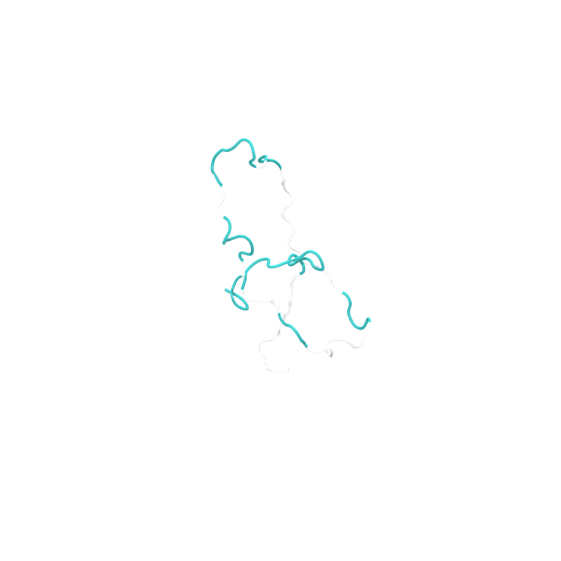

In [104]:
%matplotlib inline
plt.close('all')
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xticks([])
ax.set_yticks([])
[k.set_linewidth(0) for k in ax.spines.values()]
ax.imshow(image)

In [111]:
_ = md.load('mol_biol_example/k6_proximal_structures/-f_75.pdb')
_ = _.atom_slice(_.top.select('protein'))
_.save_pdb('tmp.pdb')
image = ep.plotting.render_vmd('tmp.pdb')

For the ssupdate function to work expansion_elephant/vmd/sscache.tcl will be sourced within vmd. If no Error is thrown the file is present.


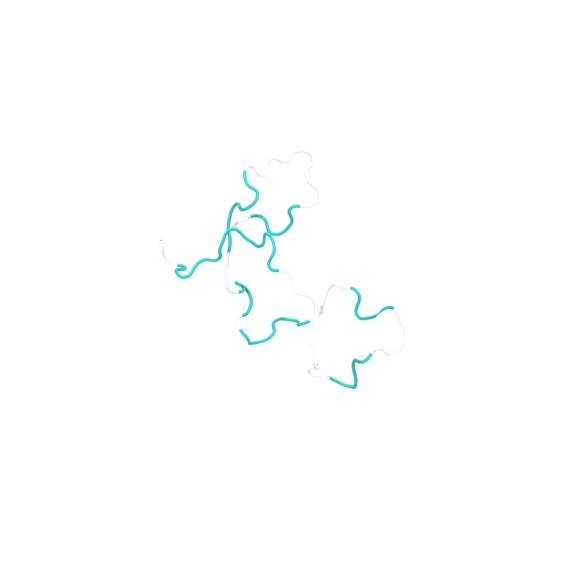

In [112]:
%matplotlib inline
plt.close('all')
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xticks([])
ax.set_yticks([])
[k.set_linewidth(0) for k in ax.spines.values()]
ax.imshow(image)

## Load final analysis

In [100]:
cat mol_biol_example/k6_proximal_structures/-f_\#\#.pdb.stats


  Results for the top 10 (of 100) structures

 Average values for potential terms:

type          name           Energy(dev)      RMSD(dev)      viols(dev)     Num
PotList       TOTAL      9278.01(233.36)   16.603( 0.348)    243.1( 26.9)  2718
PotList       torsiondb  1540.89( 30.49)                       3.3(  2.1)   194
PSol          psol       3760.60( 36.33)    7.852( 0.038)     61.0(  0.0)    61
RelaxRatioPot rrp600     1274.35(413.51)   35.268( 5.820)      0.0(  0.0)    41
RelaxRatioPot rrp800     2413.98(419.55)   48.972( 4.175)     11.5(  3.5)    41
RepelPot      repel        19.89(  5.15)                       0.2(  0.4)
RepelPot      repel14       2.11(  2.75)                       0.1(  0.3)
XplorPot      ANGL        199.98( 90.17)    1.069( 0.207)     70.8( 17.6)  1112
XplorPot      BOND         35.39( 46.05)    0.006( 0.003)      1.2(  3.5)   778
XplorPot      DIHE          0.00(  0.00)   22.251( 1.565)     79.7(  5.9)   151
XplorPot      HBDB         -2.26(  3.48)       

In [116]:
%%bash

grep "182" mol_biol_example/k6_proximal_structures/-f_75.pdb

REMARK summary DIHE             0.00   20.182     68.0
ATOM    182  CG  PRO    19      57.348  72.398   9.036  1.00  0.00      A   
ATOM    480 HE21 GLN    49      73.692  42.607  16.182  1.00  0.00      A   


# Make movie with new protocol

In [137]:
%%writefile new_protocol_movie.py
#!/home/kevin/software/xplor-nih/executables/pyXplor

import os, sys, re, glob, os, shutil, json, argparse
import datetime
import numpy as np

import protocol
protocol.loadPDB("/home/kevin/projects/tobias_schneider/mol_biol_example/2017_04_27_G_2ub_k6_01_01_proximal.pdb", deleteUnknownAtoms=True)
protocol.initParams('protein')
protocol.initRandomSeed(42)
from potList import PotList
etotal = PotList()

from simulationTools import MultRamp, StaticRamp, InitialParams

highTempParams = []
rampedParams = []

from varTensorTools import create_VarTensor, calcTensor
tensors = {}
#                          medium     Da   Rh
for (medium, Da, Rh) in [('tmv107',  -6.5, 0.62),
                         ('bicelle', -9.9, 0.23)]:
    tensor = create_VarTensor(medium)
    tensor.setDa(Da)
    tensor.setRh(Rh)
    tensors[medium] = tensor

highTempParams.append(StaticRamp("""
for medium in tensors.values():
    calcTensor(medium)
"""))

from diffPotTools import readInRelaxData
from relaxRatioPotTools import create_RelaxRatioPot

relax_data_in = readInRelaxData('/home/kevin/projects/tobias_schneider/full_observables/diUbi_k6_600_mhz_relaxratiopot_in_proximal.tbl', pattern=['resid', 'R1', 'R1_err', 'R2', 'R2_err', 'NOE', 'NOE_err'])
rrp600 = create_RelaxRatioPot('rrp600', data_in=relax_data_in, freq=600, temperature=300)
# r_ratio_600.setScale(0.002)
etotal.append(rrp600)
rampedParams.append(MultRamp(0.01, 1.0, "rrp600.setScale(VALUE)"))

relax_data_in = readInRelaxData('/home/kevin/projects/tobias_schneider/full_observables/diUbi_k6_800_mhz_relaxratiopot_in_proximal.tbl', pattern=['resid', 'R1', 'R1_err', 'R2', 'R2_err', 'NOE', 'NOE_err'])
rrp800 = create_RelaxRatioPot('rrp800', data_in=relax_data_in, freq=800, temperature=300)
# r_ratio_800.setScale(0.002)
etotal.append(rrp800)
rampedParams.append(MultRamp(0.01, 1.0, "rrp800.setScale(VALUE)"))

from psolPotTools import create_PSolPot
psol = create_PSolPot("psol", file='/home/kevin/projects/tobias_schneider/full_observables/diUbi_k6_sPRE_in_proximal.tbl')
# psol.setScale(0.002)

radius = 4.0
# psol options
psol.setRmin(0.8)
#psol.setRadMax(30.0)
#psol.setThkIni(1.0)
#psol.setThkFac(1.4)
#psol.setTcType("fix")
psol.setTauC(0.2)
#psol.setPconc(4.0)
psol.setSqn(3.5)
psol.setRho0(0.24)
psol.setFreqI(600)
psol.tessellation().setVerbose(True)
psol.setThreshold(0)
psol.setProbeRadius(radius)
psol.setRadiusOffset(radius)

etotal.append(psol)
rampedParams.append(MultRamp(0.01, 1.0, "psol.setScale(VALUE)"))

from xplorPot import XplorPot
protocol.initHBDB()
etotal.append(XplorPot('HBDB'))

import torsionDBPotTools
torsiondb = torsionDBPotTools.create_TorsionDBPot(name='torsiondb', system='protein')
etotal.append(torsiondb)

from repelPotTools import create_RepelPot, initRepel
repel = create_RepelPot('repel')
etotal.append(repel)

highTempParams.append( StaticRamp("""initRepel(repel,
                                               use14=True,
                                               scale=0.004,
                                               repel=1.2,
                                               moveTol=45,
                                               interactingAtoms='name CA'
                                               )""") )

rampedParams.append(StaticRamp("initRepel(repel, use14=False)"))
rampedParams.append(MultRamp(0.004, 4, "repel.setScale(VALUE)"))

import torsionDBPotTools
repel14 = torsionDBPotTools.create_Terminal14Pot('repel14')
etotal.append(repel14)
highTempParams.append(StaticRamp("repel14.setScale(0)"))
rampedParams.append(MultRamp(0.004, 4, "repel14.setScale(VALUE)"))

etotal.append(XplorPot('BOND'))

etotal.append(XplorPot('ANGL'))
rampedParams.append(MultRamp(0.4, 1.0, "etotal['ANGL'].setScale(VALUE)"))

etotal.append(XplorPot('DIHE'))
rampedParams.append(MultRamp(0.4, 1.0, "etotal['DIHE'].setScale(VALUE)"))

etotal.append(XplorPot('IMPR'))
rampedParams.append(MultRamp(0.1, 1.0, "etotal['IMPR'].setScale(VALUE)"))

from simulationTools import analyze
out = analyze(etotal)

from ivm import IVM
dyn = IVM()

# Alignment tensor setup - fix tensor Rh and Da, vary orientation.
for tensor in tensors.values():
    tensor.setFreedom("fixDa, fixRh")
    
protocol.torsionTopology(dyn)

# IVM object for final Cartesian minimization.
#
minc = IVM()

# Alingment tensor setup - allow all tensor parameters to float.
for tensor in tensors.values():
    tensor.setFreedom("varyDa, varyRh")

protocol.cartesianTopology(minc)

protocol.massSetup()

temp_ini = 3000.0   # initial temperature
temp_fin = 25.0     # final temperature

# High Temperature Dynamics Stage.
# Initialize parameters for high temperature dynamics.
InitialParams(rampedParams)
InitialParams(highTempParams)

# Set up IVM object and run.
current_step = 0
for i in range(100):
    if i == 0:
        protocol.initDynamics(dyn,
                              potList=etotal,
                              bathTemp=temp_ini,
                              initVelocities=True,
                              finalTime=1,
                              numSteps=10,
                              printInterval=10)
    else:
        protocol.initDynamics(dyn,
                              potList=etotal,
                              bathTemp=temp_ini,
                              initVelocities=False,
                              finalTime=1,
                              numSteps=10,
                              printInterval=10)
    dyn.setETolerance(temp_ini/1)# used to set step size (default: temp/1000)
    dyn.run()
    current_step += 1
    protocol.writePDB(f"/home/kevin/projects/tobias_schneider/mol_biol_example/proximal_sim/sim_{current_step}.pdb")

# Simulated Annealing Stage.
# Set up IVM object for annealing.
from simulationTools import AnnealIVM
for i in range(100):
    protocol.initDynamics(dyn,
                          finalTime=0.002,
                          numSteps=1,
                          printInterval=1)
    AnnealIVM(initTemp=temp_ini,
          finalTemp=temp_fin,
          tempStep=12.5,
          ivm=dyn,
          rampedParams=rampedParams).run()
    current_step += 1
    protocol.writePDB(f"/home/kevin/projects/tobias_schneider/mol_biol_example/proximal_sim/sim_{current_step}.pdb")
    
# Set up cooling loop and run.

# Torsion angle minimization.
protocol.initMinimize(dyn,
                      printInterval=50)
dyn.run()
current_step += 1
protocol.writePDB(f"/home/kevin/projects/tobias_schneider/mol_biol_example/proximal_sim/sim_{current_step}.pdb")
# Cartesian minimization.
protocol.initMinimize(minc,
                      potList=etotal,
                      dEPred=10)
minc.run()
current_step += 1
protocol.writePDB(f"/home/kevin/projects/tobias_schneider/mol_biol_example/proximal_sim/sim_{current_step}.pdb")

Overwriting new_protocol_movie.py


In [135]:
for i, f in enumerate(glob.glob('mol_biol_example/proximal_sim/sim_*.pdb')):
    _ = md.load(f)
    _ = _.atom_slice(_.top.select('protein'))
    if i == 0:
        traj = _
    else:
        traj = traj.join(_)
view = ngl.show_mdtraj(traj)
view

NGLWidget(max_frame=201)

## L-BFGS with result

In [151]:
import running_rabbit as rr

In [152]:
rr.update_gmx_environ()

Also disabling gmx quotes
sourcing /home/soft/gromacs/gromacs-2020.6/inst/cuda_shared_18.04/bin/GMXRC.bash ...


In [153]:
aa_structure_raw = 'mol_biol_example/k6_proximal_structures/-f_75.pdb'
aa_topology = 'mol_biol_example/k6_proximal_structures/-f_75.pdb'
path_em = 'mol_biol_example/k6_proximal_l-bfgs/'

In [154]:
rabbit              = rr.Rabbit(ff="gromos54a7", template_name="backmap_em_bfgs")
rabbit.structure    = aa_structure_raw
rabbit.topology     = aa_topology
rabbit.destination  = path_em
# make all necessary run files like .mdp
rabbit.run()

True

In [156]:
_ = md.load(aa_structure_raw)
_ = _.atom_slice(_.top.select('protein'))
_.save_pdb('mol_biol_example/k6_proximal_l-bfgs/init.pdb')

# Single structure values

## Make empty tbl files

In [173]:
def is_float(string):
    if '.' in string:
        return True
    return False

def label(resSeq, sPRE, err=0.01):
    return f"assign (resid {resSeq:<2} and name HN)	{sPRE:5.3f}	{err:5.3f}"

for i, tbl_file in enumerate(glob.glob('full_observables/*k6*proximal.tbl')):
    out_file = 'empty_tbl_files/' + os.path.basename(tbl_file).replace('.tbl', '_empty.tbl')
    if 'relaxratiopot' in tbl_file:
        with open(tbl_file, 'r') as f:
            lines = f.read().splitlines()
        with open(out_file, 'w') as f:
            for line in lines:
                new_line = []
                for element in line.split():
                    if is_float(element):
                        element = '0.000000'
                    new_line.append(element)
                new_line = ' '.join(new_line) + '\n'
                f.write(new_line)
    else:
        with open(tbl_file, 'r') as f:
            lines = f.read().splitlines()
        with open(out_file, 'w') as f:
            for line in lines:
                res_seq = line.split()[2]
                new_line = label(res_seq, 0, 0) + '\n'
                f.write(new_line)

In [49]:
%%writefile single_struct_restraints.py
#!/home/kevin/software/xplor-nih/executables/pyXplor

import os, sys, re, glob, os, shutil, json, argparse
import datetime
import numpy as np

def main(pdb, spre_tbl, relax_600_tbl, relax_800_tbl):
    import protocol
    protocol.loadPDB(pdb, deleteUnknownAtoms=True)
    protocol.initParams('protein')
    
    if not spre_tbl and not relax_600_tbl and not relax_800_tbl:
        raise Exception("Provide ad least one .tbl file")
    
    from diffPotTools import readInRelaxData
    from relaxRatioPotTools import create_RelaxRatioPot
    
    out = []
    
    if relax_600_tbl:
        relax_data_in = readInRelaxData(relax_600_tbl, pattern=['resid', 'R1', 'R1_err', 'R2', 'R2_err', 'NOE', 'NOE_err'])
        rrp600 = create_RelaxRatioPot('rrp600', data_in=relax_data_in, freq=600, temperature=300)

        for r in rrp600.restraints():
            res_id = r.name().split()[1]
            value = r.calcd()
            out.append(['rrp600', res_id, value])
            
    if relax_800_tbl:
        relax_data_in = readInRelaxData(relax_800_tbl, pattern=['resid', 'R1', 'R1_err', 'R2', 'R2_err', 'NOE', 'NOE_err'])
        rrp800 = create_RelaxRatioPot('rrp800', data_in=relax_data_in, freq=800, temperature=300)

        for r in rrp800.restraints():
            res_id = r.name().split()[1]
            value = r.calcd()
            out.append(['rrp800', res_id, value])
            
    if spre_tbl:
        from psolPotTools import create_PSolPot
        psol = create_PSolPot("psol", file=spre_tbl)
        # psol.setScale(0.002)

        radius = 4.0
        # psol options
        psol.setRmin(0.8)
        #psol.setRadMax(30.0)
        #psol.setThkIni(1.0)
        #psol.setThkFac(1.4)
        #psol.setTcType("fix")
        psol.setTauC(0.2)
        #psol.setPconc(4.0)
        psol.setSqn(3.5)
        psol.setRho0(0.24)
        psol.setFreqI(600)
        psol.tessellation().setVerbose(True)
        psol.setThreshold(0)
        psol.setProbeRadius(radius)
        psol.setRadiusOffset(radius)

        for r in psol.restraints():
            res_id = r.name().split()[2]
            value = r.calcd()
            out.append(['psol', res_id, value])
        
    print(out)
    

if __name__ == '__main__':
    parser = argparse.ArgumentParser(description="Get restraints from single file")
    parser.add_argument('-pdb', metavar='<string>', required=True, type=str, help="The pdb file to run the sim on.")
    parser.add_argument('-spre_tbl', metavar='<string>', required=False, type=str, default='', help="Path to the restraints.tbl file for PSolPot.")
    parser.add_argument('-relax_600_tbl', metavar='<string>', required=False, type=str, default='', help="Path to the restraints.tbl file dor RelaxRatioPot with 600 MHz frequency.")
    parser.add_argument('-relax_800_tbl', metavar='<string>', required=False, type=str, default='', help="Path to the restraints.tbl file dor RelaxRatioPot with 800 MHz frequency.")
    args = vars(parser.parse_args())
    main(**args)

Overwriting single_struct_restraints.py


In [196]:
out = "[['rrp800', '2', 14.66987681213716], ['rrp800', '3', 12.190341635047558], ['rrp800', '4', 13.627494265826599], ['rrp800', '5', 13.954471478517997], ['rrp800', '12', 11.519081587228618], ['rrp800', '13', 12.879244413789491], ['rrp800', '14', 12.851548588921757], ['rrp800', '15', 13.767768700771034], ['rrp800', '16', 11.868677740525479], ['rrp800', '22', 12.127313524182886], ['rrp800', '23', 13.863506440100862], ['rrp800', '25', 15.441114015195634], ['rrp800', '26', 11.522837658539192], ['rrp800', '27', 12.260239990648325], ['rrp800', '28', 11.895011273956111], ['rrp800', '29', 11.757108808498556], ['rrp800', '30', 13.312168135330182], ['rrp800', '31', 11.634330814687985], ['rrp800', '32', 13.15585929616015], ['rrp800', '33', 12.243622145437724], ['rrp800', '34', 12.828156533082012], ['rrp800', '35', 13.72331452164922], ['rrp800', '39', 12.65401438020491], ['rrp800', '41', 13.040690386654779], ['rrp800', '42', 13.15749854059476], ['rrp800', '43', 13.31264452903251], ['rrp800', '44', 12.2670625158222], ['rrp800', '45', 12.577425941652466], ['rrp800', '48', 13.605924339811049], ['rrp800', '49', 11.820049462639364], ['rrp800', '56', 11.66588715797127], ['rrp800', '57', 12.925615271097765], ['rrp800', '58', 12.418135543929866], ['rrp800', '59', 12.574217994193022], ['rrp800', '60', 14.256705647974695], ['rrp800', '66', 12.358357366461567], ['rrp800', '67', 12.864404227814742], ['rrp800', '68', 13.269404341854143], ['rrp800', '69', 13.75065832473511], ['rrp800', '70', 15.828270942021486], ['rrp800', '71', 12.674717703233513], ['psol', '2', 0.9874866112560609], ['psol', '3', 0.358355881104227], ['psol', '4', 0.3881259237710278], ['psol', '5', 0.4634585732941753], ['psol', '7', 0.45176661664786455], ['psol', '8', 0.7953746305129672], ['psol', '10', 1.0151782060868224], ['psol', '11', 0.7465523695852567], ['psol', '12', 0.7256361563818952], ['psol', '13', 0.4153900750528355], ['psol', '14', 0.3827267259120445], ['psol', '15', 0.44908307160341043], ['psol', '16', 0.3904215113153093], ['psol', '17', 0.572956470788017], ['psol', '18', 0.382553213486183], ['psol', '20', 0.26981436829171135], ['psol', '22', 0.2028453059706355], ['psol', '23', 0.45001604509882537], ['psol', '26', 0.23376484968778116], ['psol', '27', 0.29892473609404646], ['psol', '28', 0.3396806397318089], ['psol', '29', 0.5167155522915702], ['psol', '30', 0.47119565202782754], ['psol', '31', 0.7507359881413386], ['psol', '32', 0.41913539053486093], ['psol', '33', 0.3030059508154511], ['psol', '35', 0.3734025858030367], ['psol', '36', 0.3918527564367644], ['psol', '39', 0.41461678651369893], ['psol', '41', 0.42737234089182313], ['psol', '42', 0.35155315701596956], ['psol', '43', 0.4026375164861975], ['psol', '44', 0.4886358372341099], ['psol', '45', 0.7905272426462046], ['psol', '46', 1.023072387555729], ['psol', '47', 0.7579944042424541], ['psol', '48', 0.42284234481167515], ['psol', '49', 0.374625017166284], ['psol', '50', 0.4831498977738733], ['psol', '51', 0.4558312001073616], ['psol', '52', 0.3190107632719463], ['psol', '54', 0.5523791121888157], ['psol', '55', 0.41898956150648486], ['psol', '56', 0.4407487177738772], ['psol', '57', 0.7351836714152867], ['psol', '58', 0.5385466719929004], ['psol', '59', 0.5242271718094285], ['psol', '60', 0.4241469162507803], ['psol', '61', 0.6395512008982448], ['psol', '62', 0.4300828497516453], ['psol', '63', 0.5547019312792006], ['psol', '64', 0.5452869151107059], ['psol', '65', 0.9662478429948387], ['psol', '66', 0.5435347141225881], ['psol', '68', 0.4376692368301773], ['psol', '69', 0.3781439930324157], ['psol', '70', 0.3895129299772957], ['psol', '71', 0.4063625305036618], ['psol', '73', 0.47783047514148685], ['psol', '74', 0.7996397782055416], ['psol', '75', 0.9226951812133238]]"
import ast
out = ast.iteral_eval(out)
print(out)

[['rrp800', '2', 14.66987681213716], ['rrp800', '3', 12.190341635047558], ['rrp800', '4', 13.627494265826599], ['rrp800', '5', 13.954471478517997], ['rrp800', '12', 11.519081587228618], ['rrp800', '13', 12.879244413789491], ['rrp800', '14', 12.851548588921757], ['rrp800', '15', 13.767768700771034], ['rrp800', '16', 11.868677740525479], ['rrp800', '22', 12.127313524182886], ['rrp800', '23', 13.863506440100862], ['rrp800', '25', 15.441114015195634], ['rrp800', '26', 11.522837658539192], ['rrp800', '27', 12.260239990648325], ['rrp800', '28', 11.895011273956111], ['rrp800', '29', 11.757108808498556], ['rrp800', '30', 13.312168135330182], ['rrp800', '31', 11.634330814687985], ['rrp800', '32', 13.15585929616015], ['rrp800', '33', 12.243622145437724], ['rrp800', '34', 12.828156533082012], ['rrp800', '35', 13.72331452164922], ['rrp800', '39', 12.65401438020491], ['rrp800', '41', 13.040690386654779], ['rrp800', '42', 13.15749854059476], ['rrp800', '43', 13.31264452903251], ['rrp800', '44', 12.2

# Get values from every frame (remove LYQ and GLQ)

In [197]:
for dir_ in glob.glob("/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6*"):
    print(dir_)
    for file in glob.glob(dir_+'/*'):
        print(file)
    break

/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_01_01
/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_01_01/data
/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_01_01/start.gro
/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_01_01/start.pdb
/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_01_01/topol.tpr
/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_01_01/traj.xtc
/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_01_01/get_simulation_data.sh
/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_01_01/traj_nojump.xtc
/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_01_01/DONE.label


In [234]:
columns = ['traj_file', 'top_file', 'frame', 'time']

for i in ['proximal', 'distal']:
    for j in ['sPRE', '15N_600', '15N_800']:
        for resSeq in range(1, 77):
            columns.append(f"{i} {j} {resSeq}")

df = pd.DataFrame({}, columns=columns)

In [471]:
from collections import Counter

ubq_site = 'k6'
subsample = 5
dataframe_name = f'values_from_every_frame/df_{ubq_site}_empty_tbl_files_prox_dist_split_removed_LYQ_and_GLQ.csv'

columns = ['traj_file', 'top_file', 'frame', 'time']

for i in ['proximal', 'distal']:
    for j in ['sPRE', '15N_600', '15N_800']:
        for resSeq in range(1, 77):
            columns.append(f"{i} {j} {resSeq}")

if os.path.isfile(dataframe_name):
    df = pd.read_csv(dataframe_name, index_col=0)
else:
    df = pd.DataFrame({}, columns=columns)

for dir_ in glob.glob(f"/home/andrejb/Research/SIMS/2017_04_27_G_2ub_{ubq_site}*"):
    traj_file = dir_ + '/traj_nojump.xtc'
    basename = traj_file.split('/')[-2]
    top_file = dir_ + '/start.pdb'
    traj = md.load(traj_file, top=top_file)
    
    # check if traj is complete
    try:
        value_counts = pd.value_counts(df['traj_file'])
        frames = value_counts[traj_file]
    except KeyError:
        frames = 0
    if frames == traj[::subsample].n_frames:
        print(f"traj {basename} already finished")
        continue
    else:
        print(f"traj {basename} NOT FINISHED")
        
    # remove LYQ and GLQ
    residue_indices = []
    should_be_residue_number = traj.n_residues
    for r in traj.top.residues:
        if r.name == 'LYQ':
            residue_indices.append(r.index)
        if r.name == 'GLQ':
            residue_indices.append(r.index)
            
    traj = traj.atom_slice(traj.top.select("not resname LYQ and not resname GLQ"))
    
    # rename
    for r in traj.top.residues:
        if r.index > 75:
            r.resSeq += 76
            
    for i, frame in enumerate(traj[::subsample]):
        data = {'traj_file': traj_file, 'top_file': top_file, 'frame': i * subsample, 'time': frame.time[0]}
        exists = ((df['traj_file'] == traj_file) & (df['top_file'] == top_file) & (df['frame'] == i * subsample) & (df['time'] == frame.time[0])).any()
        if exists:
            continue
        data = [traj_file, top_file, i * subsample, frame.time[0]]
        frame.save_pdb('values_from_every_frame/tmp_full_frame_lyq_and_glq_removed.pdb')
        
        sPRE_tbl = f'values_from_every_frame/diUbi_{ubq_site}_empty_sPRE_prox_in.tbl'
        relax_600_tbl = f'values_from_every_frame/diUbi_empty_600_mhz_relaxratiopot_prox_in.tbl'
        relax_800_tbl = f'values_from_every_frame/diUbi_empty_800_mhz_relaxratiopot_prox_in.tbl'
        
        cmd = f"./single_struct_restraints.py -pdb values_from_every_frame/tmp_full_frame_lyq_and_glq_removed.pdb -spre_tbl {sPRE_tbl} -relax_600_tbl {relax_600_tbl} -relax_800_tbl {relax_800_tbl}"
        process = subprocess.Popen(cmd, stderr=subprocess.PIPE, stdout=subprocess.PIPE, shell=True)
        out, err = process.communicate()
        return_code = process.poll()
        out = out.decode(sys.stdin.encoding)
        err = err.decode(sys.stdin.encoding)
        out = out.split('findImportantAtoms: done')[1]
        out = ast.literal_eval(out)

        psol = [0. for i in range(should_be_residue_number)]
        rrp600 = [0. for i in range(should_be_residue_number)]
        rrp800 = [0. for i in range(should_be_residue_number)]

        for o in out:
            if o[0] == 'rrp600':
                rrp600[int(o[1]) - 1] = o[2]
            elif o[0] == 'rrp800':
                rrp800[int(o[1]) - 1] = o[2]
            elif o[0] == 'psol':
                psol[int(o[1]) - 1] = o[2]
                
        if psol[3] == 0 and psol[2] == 0:
            print(cmd)
            print(out)
            print(psol)
            raise Exception(f"This psol value should not be 0. Traj is {traj_file}, frame is {i * subsample}")

        sPRE_tbl = sPRE_tbl.replace('prox', 'dist')
        relax_600_tbl = relax_600_tbl.replace('prox', 'dist')
        relax_800_tbl = relax_800_tbl.replace('prox', 'dist')

        cmd = f"./single_struct_restraints.py -pdb values_from_every_frame/tmp_full_frame_lyq_and_glq_removed.pdb -spre_tbl {sPRE_tbl} -relax_600_tbl {relax_600_tbl} -relax_800_tbl {relax_800_tbl}"
        process = subprocess.Popen(cmd, stderr=subprocess.PIPE, stdout=subprocess.PIPE, shell=True)
        out, err = process.communicate()
        return_code = process.poll()
        out = out.decode(sys.stdin.encoding)
        err = err.decode(sys.stdin.encoding)
        out = out.split('findImportantAtoms: done')[1]
        out = ast.literal_eval(out)

        for o in out:
            if o[0] == 'rrp600':
                rrp600[int(o[1]) - 1] = o[2]
            elif o[0] == 'rrp800':
                rrp800[int(o[1]) - 1] = o[2]
            elif o[0] == 'psol':
                psol[int(o[1]) - 1] = o[2]
                
        # for missing in residue_indices:
        #     psol.insert(missing, 0.0)
        #     rrp600.insert(missing, 0.0)
        #     rrp800.insert(missing, 0.0)
                
        data.extend(psol)
        data.extend(rrp600)
        data.extend(rrp800)
        
        assert len(psol) == should_be_residue_number
        
        data = {k: v for k, v in zip(list(df.keys()), data)}
        df = df.append(data, ignore_index=True)
        df.to_csv(dataframe_name)
        if i % 100 == 0:
            df.to_csv(f'{dataframe_name}.back')

traj 2017_04_27_G_2ub_k6_01_01 NOT FINISHED


KeyboardInterrupt: 

# Render movie of every frame

## Fix wrong columns names sPRE

```
datavar              values
sPRE prox       sPRE prox
15N 600 prox   sPRE dist
15N 800 prox   15 N 600 prox
sPRE dist         15 N 600 dist
15 N 600 dist    15 N 800 prox
15 N 800 dist    15 N 800 dist
```

In [2]:
df = pd.read_csv('values_from_every_frame/df_k6_subsampled.csv.back', index_col=0)

In [70]:
df

traj_file  \
0      /home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...   
1      /home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...   
2      /home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...   
3      /home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...   
4      /home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...   
...                                                  ...   
12007  /home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...   
12008  /home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...   
12009  /home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...   
12010  /home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...   
12011  /home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...   

                                                top_file  frame     time  \
0      /home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...      0      0.0   
1      /home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...      5     50.0   
2      /home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...     10    100.0   
3      /home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...     15    150.0   
4      /home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...     20    200.0   
...                                                  ...    ...      ...   
12007  /home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...   4980  49800.0   
12008  /home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...   4985  49850.0   
12009  /home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...   4990  49900.0   
12010  /home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...   4995  49950.0   
12011  /home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...   5000  50000.0   

       proximal sPRE 1  proximal sPRE 2  proximal sPRE 3  proximal sPRE 4  \
0                    0         0.347755         0.158610         0.144240   
1                    0         0.355777         0.152171         0.162425   
2                    0         0.592615         0.173666         0.152999   
3                    0         0.542843         0.168156         0.154169   
4                    0         0.614680         0.164176         0.145982   
...                ...              ...              ...              ...   
12007                0         0.392602         0.169980         0.166400   
12008                0         0.435911         0.169091         0.173517   
12009                0         0.536323         0.186021         0.171217   
12010                0         0.400090         0.168616         0.172059   
12011                0         0.458828         0.204909         0.163970   

       proximal sPRE 5  proximal sPRE 6  ...  distal 15N_800 67  \
0             0.129147                0  ...          25.760723   
1             0.132031                0  ...          24.014510   
2             0.124229                0  ...          23.207789   
3             0.120825                0  ...          25.554011   
4             0.119441                0  ...          22.334886   
...                ...              ...  ...                ...   
12007         0.137285                0  ...          25.360439   
12008         0.126436                0  ...          28.127580   
12009         0.135796                0  ...          29.862327   
12010         0.144421                0  ...          21.477964   
12011         0.151081                0  ...          31.698858   

       distal 15N_800 68  distal 15N_800 69  distal 15N_800 70  \
0              25.003146          32.738641          26.800033   
1              23.697331          26.915871          24.142685   
2              27.460937          35.198156          27.996245   
3              26.667713          37.618417          38.068053   
4              22.788509          31.784076          28.126661   
...                  ...                ...                ...   
12007          34.466601          31.004216          19.974329   
12008          20.339069          25.296231          24.451717   
12009          27.050736          34.662336          26.084384   
12010          24.32410

In [ ]:
new_df = pd.DataFrame({}, columns=df.columns)
new_df[['traj_file', 'top_file', 'frame', 'time']] = df[['traj_file', 'top_file', 'frame', 'time']]
sPRE_prox_columns = df.columns[['sPRE' in c and 'prox' in c for c in df.columns]]
sPRE_dist_columns = df.columns[['sPRE' in c and 'dist' in c for c in df.columns]]
N15_600_prox_columns = df.columns[['15N_600' in c and 'prox' in c for c in df.columns]]
N15_600_dist_columns = df.columns[['15N_600' in c and 'dist' in c for c in df.columns]]
N15_800_prox_columns = df.columns[['15N_800' in c and 'prox' in c for c in df.columns]]
N15_800_dist_columns = df.columns[['15N_800' in c and 'dist' in c for c in df.columns]]

new_df[sPRE_prox_columns] = df[sPRE_prox_columns]
new_df[sPRE_dist_columns] = df[N15_600_prox_columns]
new_df[N15_600_prox_columns] = df[N15_800_prox_columns]
new_df[N15_600_dist_columns] = df[sPRE_dist_columns]
new_df[N15_800_prox_columns] = df[N15_600_dist_columns]
new_df[N15_800_dist_columns] = df[N15_800_dist_columns]

In [ ]:
new_df.to_csv('values_from_every_frame/df_k6_correct_columns.csv')

In [ ]:
df[df['traj_file'] == '/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_02_03/traj_nojump.xtc']['time'].max()

## Load Dataframe

In [49]:
ubq_site = 'k6'
# df = pd.read_csv('values_from_every_frame/df_k6_empty_tbl_files_prox_dist_split.csv', index_col=0)
# df = pd.read_csv('values_from_every_frame/df_k6_subsampled.csv.back', index_col=0)
# df = pd.read_csv('values_from_every_frame/df_k6_empty_tbl_files_prox_dist_split_removed_LYQ_and_GLQ.csv', index_col=0)
# df = pd.read_csv('values_from_every_frame/df_k6_empty_tbl_files_prox_dist_split_reverse_numbering_for_dist.csv')
# df = pd.read_csv('values_from_every_frame/df_k6_empty_tbl_files_prox_dist_split_reverse_numbering_for_dist_pdbfixer.csv')
df = pd.read_csv(f'values_from_every_frame/df_{ubq_site}_correct_columns.csv', index_col=0)

In [34]:
pd.value_counts(df['traj_file'])

/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_01_01/traj_nojump.xtc    1001
/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_02_02/traj_nojump.xtc    1001
/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_02_05/traj_nojump.xtc    1001
/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_01_02/traj_nojump.xtc    1001
/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_02_06/traj_nojump.xtc    1001
/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_01_05/traj_nojump.xtc    1001
/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_01_03/traj_nojump.xtc    1001
/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_01_04/traj_nojump.xtc    1001
/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_02_04/traj_nojump.xtc    1001
/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_01_06/traj_nojump.xtc    1001
/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_02_01/traj_nojump.xtc    1001
/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_02_03/traj_nojump.xtc    1001
Name: traj_file, dtype: int64

In [35]:
sim_basename = '2017_04_27_G_2ub_k6_01_01'
pd.value_counts(df['traj_file'])[f'/home/andrejb/Research/SIMS/{sim_basename}/traj_nojump.xtc']

1001

In [36]:
sPRE_ind = df.columns[['sPRE' in c for c in df.columns]]
df[['2017_04_27_G_2ub_k6_01_01' in i for i in df['traj_file']]][sPRE_ind]

proximal sPRE 1  proximal sPRE 2  proximal sPRE 3  proximal sPRE 4  \
0                   0         0.347755         0.158610         0.144240   
1                   0         0.355777         0.152171         0.162425   
2                   0         0.592615         0.173666         0.152999   
3                   0         0.542843         0.168156         0.154169   
4                   0         0.614680         0.164176         0.145982   
...               ...              ...              ...              ...   
996                 0         0.359958         0.157717         0.180572   
997                 0         0.338272         0.161842         0.164355   
998                 0         0.477338         0.194975         0.174660   
999                 0         0.451792         0.184305         0.156858   
1000                0         0.297643         0.164189         0.175050   

      proximal sPRE 5  proximal sPRE 6  proximal sPRE 7  proximal sPRE 8  \
0            0.129147                0         0.171842         0.236649   
1            0.132031                0         0.190079         0.258374   
2            0.124229                0         0.177313         0.233836   
3            0.120825                0         0.182866         0.209169   
4            0.119441                0         0.186191         0.215011   
...               ...              ...              ...              ...   
996          0.160819                0         0.213723         0.218895   
997          0.147086                0         0.177200         0.225247   
998          0.160206                0         0.198205         0.232487   
999          0.148563                0         0.204667         0.253567   
1000         0.153650                0         0.195675         0.204114   

      proximal sPRE 9  proximal sPRE 10  ...  distal sPRE 67  distal sPRE 68  \
0                   0          0.465456  ...        0.117148        0.125226   
1                   0          0.448277  ...        0.121636        0.122361   
2                   0          0.445050  ...        0.128652        0.116231   
3                   0          0.373747  ...        0.145131        0.133078   
4                   0          0.402301  ...        0.117260        0.130305   
...               ...               ...  ...             ...             ...   
996                 0          0.517405  ...        0.112155        0.130189   
997                 0          0.378938  ...        0.117616        0.143463   
998                 0          0.402637  ...        0.112802        0.137443   
999                 0          0.538173  ...        0.101228        0.130043   
1000                0          0.475876  ...        0.112557        0.145910   

      distal sPRE 69  distal sPRE 70  distal sPRE 71  distal sPRE 72  \
0           0.114185        0.132370        0.304220               0   
1           0.105523        0.120480        0.212728               0   
2           0.110604        0.116548        0.181803               0   
3           0.108666        0.120658        0.173887               0   
4           0.119121        0.135959        0.317231               0   
...              ...             ...             ...             ...   
996         0.192514        0.155782        0.418069               0   
997         0.177441        0.145070        0.380479               0   
998         0.148380        0.156967        0.435330               0   
999         0.208742        0.165113        0.464112               0   
1000        0.216104        0.154696        0.427306               0   

      distal sPRE 73  distal sPRE 74  distal sPRE 75  distal sPRE 76  
0           0.477203        0.484523               0               0  
1           0.290637        0.423801               0               0  
2           0.275882        0.558766               0               0  
3           0.272014        0.519941               0               0  

## Render traj as movie

In [37]:
# stride = 100
# traj = md.load_xtc(f'/home/andrejb/Research/SIMS/{sim_basename}/traj_nojump.xtc',
#                    top=f'/home/andrejb/Research/SIMS/{sim_basename}/start.pdb', stride=stride)
# traj = traj.center_coordinates()

# view = ngl.show_mdtraj(traj, gui=True)
# view

## Normalize sPRE values

**Split prox and dist**

In [41]:
sPRE_ind = df.columns[['sPRE' in c for c in df.columns]]
sPRE_df = df[sPRE_ind]
prox_ind = sPRE_df.columns[['proximal' in c for c in sPRE_df.columns]]
dist_ind = sPRE_df.columns[['distal' in c for c in sPRE_df.columns]]

# assert len(sPRE_df) == len(glob.glob('values_from_every_frame/render/Screenshot*.png'))

# determine the 10% residues with smallest non-zero sPRE values
K6_obs_sPRE_all = pd.read_csv('full_observables/di_ub2_k6_sPRE_aligned_to_full_sequence.csv', index_col=0)

obs_sPRE = K6_obs_sPRE_all['sPRE'].values.T
# obs_prox, obs_dist = np.slit(obs_sPRE, 2)

num_of_min_res = 10
argsort = np.argsort(obs_sPRE[np.nonzero(obs_sPRE)])[:num_of_min_res]
indices = []
for a in argsort:
    indices.append(np.where(obs_sPRE == obs_sPRE[np.nonzero(obs_sPRE)][a])[0][0])
indices = np.array(indices)

plot = False
if plot:
    plt.close('all')
    plt.plot(np.arange(len(obs_sPRE)), obs_sPRE)
    for i in indices:
        plt.vlines(i-1, -1, 40, color='red')
        plt.vlines(i+1, -1, 40, color='red')
        
# iterate over not-normalized dataframe
# and get the mean value that these residues need to be scaled with

sPRE_df_norm_div = pd.DataFrame({}, columns=sPRE_df.columns)
sPRE_df_norm_sub = pd.DataFrame({}, columns=sPRE_df.columns)
for i, row in sPRE_df.iterrows():
    scales = np.divide(obs_sPRE[indices], row.values[indices], out=np.zeros_like(obs_sPRE[indices]), where=row.values[indices]!=0)
    mean_scale = np.mean(scales)
    sPRE_df_norm_div = sPRE_df_norm.append(row / mean_scale)
    sPRE_df_norm_sub = sPRE_df_norm.append(row[np.nonzero(row)] - mean_scale)

NameError: name 'sPRE_df_norm' is not defined

### Also old norms

### Old Norms

In [ ]:
# get the norm subtrahents
a = prox_df.values
prox_norm_sub = np.min(np.where(a==0, a.max(), a), axis=1)
assert len(prox_norm_sub) == len(prox_df)
a = dist_df.values
dist_norm_sub = np.min(np.where(a==0, a.max(), a), axis=1)

# subtract them from the values (this requires double transposing)
prox = (prox_df.values.T - prox_norm_sub).T
prox[np.where(prox_df.values == 0)] = 0.
# print(prox_df.values[0,:5])
# print(prox[0, :5])
dist = (dist_df.values.T - dist_norm_sub).T
dist[np.where(dist_df.values == 0)] = 0.

# different per-row way
prox = []
for i, row in prox_df.iterrows():
    out = row.values
    out[np.nonzero(row.values)] -= np.min(row.values[np.nonzero(row.values)])
    prox.append(out)
prox = np.array(prox)
dist = []
for i, row in dist_df.iterrows():
    out = row.values
    out[np.nonzero(row.values)] -= np.min(row.values[np.nonzero(row.values)])
    dist.append(out)
dist = np.array(dist)

# even more different way
# find the residue with the smallest min and smallest max and normalize it to 0-1
ptp = np.ptp(prox_df.values, axis=0)
min_column = np.where(ptp == np.min(ptp[np.nonzero(ptp)]))
prox = prox_df.values / np.max(prox_df.values[:,min_column])
# prox = []
# for i, row in enumerate(prox_):
#     out = row
#     out[np.nonzero(row)] -= np.min(row[np.nonzero(row)])
#     prox.append(out)
# prox = np.array(prox)

ptp = np.ptp(dist_df.values, axis=0)
min_column = np.where(ptp == np.min(ptp[np.nonzero(ptp)]))
dist = dist_df.values / np.max(dist_df.values[:,min_column])
# dist = []
# for i, row in enumerate(dist_):
#     out = row
#     out[np.nonzero(row)] -= np.min(row[np.nonzero(row)])
#     dist.append(out)
# dist = np.array(dist)

prox_max = prox.max(axis=0)
prox_min = prox.min(axis=0)
dist_max = dist.max(axis=0)
dist_min = dist.min(axis=0)

### 10-selected residues norm

In [59]:
############################## OPTIONS #######################
kind = 'var' # or 'mean'
ubq_site = 'k6'

# get a list of resSeq for 1 UBQ
_ = md.load_pdb('https://files.rcsb.org/view/1UBQ.pdb')
fasta = [i for i in _.top.to_fasta()[0]]
AAs = np.genfromtxt('/home/kevin/projects/paper_2019/amino_acid_names_3_1_letter.txt', delimiter=' - ', dtype=str)
AAs = pd.DataFrame(AAs, columns=['name', '3letter', '1letter'])
AAs = AAs.set_index('1letter')
residues = np.array([f'{n}{i + 1}' for i, n in enumerate(AAs.loc[fasta]['3letter'].str.upper())])

column_names = [f'{i} {j}' for i, j in itertools.product(['proximal', 'distal'], residues)]

# read calculated dataframe
calc = pd.read_csv(f'values_from_every_frame/df_{ubq_site}_correct_columns.csv', index_col=0)
sPRE_ind = calc.columns[['sPRE' in c for c in calc.columns]]
sPRE_calc = calc[sPRE_ind]
sPRE_calc = sPRE_calc.rename(columns={k: v for k, v in zip(sPRE_calc.columns, column_names)})

# read measured dataframe
sPRE_obs = pd.read_csv(f'full_observables/di_ub2_{ubq_site}_sPRE_aligned_to_full_sequence.csv', index_col=0)
sPRE_obs['primary sequence'] = sPRE_obs['primary sequence'].str.upper()
sPRE_obs = sPRE_obs.set_index('primary sequence')
sPRE_obs.index = column_names

sPRE_calc_norm = []
norm_res_count = 10

# define the observable values
v_obs = sPRE_obs['sPRE'].values

# get the mean values along the columns
# get the threshold of the <norm_res_count> lowest values
if kind == 'var':
    v_calc = sPRE_calc.var(axis='rows').values
    v_calc_prox, v_calc_dist = np.split(v_calc, 2)
    threshold_prox = np.partition(v_calc_prox[np.nonzero(v_calc_prox)], norm_res_count)[norm_res_count - 1]
    threshold_dist = np.partition(v_calc_dist[np.nonzero(v_calc_dist)], norm_res_count)[norm_res_count - 1]
    print(f"Proximal threshold = {threshold_prox}, Distal threshold = {threshold_dist}")
elif kind == 'mean':
    v_calc = sPRE_calc.mean(axis='rows').values
    v_calc_prox, v_calc_dist = np.split(v_calc, 2)
    threshold_prox = np.partition(v_calc_prox[np.nonzero(v_calc_prox)], norm_res_count)[norm_res_count - 1]
    threshold_dist = np.partition(v_calc_dist[np.nonzero(v_calc_dist)], norm_res_count)[norm_res_count - 1]
    print(f"Proximal threshold = {threshold_prox}, Distal threshold = {threshold_dist}")
else:
    raise Exception("`kind` must be either 'var' or 'mean'.")

# get the columns that fulfill this condition
min_values = (v_calc_prox <= threshold_prox) & (v_calc_prox != 0.0)
centers_prox = np.where(min_values)[0]
min_values = (v_calc_dist <= threshold_dist) & (v_calc_dist != 0.0)
centers_dist = np.where(min_values)[0] + 76

print(f"Considered residues are Prox: {residues[centers_prox]} and Dist: {residues[centers_dist - 76]}")

# test + 76
a = v_calc_dist[min_values][0]
b = v_calc[centers_dist][0]
assert a == b

# get the factors
v_calc = sPRE_calc.mean(axis='rows').values
factors_prox = v_obs[centers_prox] / v_calc[centers_prox]
factors_dist = v_obs[centers_dist] / v_calc[centers_dist]
f_prox = np.mean(factors_prox)
f_dist = np.mean(factors_dist)
print(f"Proximal factor = {f_prox}, Distal factor = {f_dist}")

# copy the existing values and multiply
new_values = copy.deepcopy(sPRE_calc.values)
new_values[:,:76] *= f_prox
new_values[:,76:] *= f_dist

sPRE_norm = pd.DataFrame(new_values, columns=sPRE_calc.columns)
for X in ['traj_file' , 'top_file', 'frame', 'time']:
    sPRE_norm[X] = calc[X]
# sPRE_norm.to_csv(f'sPRE_{ubq_site}_normalized_via_10_min_variance.csv')
sPRE_norm

prox, dist = np.split(new_values, 2, axis=1)
prox_max = prox.max(axis=0)
prox_min = prox.min(axis=0)
dist_max = dist.max(axis=0)
dist_min = dist.min(axis=0)
assert prox_max.shape == (76, ), print(prox.shape, prox_max.shape)

Proximal threshold = 0.0003919049914923913, Distal threshold = 0.000681967671845628
Considered residues are Prox: ['ILE3' 'PHE4' 'VAL5' 'LEU15' 'VAL26' 'LYS27' 'ILE30' 'ARG42' 'LEU43'
 'LEU56'] and Dist: ['VAL5' 'LYS6' 'ILE23' 'VAL26' 'ALA28' 'ILE30' 'ARG42' 'LEU43' 'ILE44'
 'LEU67']
Proximal factor = 21.545415936192946, Distal factor = 22.39577796379088


### Window-normalization

In [164]:
# get a list of resSeq for 1 UBQ
_ = md.load_pdb('https://files.rcsb.org/view/1UBQ.pdb')
fasta = [i for i in _.top.to_fasta()[0]]
AAs = np.genfromtxt('/home/kevin/projects/paper_2019/amino_acid_names_3_1_letter.txt', delimiter=' - ', dtype=str)
AAs = pd.DataFrame(AAs, columns=['name', '3letter', '1letter'])
AAs = AAs.set_index('1letter')
residues = np.array([f'{n}{i + 1}' for i, n in enumerate(AAs.loc[fasta]['3letter'].str.upper())])

column_names = [f'{i} {j}' for i, j in itertools.product(['proximal', 'distal'], residues)]

# read calculated dataframe
ubq_site = 'k6'
calc = pd.read_csv(f'values_from_every_frame/df_{ubq_site}_correct_columns.csv', index_col=0)
sPRE_ind = calc.columns[['sPRE' in c for c in calc.columns]]
sPRE_calc = calc[sPRE_ind]
sPRE_calc = sPRE_calc.rename(columns={k: v for k, v in zip(sPRE_calc.columns, column_names)})

# read measured dataframe
sPRE_obs = pd.read_csv(f'full_observables/di_ub2_{ubq_site}_sPRE_aligned_to_full_sequence.csv', index_col=0)
sPRE_obs['primary sequence'] = sPRE_obs['primary sequence'].str.upper()
sPRE_obs = sPRE_obs.set_index('primary sequence')
sPRE_obs.index = column_names

sPRE_calc_norm = []
norm_res_count = 10

# define the observable values
v_obs = sPRE_obs['sPRE'].values

# get the mean values along the columns
# get the threshold of the <norm_res_count> lowest values
v_calc = sPRE_calc.mean(axis='rows').values
v_calc_prox, v_calc_dist = np.split(v_calc, 2)
threshold_prox = np.partition(v_calc_prox[np.nonzero(v_calc_prox)], norm_res_count)[norm_res_count - 1]
threshold_dist = np.partition(v_calc_dist[np.nonzero(v_calc_dist)], norm_res_count)[norm_res_count - 1]
print(f"Proximal threshold = {threshold_prox}, Distal threshold = {threshold_dist}")

# get the columns that fulfill this condition
min_values = (v_calc_prox <= threshold_prox) & (v_calc_prox != 0.0)
centers_prox = np.where(min_values)[0]
min_values = (v_calc_dist <= threshold_dist) & (v_calc_dist != 0.0)
centers_dist = np.where(min_values)[0]
centers = np.concatenate([centers_prox, centers_dist + 76])

# test + 76
a = v_calc_dist[min_values][0]
b = v_calc[centers][10]
assert a == b, print(a, b)

# get the factors
factors = v_obs[centers] / v_calc[centers]
print("Factors are: ", factors)

# index the ranges in-between
edges_prox = np.concatenate([np.array([0]), np.floor(centers_prox[:-1] + ((centers_prox[1:] - centers_prox[:-1]) / 2)), np.array([76])]).astype(int)
edges_dist = np.concatenate([np.floor(centers_dist[:-1] + ((centers_dist[1:] - centers_dist[:-1]) / 2)), np.array([75])]).astype(int)
edges = np.concatenate([edges_prox, edges_dist + 76])

# copy the existing values and multiply
new_values = copy.deepcopy(sPRE_calc.values)

# debug print
for j, k, f in zip(edges[:-1], edges[1:], factors):
    print(f"Normalizing all residues between {j}:{sPRE_obs.index[j]} and {k}:{sPRE_obs.index[k]} with factor {f}")
    new_values[:,j:k] *= f
    

sPRE_norm = pd.DataFrame(new_values, columns=sPRE_calc.columns)
sPRE_norm

Proximal threshold = 0.13518138842343433, Distal threshold = 0.1299132386769836
Factors are:  [35.13111827  9.97386749 13.20327959 49.96981921 24.85960075 21.83579229
 33.6459626  18.99567719 18.52113635 28.60393116 20.12949233 26.07160602
  2.6092501  62.56533058 25.55218566 21.35610987 30.30195684 22.87164089
 42.5683175  16.55849719]
Normalizing all residues between 0:proximal MET1 and 15:proximal GLU16 with factor 35.13111826627175
Normalizing all residues between 15:proximal GLU16 and 27:proximal ALA28 with factor 9.973867491579615
Normalizing all residues between 27:proximal ALA28 and 35:proximal ILE36 with factor 13.203279587724655
Normalizing all residues between 35:proximal ILE36 and 41:proximal ARG42 with factor 49.969819210091885
Normalizing all residues between 41:proximal ARG42 and 42:proximal LEU43 with factor 24.85960075456812
Normalizing all residues between 42:proximal LEU43 and 46:proximal GLY47 with factor 21.83579229214266
Normalizing all residues between 46:proxima

proximal MET1  proximal GLN2  proximal ILE3  proximal PHE4  \
0                0.0      12.217007       5.572160       5.067320   
1                0.0      12.498837       5.345943       5.706164   
2                0.0      20.819242       6.101076       5.375016   
3                0.0      19.070689       5.907505       5.416126   
4                0.0      21.594409       5.767675       5.128512   
...              ...            ...            ...            ...   
12007            0.0      13.792561       5.971576       5.845803   
12008            0.0      15.314058       5.940352       6.095857   
12009            0.0      18.841633       6.535123       6.015044   
12010            0.0      14.055607       5.923682       6.044629   
12011            0.0      16.119147       7.198673       5.760437   

       proximal VAL5  proximal LYS6  proximal THR7  proximal LEU8  \
0           4.537088            0.0       6.037019       8.313759   
1           4.638379            0.0       6.677702       9.076959   
2           4.364319            0.0       6.229201       8.214910   
3           4.244733            0.0       6.424281       7.348354   
4           4.196081            0.0       6.541087       7.553576   
...              ...            ...            ...            ...   
12007       4.822964            0.0       6.428681       7.150944   
12008       4.441845            0.0       6.810617       8.402997   
12009       4.770674            0.0       7.579116       8.199392   
12010       5.073687            0.0       6.391470       8.824079   
12011       5.307650            0.0       6.467164       8.910636   

       proximal THR9  proximal GLY10  ...  distal LEU67  distal HIS68  \
0                0.0       16.351987  ...      2.679368      5.330673   
1                0.0       15.748485  ...      2.782011      5.208684   
2                0.0       15.635101  ...      2.942484      4.947769   
3                0.0       13.130162  ...      3.319383      5.664915   
4                0.0       14.133267  ...      2.681924      5.546844   
...              ...             ...  ...           ...           ...   
12007            0.0       17.498136  ...      2.939976      5.747262   
12008            0.0       16.669132  ...      3.015188      7.201893   
12009            0.0       13.820366  ...      3.334469      7.673260   
12010            0.0       13.766340  ...      2.951906      7.320619   
12011            0.0       15.909118  ...      3.164792      6.857352   

       distal LEU69  distal VAL70  distal LEU71  distal ARG72  distal LEU73  \
0          1.890736      2.191844      5.037425           0.0      7.901769   
1          1.747299      1.994969      3.522458           0.0      4.812508   
2          1.831436      1.929865      3.010390           0.0      4.568189   
3          1.799348      1.997923      2.879301           0.0      4.504142   
4          1.972471      2.251277      5.252862           0.0      8.402755   
...             ...           ...           ...           ...           ...   
12007      1.649461      0.186509      2.332775           0.0      2.597618   
12008      1.687461      2.256475      3.610142           0.0     11.143480   
12009      2.396834      2.690310      3.462037           0.0     10.123855   
12010      2.426188      2.485717      3.639680           0.0      9.865777   
12011      2.600650      2.346326      3.894948           0.0      9.165621   

       distal ARG74  distal GLY75  distal GLY76  
0          8.022980           0.0           0.0  
1          7.017510           0.0           0.0  
2          9.252330           0.0           0.0  
3          8.609434           0.0           0.0  
4          7.592399           0.0           0.0  
...             ...           ...           ...  
12007      3.261624           0.0           0.0  
12008      6.936177           0.0           0.0  
12009      8.614927           0.0           0.0  
12010      6.547916    

### Per-residue normalization

In [36]:
# get a list of resSeq for 1 UBQ
_ = md.load_pdb('https://files.rcsb.org/view/1UBQ.pdb')
fasta = [i for i in _.top.to_fasta()[0]]
AAs = np.genfromtxt('/home/kevin/projects/paper_2019/amino_acid_names_3_1_letter.txt', delimiter=' - ', dtype=str)
AAs = pd.DataFrame(AAs, columns=['name', '3letter', '1letter'])
AAs = AAs.set_index('1letter')
residues = np.array([f'{n}{i + 1}' for i, n in enumerate(AAs.loc[fasta]['3letter'].str.upper())])

column_names = [f'{i} {j}' for i, j in itertools.product(['proximal', 'distal'], residues)]

# read calculated dataframe
ubq_site = 'k6'
calc = pd.read_csv(f'values_from_every_frame/df_{ubq_site}_correct_columns.csv', index_col=0)
sPRE_ind = calc.columns[['sPRE' in c for c in calc.columns]]
sPRE_calc = calc[sPRE_ind]
sPRE_calc = sPRE_calc.rename(columns={k: v for k, v in zip(sPRE_calc.columns, column_names)})

# read measured dataframe
sPRE_obs = pd.read_csv(f'full_observables/di_ub2_{ubq_site}_sPRE_aligned_to_full_sequence.csv', index_col=0)
sPRE_obs['primary sequence'] = sPRE_obs['primary sequence'].str.upper()
sPRE_obs = sPRE_obs.set_index('primary sequence')
sPRE_obs.index = column_names

# define the observable values
v_obs = sPRE_obs['sPRE'].values

# get the mean values along the columns
# get the threshold of the <norm_res_count> lowest values
v_calc = sPRE_calc.mean(axis='rows').values

# index the nonzero elements
ind = np.nonzero(v_calc)

# get the factor
# get the factors
factors = v_obs[ind] / v_calc[ind]
print("Factors are: ", factors)

# set the new values
# copy the existing values and multiply
new_values = copy.deepcopy(sPRE_calc.values)
new_values[:,ind] *= factors

sPRE_norm = pd.DataFrame(new_values, columns=sPRE_calc.columns)
sPRE_norm

Factors are:  [  9.87722179   8.26434733  32.74201808  35.13111827  18.18812861
  35.06307126  22.53612326  19.18114931  53.15543494  25.60683778
  31.17419719  20.21206268  18.04057247   9.55578848   3.83981764
   7.3906056    9.46359922  18.93895718  15.0568535    9.97386749
  12.10365329  11.60030616  13.20327959  19.68723981  11.50224254
  15.42628615  12.5873322   13.70318229  14.29401545  38.93585679
  49.96981921  24.85960075  21.83579229  31.40730242  37.32039709
  36.42547065  22.73573664  47.5893506   33.6459626   24.79214933
  47.02801465  11.03779942   7.61821525   6.04119247   7.89684296
   8.2009386   23.99988935  14.73354848  14.24418026  15.40761168
   9.69434322  26.32029254  16.07454212  31.75402252  18.99567719
  18.52113635  28.60393116  49.67876427  80.94761135  54.40744754
  24.16647249  11.15870269  15.68648232  20.12949233  26.07160602
  16.9887116   27.5437345   24.36830659  33.93725767 118.49134338
  37.11554128  58.75930246  16.61530748   0.79808311   7.25909

proximal MET1  proximal GLN2  proximal ILE3  proximal PHE4  \
0                0.0       3.434849       1.310811       4.722716   
1                0.0       3.514086       1.257595       5.318115   
2                0.0       5.853394       1.435235       5.009487   
3                0.0       5.361783       1.389699       5.047801   
4                0.0       6.071335       1.356805       4.779747   
...              ...            ...            ...            ...   
12007            0.0       3.877821       1.404771       5.448258   
12008            0.0       4.305594       1.397426       5.681307   
12009            0.0       5.297383       1.537342       5.605990   
12010            0.0       3.951777       1.393504       5.633562   
12011            0.0       4.531948       1.693437       5.368697   

       proximal VAL5  proximal LYS6  proximal THR7  proximal LEU8  \
0           4.537088            0.0       3.125493       8.297656   
1           4.638379            0.0       3.457189       9.059377   
2           4.364319            0.0       3.224990       8.198998   
3           4.244733            0.0       3.325987       7.334121   
4           4.196081            0.0       3.386460       7.538945   
...              ...            ...            ...            ...   
12007       4.822964            0.0       3.328265       7.137093   
12008       4.441845            0.0       3.526002       8.386721   
12009       4.770674            0.0       3.923870       8.183510   
12010       5.073687            0.0       3.309000       8.806987   
12011       5.307650            0.0       3.348189       8.893376   

       proximal THR9  proximal GLY10  ...  distal LEU67  distal HIS68  \
0                0.0       10.489572  ...      3.549815      2.864131   
1                0.0       10.102434  ...      3.685804      2.798587   
2                0.0       10.029700  ...      3.898410      2.658400   
3                0.0        8.422816  ...      4.397752      3.043717   
4                0.0        9.066294  ...      3.553202      2.980278   
...              ...             ...  ...           ...           ...   
12007            0.0       11.224810  ...      3.895087      3.087961   
12008            0.0       10.693016  ...      3.994733      3.869523   
12009            0.0        8.865572  ...      4.417738      4.122786   
12010            0.0        8.830915  ...      3.910892      3.933314   
12011            0.0       10.205478  ...      4.192939      3.684404   

       distal LEU69  distal VAL70  distal LEU71  distal ARG72  distal LEU73  \
0          4.860674      2.191844      8.913161           0.0     33.460050   
1          4.491927      1.994969      6.232596           0.0     20.378570   
2          4.708227      1.929865      5.326549           0.0     19.344003   
3          4.625735      1.997923      5.094601           0.0     19.072794   
4          5.070797      2.251277      9.294353           0.0     35.581474   
...             ...           ...           ...           ...           ...   
12007      4.240409      0.186509      4.127584           0.0     10.999614   
12008      4.338096      2.256475      6.387744           0.0     47.187080   
12009      6.161743      2.690310      6.125689           0.0     42.869475   
12010      6.237204      2.485717      6.440008           0.0     41.776643   
12011      6.685708      2.346326      6.891675           0.0     38.811834   

       distal ARG74  distal GLY75  distal GLY76  
0         23.661111           0.0           0.0  
1         20.695812           0.0           0.0  
2         27.286670           0.0           0.0  
3         25.390663           0.0           0.0  
4         22.391257           0.0           0.0  
...             ...           ...           ...  
12007      9.619074           0.0           0.0  
12008     20.455949           0.0           0.0  
12009     25.406863           0.0           0.0  
12010     19.310902    

### Per frame and window normalization

Proximal threshold = 0.13518138842343433, Distal threshold = 0.1299132386769836
Factors are:  [35.13111827  9.97386749 13.20327959 49.96981921 24.85960075 21.83579229
 33.6459626  18.99567719 18.52113635 28.60393116 20.12949233 26.07160602
  2.6092501  62.56533058 25.55218566 21.35610987 30.30195684 22.87164089
 42.5683175  16.55849719]
Edges are [  0  15  27  35  41  42  46  58  67  68  76  80  93 111 117 118 130 142
 143 144 151]
Normalizing all residues between 0:proximal MET1 and 15:proximal GLU16 with factor 35.13111826627175
Normalizing all residues between 15:proximal GLU16 and 27:proximal ALA28 with factor 9.973867491579615
Normalizing all residues between 27:proximal ALA28 and 35:proximal ILE36 with factor 13.203279587724655
Normalizing all residues between 35:proximal ILE36 and 41:proximal ARG42 with factor 49.969819210091885
Normalizing all residues between 41:proximal ARG42 and 42:proximal LEU43 with factor 24.85960075456812
Normalizing all residues between 42:proximal LEU4

<IPython.core.display.Javascript object>


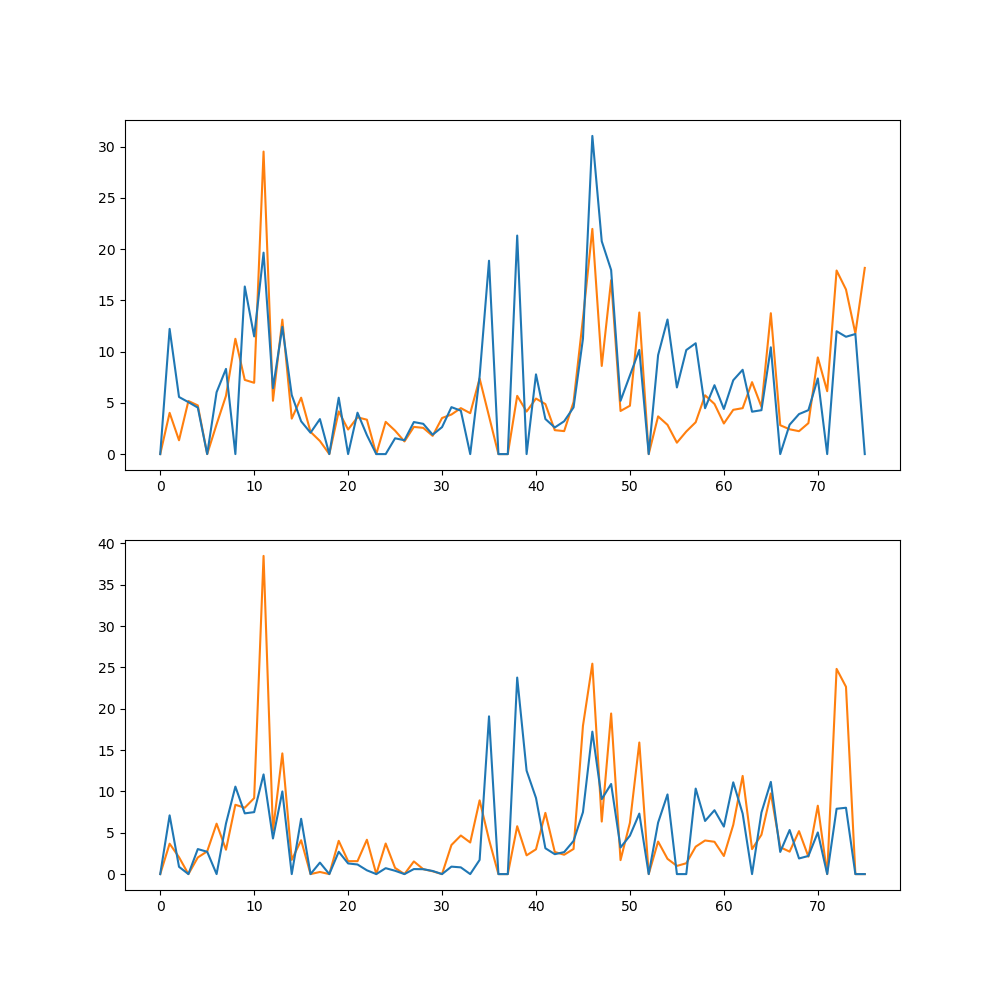

At 100.


proximal MET1  proximal GLN2  proximal ILE3  proximal PHE4  \
0                0.0      12.217007       5.572160       5.067320   
1                0.0      12.498837       5.345943       5.706164   
2                0.0      20.819242       6.101076       5.375016   
3                0.0      19.070689       5.907505       5.416126   
4                0.0      21.594409       5.767675       5.128512   
...              ...            ...            ...            ...   
12007            0.0      13.792561       5.971576       5.845803   
12008            0.0      15.314058       5.940352       6.095857   
12009            0.0      18.841633       6.535123       6.015044   
12010            0.0      14.055607       5.923682       6.044629   
12011            0.0      16.119147       7.198673       5.760437   

       proximal VAL5  proximal LYS6  proximal THR7  proximal LEU8  \
0           4.537088            0.0       6.037019       8.313759   
1           4.638379            0.0       6.677702       9.076959   
2           4.364319            0.0       6.229201       8.214910   
3           4.244733            0.0       6.424281       7.348354   
4           4.196081            0.0       6.541087       7.553576   
...              ...            ...            ...            ...   
12007       4.822964            0.0       6.428681       7.150944   
12008       4.441845            0.0       6.810617       8.402997   
12009       4.770674            0.0       7.579116       8.199392   
12010       5.073687            0.0       6.391470       8.824079   
12011       5.307650            0.0       6.467164       8.910636   

       proximal THR9  proximal GLY10  ...  distal LEU67  distal HIS68  \
0                0.0       16.351987  ...      2.679368      5.330673   
1                0.0       15.748485  ...      2.782011      5.208684   
2                0.0       15.635101  ...      2.942484      4.947769   
3                0.0       13.130162  ...      3.319383      5.664915   
4                0.0       14.133267  ...      2.681924      5.546844   
...              ...             ...  ...           ...           ...   
12007            0.0       17.498136  ...      2.939976      5.747262   
12008            0.0       16.669132  ...      3.015188      7.201893   
12009            0.0       13.820366  ...      3.334469      7.673260   
12010            0.0       13.766340  ...      2.951906      7.320619   
12011            0.0       15.909118  ...      3.164792      6.857352   

       distal LEU69  distal VAL70  distal LEU71  distal ARG72  distal LEU73  \
0          1.890736      2.191844      5.037425           0.0      7.901769   
1          1.747299      1.994969      3.522458           0.0      4.812508   
2          1.831436      1.929865      3.010390           0.0      4.568189   
3          1.799348      1.997923      2.879301           0.0      4.504142   
4          1.972471      2.251277      5.252862           0.0      8.402755   
...             ...           ...           ...           ...           ...   
12007      1.649461      0.186509      2.332775           0.0      2.597618   
12008      1.687461      2.256475      3.610142           0.0     11.143480   
12009      2.396834      2.690310      3.462037           0.0     10.123855   
12010      2.426188      2.485717      3.639680           0.0      9.865777   
12011      2.600650      2.346326      3.894948           0.0      9.165621   

       distal ARG74  distal GLY75  distal GLY76  
0          8.022980           0.0           0.0  
1          7.017510           0.0           0.0  
2          9.252330           0.0           0.0  
3          8.609434           0.0           0.0  
4          7.592399           0.0           0.0  
...             ...           ...           ...  
12007      3.261624           0.0           0.0  
12008      6.936177           0.0           0.0  
12009      8.614927           0.0           0.0  
12010      6.547916    

In [58]:
# get a list of resSeq for 1 UBQ
_ = md.load_pdb('https://files.rcsb.org/view/1UBQ.pdb')
fasta = [i for i in _.top.to_fasta()[0]]
AAs = np.genfromtxt('/home/kevin/projects/paper_2019/amino_acid_names_3_1_letter.txt', delimiter=' - ', dtype=str)
AAs = pd.DataFrame(AAs, columns=['name', '3letter', '1letter'])
AAs = AAs.set_index('1letter')
residues = np.array([f'{n}{i + 1}' for i, n in enumerate(AAs.loc[fasta]['3letter'].str.upper())])

column_names = [f'{i} {j}' for i, j in itertools.product(['proximal', 'distal'], residues)]

# read calculated dataframe
ubq_site = 'k6'
calc = pd.read_csv(f'values_from_every_frame/df_{ubq_site}_correct_columns.csv', index_col=0)
sPRE_ind = calc.columns[['sPRE' in c for c in calc.columns]]
sPRE_calc = calc[sPRE_ind]
sPRE_calc = sPRE_calc.rename(columns={k: v for k, v in zip(sPRE_calc.columns, column_names)})

# read measured dataframe
sPRE_obs = pd.read_csv(f'full_observables/di_ub2_{ubq_site}_sPRE_aligned_to_full_sequence.csv', index_col=0)
sPRE_obs['primary sequence'] = sPRE_obs['primary sequence'].str.upper()
sPRE_obs = sPRE_obs.set_index('primary sequence')
sPRE_obs.index = column_names

# define the observable values
v_obs = sPRE_obs['sPRE'].values

sPRE_calc_norm = []
norm_res_count = 10

for i, row in sPRE_calc.iterrows():
    if i == 100:
        print("At 100.")
    values_calc = row.values
    values_obs = sPRE_obs['sPRE'].values
    assert values_calc.shape == values_obs.shape
    
    # split v_calc and v_obs
    v_calc_prox, v_calc_dist = np.split(v_calc, 2)

    # get 10 smallest non-zero values
    threshold_prox = np.partition(v_calc_prox[np.nonzero(v_calc_prox)], norm_res_count)[norm_res_count - 1]
    threshold_dist = np.partition(v_calc_dist[np.nonzero(v_calc_dist)], norm_res_count)[norm_res_count - 1]
    if i == 0:
        print(f"Proximal threshold = {threshold_prox}, Distal threshold = {threshold_dist}")
    
    # get the columns that fulfill this condition
    min_values = (v_calc_prox <= threshold_prox) & (v_calc_prox != 0.0)
    centers_prox = np.where(min_values)[0]
    min_values = (v_calc_dist <= threshold_dist) & (v_calc_dist != 0.0)
    centers_dist = np.where(min_values)[0]
    centers = np.concatenate([centers_prox, centers_dist + 76])
    
    # test + 76
    a = v_calc_dist[min_values][0]
    b = v_calc[centers][10]
    assert a == b, print(a, b)

    # get the factors
    factors = v_obs[centers] / v_calc[centers]
    if i == 0:
        print("Factors are: ", factors)

    # index the ranges in-between
    edges_prox = np.concatenate([np.array([0]), np.floor(centers_prox[:-1] + ((centers_prox[1:] - centers_prox[:-1]) / 2)), np.array([76])]).astype(int)
    edges_dist = np.concatenate([np.floor(centers_dist[:-1] + ((centers_dist[1:] - centers_dist[:-1]) / 2)), np.array([75])]).astype(int)
    edges = np.concatenate([edges_prox, edges_dist + 76])
    if i == 0:
        print(f"Edges are {edges}")
    
    # copy the existing values and multiply
    new_values = copy.deepcopy(values_calc)

    # debug print
    for j, k, f in zip(edges[:-1], edges[1:], factors):
        if i == 0:
            print(f"Normalizing all residues between {j}:{sPRE_obs.index[j]} and {k}:{sPRE_obs.index[k]} with factor {f}")
        new_values[j:k] *= f
    sPRE_calc_norm.append(new_values)
    
    # make an image
    if i == 0:
        plt.close('all')
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 10))
        
        prox_obs, dist_obs = np.split(sPRE_obs['sPRE'].values, 2)
        prox_calc, dist_calc = np.split(np.array(sPRE_calc_norm[0]), 2)
        lbl2 = ax1.plot(np.arange(len(prox_obs)), prox_obs, color='C1', label='Measurement')
        lbl4 = ax2.plot(np.arange(len(dist_obs)), dist_obs, color='C1', label='Measurement')
        lbl1 = ax1.plot(np.arange(len(prox_obs)), prox_calc, color='C0', label='Simulation')
        lbl3 = ax2.plot(np.arange(len(dist_obs)), dist_calc, color='C0', label='Simulation')
        
sPRE_norm = pd.DataFrame(np.array(sPRE_calc_norm), columns=sPRE_calc.columns)
sPRE_norm

### Straight forward Gong

In [162]:
# get a list of resSeq for 1 UBQ
_ = md.load_pdb('https://files.rcsb.org/view/1UBQ.pdb')
fasta = [i for i in _.top.to_fasta()[0]]
AAs = np.genfromtxt('/home/kevin/projects/paper_2019/amino_acid_names_3_1_letter.txt', delimiter=' - ', dtype=str)
AAs = pd.DataFrame(AAs, columns=['name', '3letter', '1letter'])
AAs = AAs.set_index('1letter')
residues = np.array([f'{n}{i + 1}' for i, n in enumerate(AAs.loc[fasta]['3letter'].str.upper())])

column_names = [f'{i} {j}' for i, j in itertools.product(['proximal', 'distal'], residues)]

# read calculated dataframe
ubq_site = 'k6'
calc = pd.read_csv(f'values_from_every_frame/df_{ubq_site}_correct_columns.csv', index_col=0)
sPRE_ind = calc.columns[['sPRE' in c for c in calc.columns]]
sPRE_calc = calc[sPRE_ind]
sPRE_calc = sPRE_calc.rename(columns={k: v for k, v in zip(sPRE_calc.columns, column_names)})

# find residue with smallest ptp
ptp = np.ptp(sPRE_calc.values, axis=0)
assert ptp.shape[0] == 152

# split ptp and find smallest nonzero
ptp_prox, ptp_dist = np.split(ptp, 2)
min_prox = np.min(ptp_prox[np.nonzero(ptp_prox)])
min_prox_ind = np.where(ptp == min_prox)[0][0]
min_dist = np.min(ptp_dist[np.nonzero(ptp_dist)])
min_dist_ind = np.where(ptp == min_dist)[0][0] - 76
print(min_prox_ind, min_dist_ind)
print(f"The smallest variance of Proximal can be found in {sPRE_calc.columns[min_prox_ind]}, for Distal in {sPRE_calc.columns[min_dist_ind]}")

prox, dist = np.split(sPRE_calc.values, 2, axis=0)
print(np.min(prox[min_prox_ind]), np.max(prox[min_prox_ind]))
print(np.min(dist[min_dist_ind]), np.max(dist[min_dist_ind]))
prox[np.nonzero(prox)] /= np.max(prox[min_prox_ind])
dist[np.nonzero(dist)] /= np.max(dist[min_dist_ind])
print(np.min(prox[min_prox_ind]), np.max(prox[min_prox_ind]))
print(np.min(dist[min_dist_ind]), np.max(dist[min_dist_ind]))

new_values = np.vstack([prox, dist])

sPRE_norm = pd.DataFrame(new_values, columns=sPRE_calc.columns)
sPRE_norm

42 42
The smallest variance of Proximal can be found in proximal LEU43, for Distal in proximal LEU43
0.0 0.834321804059736
0.0 0.9301066529179304
0.0 1.0
0.0 1.0


proximal MET1  proximal GLN2  proximal ILE3  proximal PHE4  \
0                0.0       0.416811       0.190107       0.172883   
1                0.0       0.426426       0.182389       0.194679   
2                0.0       0.710296       0.208152       0.183381   
3                0.0       0.650640       0.201548       0.184784   
4                0.0       0.736743       0.196777       0.174971   
...              ...            ...            ...            ...   
12007            0.0       0.422105       0.182753       0.178904   
12008            0.0       0.468668       0.181797       0.186556   
12009            0.0       0.576625       0.200000       0.184083   
12010            0.0       0.430155       0.181287       0.184989   
12011            0.0       0.493307       0.220307       0.176291   

       proximal VAL5  proximal LYS6  proximal THR7  proximal LEU8  \
0           0.154793            0.0       0.205967       0.283643   
1           0.158249            0.0       0.227825       0.309681   
2           0.148899            0.0       0.212523       0.280270   
3           0.144819            0.0       0.219179       0.250706   
4           0.143159            0.0       0.223164       0.257707   
...              ...            ...            ...            ...   
12007       0.147601            0.0       0.196742       0.218846   
12008       0.135937            0.0       0.208431       0.257164   
12009       0.146001            0.0       0.231950       0.250932   
12010       0.155274            0.0       0.195603       0.270050   
12011       0.162434            0.0       0.197920       0.272699   

       proximal THR9  proximal GLY10  ...  distal LEU67  distal HIS68  \
0                0.0        0.557885  ...      0.140411      0.150094   
1                0.0        0.537296  ...      0.145790      0.146659   
2                0.0        0.533427  ...      0.154200      0.139312   
3                0.0        0.447965  ...      0.173951      0.159505   
4                0.0        0.482189  ...      0.140545      0.156180   
...              ...             ...  ...           ...           ...   
12007            0.0        0.535509  ...      0.138202      0.145158   
12008            0.0        0.510139  ...      0.141737      0.181898   
12009            0.0        0.422956  ...      0.156746      0.193803   
12010            0.0        0.421302  ...      0.138763      0.184896   
12011            0.0        0.486879  ...      0.148770      0.173196   

       distal LEU69  distal VAL70  distal LEU71  distal ARG72  distal LEU73  \
0          0.136860      0.158656      0.364631           0.0      0.571965   
1          0.126477      0.144405      0.254971           0.0      0.348351   
2          0.132568      0.139692      0.217906           0.0      0.330666   
3          0.130245      0.144619      0.208417           0.0      0.326030   
4          0.142776      0.162958      0.380226           0.0      0.608229   
...             ...           ...           ...           ...           ...   
12007      0.107100      0.012110      0.151467           0.0      0.168664   
12008      0.109567      0.146513      0.234407           0.0      0.723548   
12009      0.155627      0.174682      0.224791           0.0      0.657343   
12010      0.157533      0.161398      0.236325           0.0      0.640586   
12011      0.168861      0.152347      0.252899           0.0      0.595125   

       distal ARG74  distal GLY75  distal GLY76  
0          0.580739           0.0           0.0  
1          0.507959           0.0           0.0  
2          0.669725           0.0           0.0  
3          0.623189           0.0           0.0  
4          0.549572           0.0           0.0  
...             ...           ...           ...  
12007      0.211778           0.0           0.0  
12008      0.450367           0.0           0.0  
12009      0.559368           0.0           0.0  
12010      0.425157    

### Gong but not normalizing to 0-1, but make mean fit obs

In [160]:
# get a list of resSeq for 1 UBQ
_ = md.load_pdb('https://files.rcsb.org/view/1UBQ.pdb')
fasta = [i for i in _.top.to_fasta()[0]]
AAs = np.genfromtxt('/home/kevin/projects/paper_2019/amino_acid_names_3_1_letter.txt', delimiter=' - ', dtype=str)
AAs = pd.DataFrame(AAs, columns=['name', '3letter', '1letter'])
AAs = AAs.set_index('1letter')
residues = np.array([f'{n}{i + 1}' for i, n in enumerate(AAs.loc[fasta]['3letter'].str.upper())])

column_names = [f'{i} {j}' for i, j in itertools.product(['proximal', 'distal'], residues)]

# read calculated dataframe
ubq_site = 'k6'
calc = pd.read_csv(f'values_from_every_frame/df_{ubq_site}_correct_columns.csv', index_col=0)
sPRE_ind = calc.columns[['sPRE' in c for c in calc.columns]]
sPRE_calc = calc[sPRE_ind]
sPRE_calc = sPRE_calc.rename(columns={k: v for k, v in zip(sPRE_calc.columns, column_names)})

# find residue with smallest ptp
ptp = np.ptp(sPRE_calc.values, axis=0)
assert ptp.shape[0] == 152

# split ptp and find smallest nonzero
ptp_prox, ptp_dist = np.split(ptp, 2)
min_prox = np.min(ptp_prox[np.nonzero(ptp_prox)])
min_prox_ind = np.where(ptp == min_prox)[0][0]
min_dist = np.min(ptp_dist[np.nonzero(ptp_dist)])
min_dist_ind = np.where(ptp == min_dist)[0][0] - 76
print(min_prox_ind, min_dist_ind)
print(f"The smallest variance of Proximal can be found in {sPRE_calc.columns[min_prox_ind]}, for Distal in {sPRE_calc.columns[min_dist_ind]}")

# read measured dataframe
sPRE_obs = pd.read_csv(f'full_observables/di_ub2_{ubq_site}_sPRE_aligned_to_full_sequence.csv', index_col=0)
sPRE_obs['primary sequence'] = sPRE_obs['primary sequence'].str.upper()
sPRE_obs = sPRE_obs.set_index('primary sequence')
sPRE_obs.index = column_names

means = np.mean(sPRE_calc.values[[min_prox_ind, min_dist_ind + 76]], axis=1)
print(f"The mean values of these residues are: {means}")

# define the observable values
v_obs = sPRE_obs['sPRE'].values

obs = v_obs[[min_prox_ind, min_dist_ind + 76]]
print(f"The corresponding obs values are: {obs}")

factors = obs / means
print(f"For this I will use the factors {factors}")

prox, dist = np.split(sPRE_calc.values, 2, axis=0)
prox[np.nonzero(prox)] *= factors[0]
dist[np.nonzero(dist)] *= factors[1]

new_values = np.vstack([prox, dist])

sPRE_norm = pd.DataFrame(new_values, columns=sPRE_calc.columns)
sPRE_norm

42 42
The smallest variance of Proximal can be found in proximal LEU43, for Distal in proximal LEU43
The mean values of these residues are: [0.21436165 0.20098342]
The corresponding obs values are: [2.33349208 2.67593366]
For this I will use the factors [10.88577196 13.31420078]


proximal MET1  proximal GLN2  proximal ILE3  proximal PHE4  \
0                0.0       3.785577       1.726596       1.570166   
1                0.0       3.872905       1.656500       1.768119   
2                0.0       6.451076       1.890487       1.665509   
3                0.0       5.909267       1.830507       1.678248   
4                0.0       6.691271       1.787179       1.589127   
...              ...            ...            ...            ...   
12007            0.0       5.227187       2.263143       2.215477   
12008            0.0       5.803813       2.251310       2.310244   
12009            0.0       7.140715       2.476720       2.279617   
12010            0.0       5.326878       2.244992       2.290829   
12011            0.0       6.108930       2.728196       2.183125   

       proximal VAL5  proximal LYS6  proximal THR7  proximal LEU8  \
0           1.405868            0.0       1.870638       2.576112   
1           1.437254            0.0       2.069161       2.812598   
2           1.352333            0.0       1.930188       2.545482   
3           1.315278            0.0       1.990636       2.276970   
4           1.300203            0.0       2.026829       2.340560   
...              ...            ...            ...            ...   
12007       1.827835            0.0       2.436380       2.710107   
12008       1.683397            0.0       2.581128       3.184618   
12009       1.808018            0.0       2.872379       3.107454   
12010       1.922856            0.0       2.422278       3.344202   
12011       2.011525            0.0       2.450964       3.377006   

       proximal THR9  proximal GLY10  ...  distal LEU67  distal HIS68  \
0                0.0        5.066847  ...      1.275247      1.363185   
1                0.0        4.879845  ...      1.324100      1.331989   
2                0.0        4.844712  ...      1.400477      1.265267   
3                0.0        4.068528  ...      1.579862      1.448659   
4                0.0        4.379352  ...      1.276464      1.418465   
...              ...             ...  ...           ...           ...   
12007            0.0        6.631548  ...      1.711439      1.797586   
12008            0.0        6.317367  ...      1.755223      2.252554   
12009            0.0        5.237725  ...      1.941084      2.399985   
12010            0.0        5.217250  ...      1.718384      2.289688   
12011            0.0        6.029332  ...      1.842311      2.144791   

       distal LEU69  distal VAL70  distal LEU71  distal ARG72  distal LEU73  \
0          1.242995      1.440947      3.311669           0.0      5.194726   
1          1.148697      1.311519      2.315710           0.0      3.163805   
2          1.204010      1.268718      1.979069           0.0      3.003187   
3          1.182915      1.313461      1.892890           0.0      2.961082   
4          1.296728      1.480019      3.453300           0.0      5.524081   
...             ...           ...           ...           ...           ...   
12007      1.326283      0.149966      1.875716           0.0      2.088668   
12008      1.356837      1.814366      2.902809           0.0      8.960145   
12009      1.927224      2.163199      2.783722           0.0      8.140294   
12010      1.950826      1.998692      2.926560           0.0      7.932781   
12011      2.091106      1.886612      3.131813           0.0      7.369807   

       distal ARG74  distal GLY75  distal GLY76  
0          5.274411           0.0           0.0  
1          4.613403           0.0           0.0  
2          6.082602           0.0           0.0  
3          5.659954           0.0           0.0  
4          4.991342           0.0           0.0  
...             ...           ...           ...  
12007      2.622576           0.0           0.0  
12008      5.577176           0.0           0.0  
12009      6.927010           0.0           0.0  
12010      5.264987    

## Simple plot

<IPython.core.display.Javascript object>


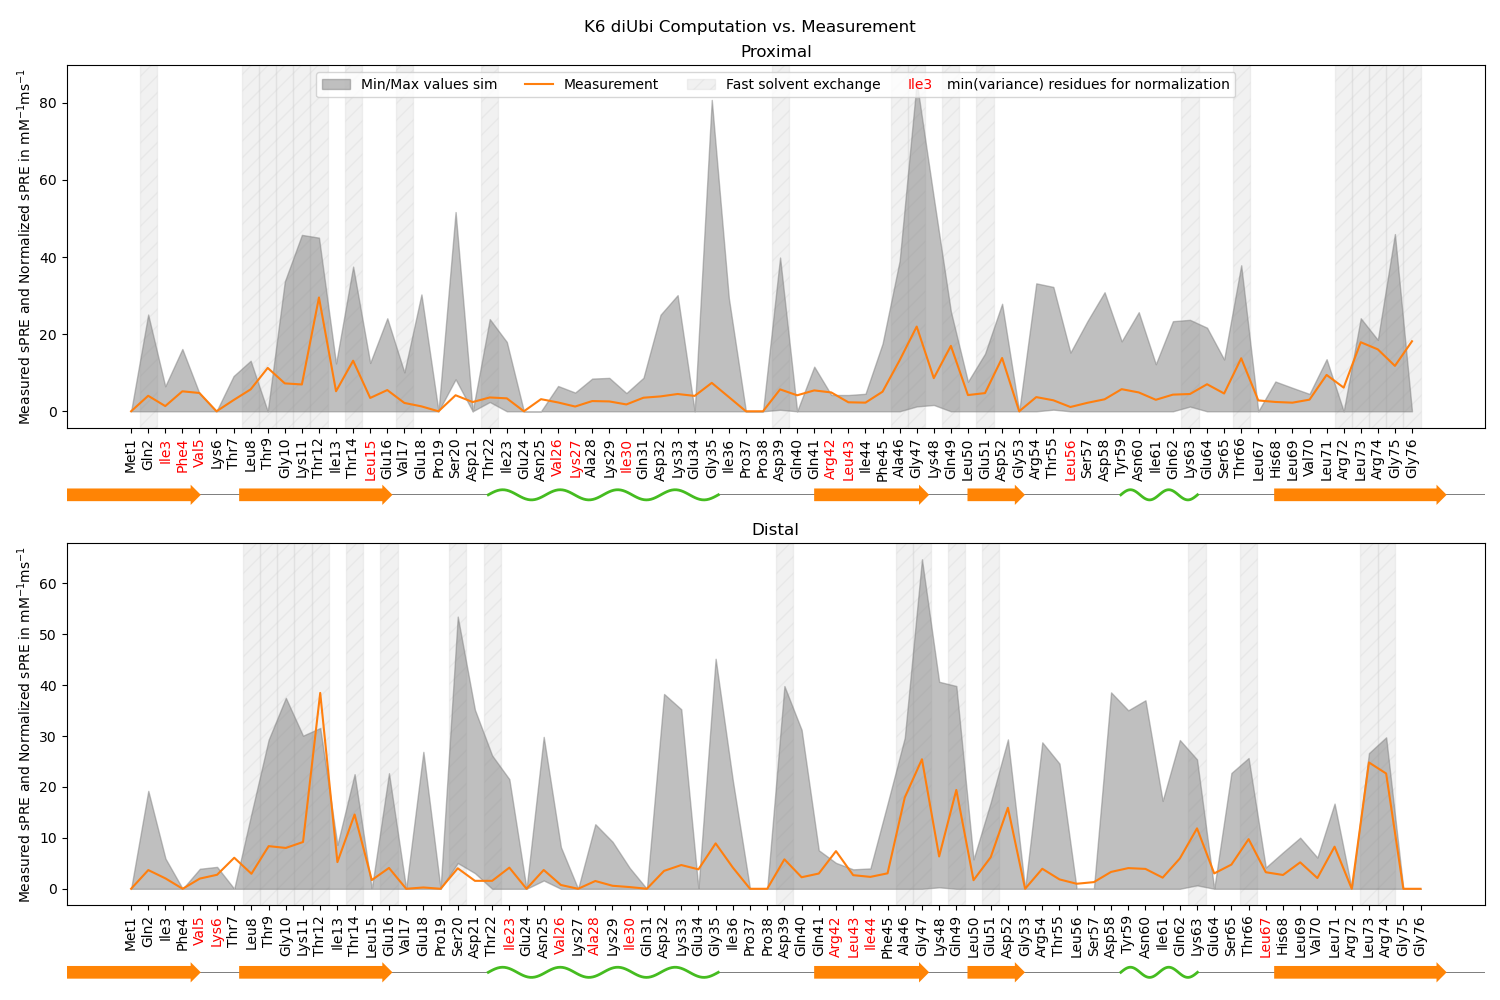

In [34]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import biotite.sequence.graphics as graphics
from XPLOR_functions import *
from Bio.SeqUtils import seq3
from matplotlib.ticker import AutoMinorLocator

############################### OPTIONS ##########################
split_axes = False
obs_normalized = False
ubq_site = 'k6'

############################### CLASSES ##########################

plt.close('all')
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(15, 10))

ax1.set_title('Proximal')
ax2.set_title('Distal')
fig.suptitle(f'{ubq_site.upper()} diUbi Computation vs. Measurement')

# plots
# fill space between max and min
prox, dist = np.split(sPRE_norm, 2, axis=1)
prox_max = prox.max(axis=0)
prox_min = prox.min(axis=0)
dist_max = dist.max(axis=0)
dist_min = dist.min(axis=0)
lbl1 = ax1.fill_between(np.arange(len(prox_max)), prox_max, prox_min, color='grey', alpha=0.5, label='Min/Max values sim')
lbl3 = ax2.fill_between(np.arange(len(dist_max)), dist_max, dist_min, color='grey', alpha=0.5, label='Min/Max values sim')

# plot measurements
K6_obs_sPRE_all = pd.read_csv(f'full_observables/di_ub2_{ubq_site}_sPRE_aligned_to_full_sequence.csv', index_col=0)
prox_obs, dist_obs = np.split(K6_obs_sPRE_all['sPRE'].values, 2)
if obs_normalized:
    indices_from_gong = 42
    prox_obs *= (0.5 / prox_obs[indices_from_gong])
    print(prox_obs[indices_from_gong])
    dist_obs *= (0.5 / dist_obs[indices_from_gong])
else:
    pass
#     ax1_obs = ax1.twinx()
#     ax2_obs = ax2.twinx()
if split_axes:
    lbl2 = ax1_obs.plot(np.arange(len(prox_obs)), prox_obs, color='C1', label='Measurement')
    lbl4 = ax2_obs.plot(np.arange(len(dist_obs)), dist_obs, color='C1', label='Measurement')
else:
    lbl2 = ax1.plot(np.arange(len(prox_obs)), prox_obs, color='C1', label='Measurement')
    lbl4 = ax2.plot(np.arange(len(dist_obs)), dist_obs, color='C1', label='Measurement')

# for i in indices[:10]:
#     ax1.vlines(i, 0, 2, color='red')

# set ticks
_ = md.load_pdb('https://files.rcsb.org/view/1UBQ.pdb')
fasta = _.top.to_fasta()[0]
labels = [f"{seq3(f)}{i + 1}" for i, f in enumerate(fasta)]
xticks = np.arange(len(labels))
numElems = 76
idx = np.round(np.linspace(0, len(xticks) - 1, numElems)).astype(int)

# set ticks and sequence elements
for i, ax in enumerate([ax1, ax2, ax1_obs, ax2_obs]):
    ax.set_xticks(xticks[idx])
    ax.set_xticklabels(np.array(labels)[idx], rotation=90)
    if i < 2:
        if split_axes:
            ax.set_ylabel(r"Normalized Calculated sPRE")
            ax.set_xticks(xticks, minor=True)
        else:
            ax.set_ylabel(r'Measured sPRE and Normalized sPRE in $\mathrm{mM^{-1}ms^{-1}}$')
    else:
        ax.set_ylabel(r'Measured sPRE in $\mathrm{mM^{-1}ms^{-1}}$')

    ax_divider = make_axes_locatable(ax)
    # add an axes above the main axes.
    ax_bottom = ax_divider.append_axes("bottom", size="7%", pad="15%")
    graphics.plot_feature_map(
        ax_bottom, ubq_sec_annotation, multi_line=False, loc_range=(1,75),
        # Register our drawing functions
        feature_plotters=[HelixPlotter(), SheetPlotter()]
    )
    ax_bottom.set_zorder(-2)
    
# add fast exhangers as hatched hfill
fast_exchangers = pd.read_csv('fast_exchangers.csv', index_col=0)
for site, ax in zip(['prox', 'dist'], [ax1, ax2]):
    sub_df = fast_exchangers.loc[f"{site}_{ubq_site}"]
    for i, is_fast in enumerate(sub_df):
        if is_fast:
            _ = ax.axvspan(i - 0.5, i + 0.5, alpha=0.3, color='lightgrey', hatch='//', zorder=-5, label='Fast solvent exchange')
    else:
        if ax is ax1:
            lbl_fast_ax1 = _
        else:
            lbl_fast_ax2 = _
            
# color the cneters red
for c in centers_prox:
    ax1.get_xticklabels()[c].set_color("red")
for c in centers_dist - 76:
    ax2.get_xticklabels()[c].set_color("red")
    
# legend
legend_text = AnyObject("Ile3", "red", label='Min(variance) residues for normalization')
lns = [lbl1] + lbl2 + [lbl_fast_ax1] + [legend_text]
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0, ncol=4, handler_map={legend_text:AnyObjectHandler()})
lns = [lbl3] + lbl4 + [lbl_fast_ax2]
labs = [l.get_label() for l in lns]
# ax2.legend(lns, labs, loc=0)
    
plt.tight_layout()    

plt.savefig(f'images/di_ub2_{ubq_site}_sPRE_calc_vs_measure.highq.png', dpi=600, transparent=True)
plt.savefig(f'images/di_ub2_{ubq_site}_sPRE_calc_vs_measure.png', dpi=300, transparent=False)
plt.savefig(f'images/di_ub2_{ubq_site}_sPRE_calc_vs_measure.pdf', transparent=True)

In [16]:
ax1.get_xticklabels()[np.array([1, 2, 5, 10])]

TypeError: only integer scalar arrays can be converted to a scalar index

## Find closest structure

In [82]:
from XPLOR_functions import *

In [83]:
_ = make_sPRE_table('full_observables/spre_and_relaxation_data_k6_k29/di_ub2_k6_*_sPRE.txt')
_

primary sequence       sPRE       err  resSeq  position
0               Met1        NaN       NaN       1  proximal
1               Gln2   4.024789  0.337223       2  proximal
2               Ile3   1.348830  0.413077       3  proximal
3               Phe4   5.180514  1.036943       4  proximal
4               Val5   4.749073  0.531051       5  proximal
..               ...        ...       ...     ...       ...
144            Val70   2.110228  1.761708     146    distal
145            Leu71   8.269641  1.182955     147    distal
146            Arg72        NaN       NaN     148    distal
147            Leu73  24.817400  0.956704     149    distal
148            Arg74  22.651498  2.220798     150    distal

[149 rows x 5 columns]

### Align data

In [84]:
from XPLOR_functions import *
K6_obs_sPRE = make_sPRE_table('full_observables/spre_and_relaxation_data_k6_k29/di_ub2_k6_*_sPRE.txt')
K29_obs_sPRE = make_sPRE_table('full_observables/spre_and_relaxation_data_k6_k29/di_ub2_k29_*_sPRE.txt')
K29_obs_sPRE

primary sequence       sPRE       err  resSeq  position
0               Met1        NaN       NaN       1  proximal
1               Gln2   6.029261  1.230660       2  proximal
2               Ile3   3.546608  1.027895       3  proximal
3               Phe4   4.236416  0.705679       4  proximal
4               Val5   4.629300  0.429045       5  proximal
..               ...        ...       ...     ...       ...
144            Val70   2.272825       NaN     146    distal
145            Leu71   9.453179  1.374117     147    distal
146            Arg72        NaN       NaN     148    distal
147            Leu73   8.471020  1.545317     149    distal
148            Arg74  14.526443  1.751067     150    distal

[149 rows x 5 columns]

In [69]:
ubq_site = 'k29'

underlying_df = K29_obs_sPRE

obs_sPRE_all = pd.DataFrame(columns=underlying_df.columns)

_ = md.load_pdb('https://files.rcsb.org/view/1UBQ.pdb')
fasta = _.top.to_fasta()[0]
labels = [f"{seq3(f)}{i + 1} proximal" for i, f in enumerate(fasta)]
labels += [f"{seq3(f)}{i + 1} distal" for i, f in enumerate(fasta)]

for label in labels:
    seq, pos = label.split()
    resSeq = int(seq[3:])
    row = underlying_df[(underlying_df['primary sequence'] == seq) & (underlying_df['position'] == pos)]
    if not row.empty:
        sPRE = float(row['sPRE'])
        if np.isnan(sPRE):
            sPRE = 0.0
        err = float(row['err'])
        if np.isnan(err):
            err = 0.0
    else:
        sPRE = 0.0
        err = 0.0
    data = {'primary sequence': seq, 'sPRE': sPRE, 'err': err, 'resSeq': resSeq, 'position': pos}
    obs_sPRE_all = obs_sPRE_all.append(data, ignore_index=True)
# obs_sPRE_all = obs_sPRE_all.T
obs_sPRE_all.to_csv(f'full_observables/di_ub2_{ubq_site}_sPRE_aligned_to_full_sequence.csv')

### Get argmin of diff

old: 1252

In [91]:
ubq_site = 'k6'

obs_sPRE_all = pd.read_csv(f'full_observables/di_ub2_{ubq_site}_sPRE_aligned_to_full_sequence.csv', index_col=0)
sPRE_norm = pd.read_csv(f'sPRE_{ubq_site}_normalized_via_10_min_variance.csv', index_col=0)
sPRE_ind = [i for i in sPRE_norm.columns if ' ' in i]

values = obs_sPRE_all['sPRE'].values
calc_values = sPRE_norm[sPRE_ind].values
diff = np.abs(calc_values - values)
mean = np.mean(diff, axis=1)
found = np.argmin(mean)
print(found)

11354


### Render

In [95]:
traj = md.load_frame(sPRE_norm.iloc[found]['traj_file'], index=sPRE_norm.iloc[found]['frame'], top=sPRE_norm.iloc[found]['top_file'])
traj.save_pdb(f'{ubq_site}_best_fitting_structure_at_iloc_{found}.pdb')
view = ngl.show_mdtraj(traj, gui=True)
view

NGLWidget()

In [96]:
!convert k6_best_fitting_structure_at_iloc_11354.tga k6_best_fitting_structure_at_iloc_11354.png

convert: error while loading shared libraries: libwebp.so.5: cannot open shared object file: No such file or directory


### Plot

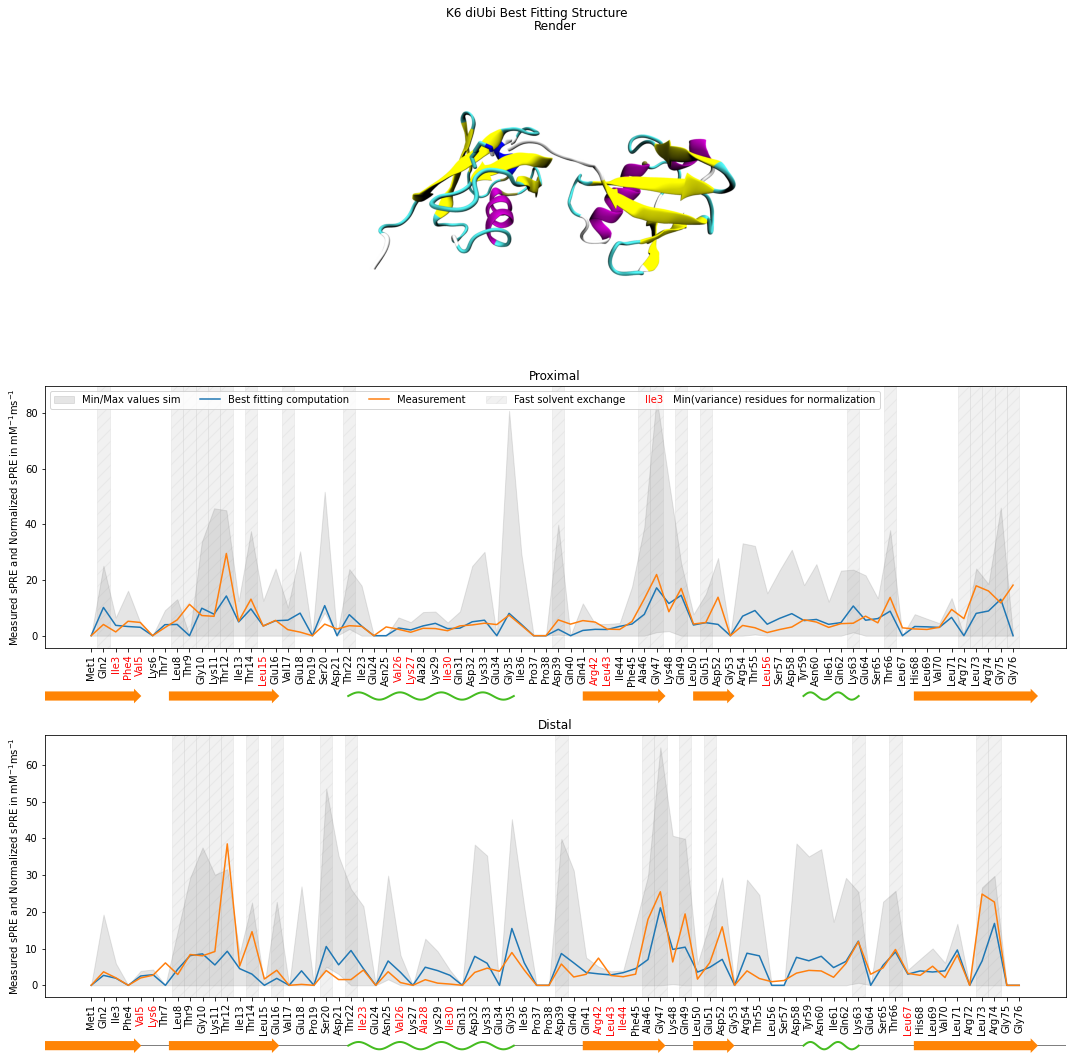

In [130]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import biotite.sequence.graphics as graphics
from XPLOR_functions import *
from Bio.SeqUtils import seq3
from matplotlib.ticker import AutoMinorLocator

plt.close('all')
fig, (ax, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 15))

if 'found' not in globals():
    found = 11354
    
split_axes = False

# names
ax.set_title("Render")
ax1.set_title('Proximal')
ax2.set_title('Distal')
fig.suptitle('K6 diUbi Best Fitting Structure')

# image
im = plt.imread(f'{ubq_site}_best_fitting_structure_at_iloc_{found}.png')
ax.imshow(im)
ax.set_xticks([])
ax.set_yticks([])
[k.set_linewidth(0) for k in ax.spines.values()]

# plots
# fill space between max and min
lbl1 = ax1.fill_between(np.arange(len(prox_max)), prox_max, prox_min, color='grey', alpha=0.2, label='Min/Max values sim')
lbl4 = ax2.fill_between(np.arange(len(dist_max)), dist_max, dist_min, color='grey', alpha=0.2, label='Min/Max values sim')

# plot closest computation
# prox_comp, dist_comp = np.split(df.iloc[found][sPRE_ind].values, 2)
# prox_comp[np.nonzero(prox_comp)[0]] -= np.min(prox_comp[np.nonzero(prox_comp)[0]])
# dist_comp[np.nonzero(dist_comp)[0]] -= np.min(dist_comp[np.nonzero(dist_comp)[0]])
sPRE_norm = pd.read_csv(f'sPRE_{ubq_site}_normalized_via_10_min_variance.csv', index_col=0)
sPRE_ind = [i for i in sPRE_norm.columns if ' ' in i]
prox, dist = np.split(sPRE_norm[sPRE_ind].values, 2, axis=1)
prox_comp = prox[found]
dist_comp = dist[found]
lbl2 = ax1.plot(np.arange(len(prox_comp)), prox_comp, color='C0', label='Best fitting computation')
lbl5 = ax2.plot(np.arange(len(dist_comp)), dist_comp, color='C0', label='Best fitting computation')

# plot measurements
K6_obs_sPRE_all = pd.read_csv('full_observables/di_ub2_k6_sPRE_aligned_to_full_sequence.csv', index_col=0)
prox_obs, dist_obs = np.split(K6_obs_sPRE_all['sPRE'], 2)
lbl3 = ax1.plot(np.arange(len(prox_obs)), prox_obs, color='C1', label='Measurement')
lbl6 = ax2.plot(np.arange(len(dist_obs)), dist_obs, color='C1', label='Measurement')

# set ticks
_ = md.load_pdb('https://files.rcsb.org/view/1UBQ.pdb')
fasta = _.top.to_fasta()[0]
labels = [f"{seq3(f)}{i + 1}" for i, f in enumerate(fasta)]
xticks = np.arange(len(labels))
numElems = 76
idx = np.round(np.linspace(0, len(xticks) - 1, numElems)).astype(int)

# set ticks and sequence elements
for i, ax in enumerate([ax1, ax2, ax1_obs, ax2_obs]):
    ax.set_xticks(xticks[idx])
    ax.set_xticklabels(np.array(labels)[idx], rotation=90)
    if i < 2:
        if split_axes:
            ax.set_ylabel(r"Normalized Calculated sPRE")
            ax.set_xticks(xticks, minor=True)
        else:
            ax.set_ylabel(r'Measured sPRE and Normalized sPRE in $\mathrm{mM^{-1}ms^{-1}}$')
    else:
        ax.set_ylabel(r'Measured sPRE in $\mathrm{mM^{-1}ms^{-1}}$')

    ax_divider = make_axes_locatable(ax)
    # add an axes above the main axes.
    ax_bottom = ax_divider.append_axes("bottom", size="7%", pad="15%")
    graphics.plot_feature_map(
        ax_bottom, ubq_sec_annotation, multi_line=False, loc_range=(1,75),
        # Register our drawing functions
        feature_plotters=[HelixPlotter(), SheetPlotter()]
    )
    ax_bottom.set_zorder(-2)
    
# add fast exhangers as hatched hfill
fast_exchangers = pd.read_csv('fast_exchangers.csv', index_col=0)
for site, ax in zip(['prox', 'dist'], [ax1, ax2]):
    sub_df = fast_exchangers.loc[f"{site}_{ubq_site}"]
    for i, is_fast in enumerate(sub_df):
        if is_fast:
            _ = ax.axvspan(i - 0.5, i + 0.5, alpha=0.3, color='lightgrey', hatch='//', zorder=-5, label='Fast solvent exchange')
    else:
        if ax is ax1:
            lbl_fast_ax1 = _
        else:
            lbl_fast_ax2 = _
            
# color the cneters red
for c in centers_prox:
    ax1.get_xticklabels()[c].set_color("red")
for c in centers_dist - 76:
    ax2.get_xticklabels()[c].set_color("red")
    
# legend
legend_text = AnyObject("Ile3", "red", label='Min(variance) residues for normalization')
lns = [lbl1] + lbl2 + lbl3 + [lbl_fast_ax1] + [legend_text]
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0, ncol=5, handler_map={legend_text:AnyObjectHandler()})
    
plt.tight_layout()
    
plt.savefig(f'images/di_ub2_{ubq_site}_sPRE_best_fit.highq.png', dpi=600, transparent=True)
plt.savefig(f'images/di_ub2_{ubq_site}_sPRE_best_fit.png', dpi=300, transparent=False)
plt.savefig(f'images/di_ub2_{ubq_site}_sPRE_best_fit.pdf', transparent=True)

In [109]:
lbl2

## PCA

### Remove fast exchangers

In [115]:
fast_exchangers = pd.read_csv('fast_exchangers.csv', index_col=0)

ubq_site = 'k6'
fast_exchange = np.hstack(fast_exchangers.loc[[i for i in fast_exchangers.index if ubq_site in i]].values)
fast_exchange.shape

(152,)

### Get lowd

/home/kevin/.conda/envs/tf2_38/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(12012, 113)
[[ 1.6673837   2.7429702 ]
 [ 2.767205    3.34067   ]
 [ 3.3182654   6.5322127 ]
 ...
 [-3.0382836   4.7853155 ]
 [-1.0656667   6.77914   ]
 [-0.21059416  5.6396613 ]]


/home/kevin/.conda/envs/tf2_38/lib/python3.8/site-packages/pyemma/_ext/variational/estimators/covar_c/covartools.py:37: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cols = numpy.zeros(X.shape[1], dtype=numpy.bool, order='C')
/home/kevin/.conda/envs/tf2_38/lib/python3.8/site-packages/pyemma/_ext/variational/estimators/covar_c/covartools.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs

(<Figure size 720x360 with 3 Axes>, <AxesSubplot:>)

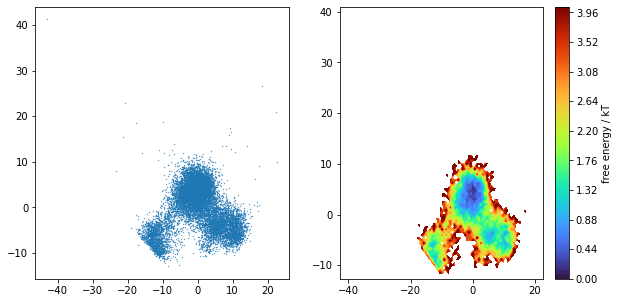

In [144]:
from pyemma import coordinates
sPRE_norm = pd.read_csv(f'sPRE_{ubq_site}_normalized_via_10_min_variance.csv', index_col=0)
sPRE_ind = [i for i in sPRE_norm.columns if ' ' in i]
data = sPRE_norm[sPRE_ind].values[:,~fast_exchange]
print(data.shape)
pca = coordinates.pca(data=data, dim=2)
lowd = pca.get_output()[0]
print(lowd)
plt.close('all')

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
ax1.scatter(*lowd[:,:2].T, s=.1)
pyemma.plots.plot_free_energy(*lowd[:,:2].T, ax=ax2, cmap=plt.cm.turbo)

### Cluster

In [145]:
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=100, cluster_selection_method='leaf').fit(lowd)
print(np.unique(clusterer.labels_))

/home/kevin/.conda/envs/tf2_38/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/kevin/.conda/envs/tf2_38/lib/python3.8/site-packages/hdbscan/hdbscan_.py:275: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  alg = KDTreeBoruvkaAlgorithm(tree, min_samples, metric=metric,


[-1  0  1  2  3]


/home/kevin/.conda/envs/tf2_38/lib/python3.8/site-packages/hdbscan/hdbscan_.py:56: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  condensed_tree = condense_tree(single_linkage_tree,
/home/kevin/.conda/envs/tf2_38/lib/python3.8/site-packages/hdbscan/hdbscan_.py:59: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more detail

/home/kevin/.conda/envs/tf2_38/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


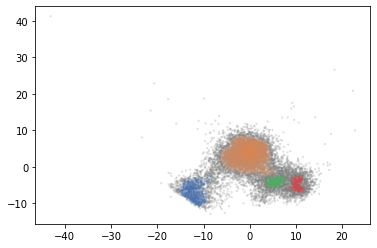

In [146]:
plt.close('all')
color_palette = sns.color_palette('deep', clusterer.labels_.max() + 1)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
projection = None
fig = plt.figure()
ax = fig.add_subplot(projection=projection)
ax.scatter(*lowd[:,:2].T, s=5, linewidth=0, c=cluster_member_colors, alpha=0.25)

### Render this cluster

<IPython.core.display.Javascript object>


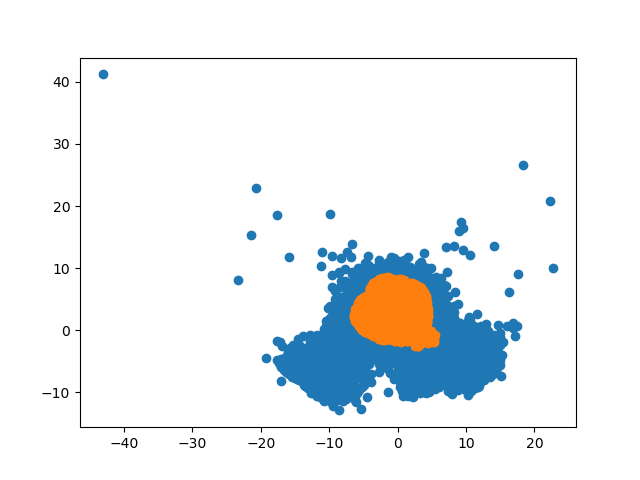

In [133]:
plt.close('all')
plt.scatter(*lowd[:,:2].T)
plt.scatter(*lowd[clusterer.labels_ == 1,:2].T)

In [143]:
print(df.shape)
print(clusterer.labels_.shape)

(12012, 460)
(12012,)


In [147]:
cluster_num = 1
cluster_df = df[clusterer.labels_ == cluster_num]
print(np.unique(cluster_df['traj_file']))
print(np.unique(cluster_df['top_file']))
# traj = em.Info_single('/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_01_02/traj_nojump.xtc', '/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_01_02/start.pdb')
trajs = em.Info_all(glob.glob(f"/home/andrejb/Research/SIMS/2017_04_27_G_2ub_{ubq_site}*/traj_nojump.xtc"),
                   f'/home/andrejb/Research/SIMS/2017_04_27_G_2ub_{ubq_site}_01_02/start.pdb', common_str=['k6'])
cluster_membership = np.full(trajs.n_frames, -1)
where = cluster_df['frame'].values
cluster_membership[where] = 0
trajs.load_CVs(cluster_membership, 'cluster_membership')

['/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_01_01/traj_nojump.xtc'
 '/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_01_02/traj_nojump.xtc'
 '/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_01_03/traj_nojump.xtc'
 '/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_01_04/traj_nojump.xtc'
 '/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_01_05/traj_nojump.xtc'
 '/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_01_06/traj_nojump.xtc'
 '/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_02_01/traj_nojump.xtc'
 '/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_02_02/traj_nojump.xtc'
 '/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_02_03/traj_nojump.xtc'
 '/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_02_04/traj_nojump.xtc'
 '/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_02_05/traj_nojump.xtc'
 '/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_02_06/traj_nojump.xtc']
['/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_01_01/start.pdb'
 '/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_01_02/

In [148]:
_ = md.load_pdb('https://files.rcsb.org/view/1UBQ.pdb')
fasta = _.top.to_fasta()[0]
labels = [seq3(f) for f in fasta]
n_lysines = labels.count('Lys')
print(n_lysines)

7


In [119]:
view = ngl.widget.NGLWidget(gui=True)

side = 'proximal'

if side == 'distal':
    _, dummy_traj = em.misc.clustering.gen_dummy_traj(trajs, 0, stack_atoms=True, nglview=True, superpose=True, max_frames=40, align_string='name CA and resid <= 75')
    com_proximal = np.mean(md.compute_center_of_geometry(dummy_traj.atom_slice(dummy_traj.top.select('resid <= 75'))), axis=0) * 10
    com_distal = np.mean(md.compute_center_of_geometry(dummy_traj.atom_slice(dummy_traj.top.select('resid > 75'))), axis=0) * 10

    view.shape.add_sphere(com_proximal.tolist(), [0, 0, 1], 15)
    selection = dummy_traj.top.select('resid <= 75 and resname LYS')
    for N in dummy_traj.top.select('resid <= 75 and resname LYS and name CA')[:7]:
        pos = (dummy_traj.xyz[0,N] * 10).tolist()
        name = str(dummy_traj.top.atom(N).residue)
        view.shape.add('text', pos, [0.5, 0.5, 0.5], 3, name)
elif side == 'proximal':
    _, dummy_traj = em.misc.clustering.gen_dummy_traj(trajs, 0, stack_atoms=True, nglview=True, superpose=True, max_frames=40, align_string='name CA and resid > 75')
    com_proximal = np.mean(md.compute_center_of_geometry(dummy_traj.atom_slice(dummy_traj.top.select('resid <= 75'))), axis=0) * 10
    com_distal = np.mean(md.compute_center_of_geometry(dummy_traj.atom_slice(dummy_traj.top.select('resid > 75'))), axis=0) * 10

    # view.shape.add_sphere(com_distal.tolist(), [0.5, 0.5, 0.5], 15)
    selection = dummy_traj.top.select('resid > 75 and resname LYS')
    for N in dummy_traj.top.select('resid > 75 and resname LYS and name CA')[:7]:
        pos = (dummy_traj.xyz[0,N] * 10).tolist()
        name = str(dummy_traj.top.atom(N).residue)
        view.shape.add('text', pos, [0.5, 0.5, 0.5], 3, name)
    N = dummy_traj.top.select('resid > 75 and resname GLQ and name CA')[0]
    pos = (dummy_traj.xyz[0,N] * 10).tolist()
    name = str(dummy_traj.top.atom(N).residue)
    view.shape.add('text', pos, [0.5, 0.5, 0.5], 3, name)
view.add_trajectory(dummy_traj)
# view.add_representation('ball+stick', selection=selection)
# view.update_representation(component=0, repr_index=0, opacity=0.2)
view

/home/kevin/.conda/envs/tf2_38/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:412: DeprecationWarning: Passing unrecognized arguments to super(NGLWidget).__init__(gui=True).
object.__init__() takes exactly one argument (the instance to initialize)
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


Provided alignment string results in 76 atoms. First atom is MET1-CA. Last atom is GLY76-CA.


NGLWidget()

/home/kevin/.conda/envs/tf2_38/lib/python3.8/site-packages/ipywidgets/widgets/widget_button.py:70: DeprecationWarning: icons names no longer start with 'fa-', just use the class name itself (for example, 'check' instead of 'fa-check')
  warnings.warn("icons names no longer start with 'fa-', "


### Plot

/home/kevin/.conda/envs/tf2_38/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


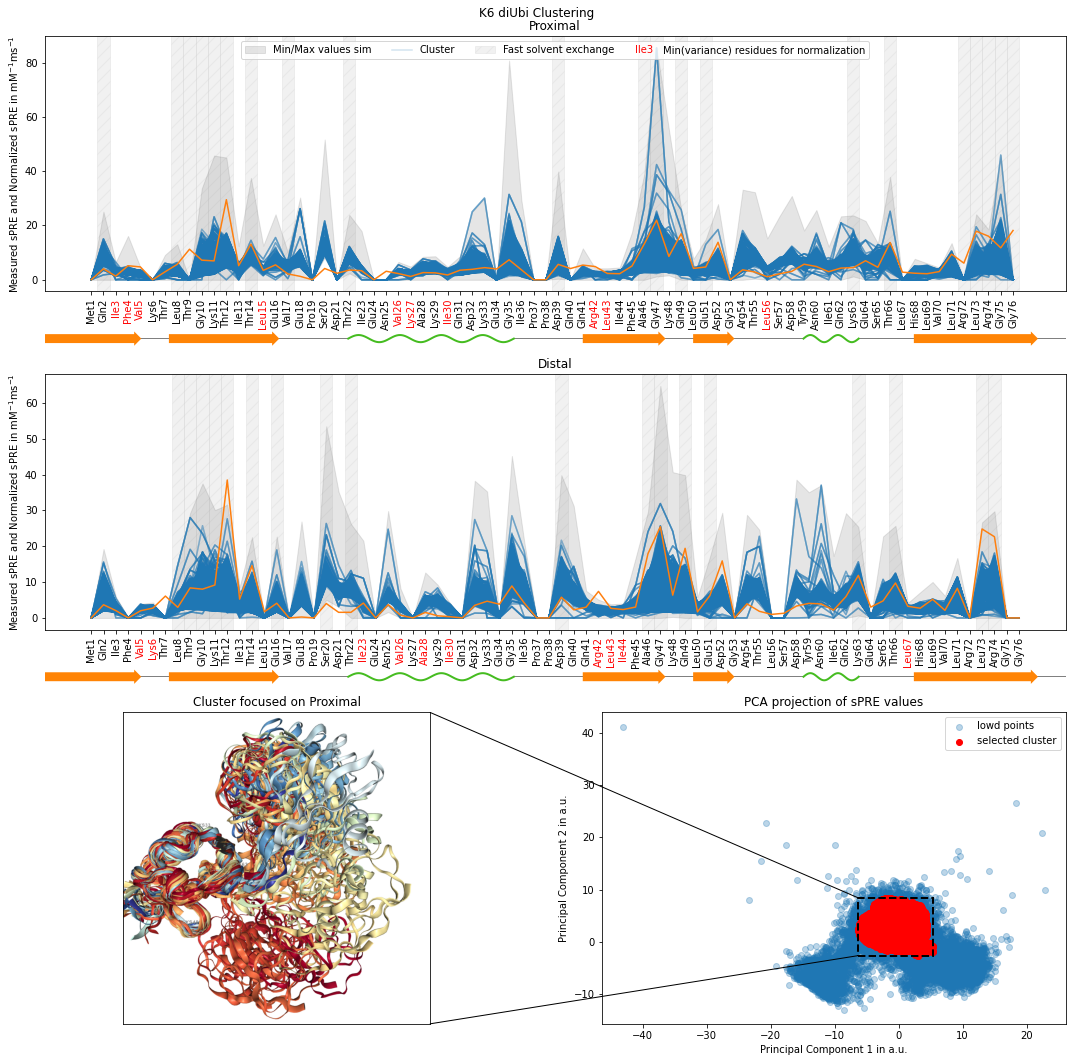

In [151]:
cluster_num = 1

plt.close('all')

fig = plt.figure(figsize=(15, 15), constrained_layout=False)

# cerate gridspecs
gs = fig.add_gridspec(ncols=1, nrows=3)
sub_gs = gs[2, 0].subgridspec(1, 2)

# create axes
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax = fig.add_subplot(sub_gs[0, 0])
ax4 = fig.add_subplot(sub_gs[0, 1])

# names
ax.set_title("Cluster focused on Proximal")
ax1.set_title('Proximal')
ax2.set_title('Distal')
fig.suptitle('K6 diUbi Clustering')

# image
im = plt.imread('k6_cluster_1_prox_focus.png')
ax.imshow(im)
ax.set_xticks([])
ax.set_yticks([])
# [k.set_linewidth(0) for k in ax.spines.values()]

# plots
# fill space between max and min
lbl1 = ax1.fill_between(np.arange(len(prox_max)), prox_max, prox_min, color='grey', alpha=0.2, label='Min/Max values sim')
lbl4 = ax2.fill_between(np.arange(len(dist_max)), dist_max, dist_min, color='grey', alpha=0.2, label='Min/Max values sim')

# plot closest computation
sPRE_norm = pd.read_csv(f'sPRE_{ubq_site}_normalized_via_10_min_variance.csv', index_col=0)
sPRE_ind = [i for i in sPRE_norm.columns if ' ' in i]
prox, dist = np.split(sPRE_norm[sPRE_ind].values, 2, axis=1)
prox_comp, dist_comp = prox[where], dist[where]
for iter_, (i, j) in enumerate(zip(prox_comp, dist_comp)):
    # i[np.nonzero(i)[0]] -= np.min(i[np.nonzero(i)[0]])
    # j[np.nonzero(j)[0]] -= np.min(j[np.nonzero(j)[0]])
    if iter_ == 0:
        lbl2 = ax1.plot(np.arange(len(i)), i, color='C0', label='Cluster', alpha=0.2)
        lbl5 = ax2.plot(np.arange(len(j)), j, color='C0', label='Cluster', alpha=0.2)
    else:
        ax1.plot(np.arange(len(i)), i, color='C0', alpha=0.2)
        ax2.plot(np.arange(len(j)), j, color='C0', alpha=0.2)

# plot measurements
K6_obs_sPRE_all = pd.read_csv(f'full_observables/di_ub2_{ubq_site}_sPRE_aligned_to_full_sequence.csv', index_col=0)
prox_obs, dist_obs = np.split(K6_obs_sPRE_all['sPRE'], 2)
lbl3 = ax1.plot(np.arange(len(prox_obs)), prox_obs, color='C1', label='Measurement')
lbl6 = ax2.plot(np.arange(len(dist_obs)), dist_obs, color='C1', label='Measurement')

# plot scatter
ax4.scatter(*lowd[:,:2].T, c='C0', label='lowd points', alpha=0.3)
ax4.scatter(*lowd[clusterer.labels_ == cluster_num,:2].T, c='red', label='selected cluster')
ax4.set_title('PCA projection of sPRE values')
ax4.set_xlabel('Principal Component 1 in a.u.')
ax4.set_ylabel('Principal Component 2 in a.u.')
ax4.legend()

# a zooming box
lowd_cluster = lowd[clusterer.labels_ == cluster_num,:2]
limits = np.array([lowd_cluster[:,0].min(), lowd_cluster[:,1].min(), np.ptp(lowd_cluster[:,0]), np.ptp(lowd_cluster[:,1])])
roiKwargs = dict([('fill',False), ('linestyle','dashed'), ('color','k'), ('linewidth',2)])
rect = mpl.patches.Rectangle(limits[:2], limits[2], limits[3], **roiKwargs)
ax4.add_patch(rect)
con = mpl.patches.ConnectionPatch(xyA=(rect.get_x(), rect.get_y()), xyB=[1,0], coordsA='data', coordsB='axes fraction', axesA=ax4, axesB=ax, zorder=100)
con.set_color([0, 0, 0])
ax.add_artist(con)
con = mpl.patches.ConnectionPatch(xyA=(rect.get_x(), rect.get_y() + rect.get_height()), xyB=[1,1], coordsA='data', coordsB='axes fraction', axesA=ax4, axesB=ax, zorder=100)
con.set_color([0, 0, 0])
ax.add_artist(con)
ax4.set_zorder(-1)

# set ticks
_ = md.load_pdb('https://files.rcsb.org/view/1UBQ.pdb')
fasta = _.top.to_fasta()[0]
labels = [f"{seq3(f)}{i + 1}" for i, f in enumerate(fasta)]
xticks = np.arange(len(labels))
numElems = 76
idx = np.round(np.linspace(0, len(xticks) - 1, numElems)).astype(int)

# set ticks and sequence elements
for i, ax in enumerate([ax1, ax2, ax1_obs, ax2_obs]):
    ax.set_xticks(xticks[idx])
    ax.set_xticklabels(np.array(labels)[idx], rotation=90)
    if i < 2:
        if split_axes:
            ax.set_ylabel(r"Normalized Calculated sPRE")
            ax.set_xticks(xticks, minor=True)
        else:
            ax.set_ylabel(r'Measured sPRE and Normalized sPRE in $\mathrm{mM^{-1}ms^{-1}}$')
    else:
        ax.set_ylabel(r'Measured sPRE in $\mathrm{mM^{-1}ms^{-1}}$')

    ax_divider = make_axes_locatable(ax)
    # add an axes above the main axes.
    ax_bottom = ax_divider.append_axes("bottom", size="7%", pad="15%")
    graphics.plot_feature_map(
        ax_bottom, ubq_sec_annotation, multi_line=False, loc_range=(1,75),
        # Register our drawing functions
        feature_plotters=[HelixPlotter(), SheetPlotter()]
    )
    ax_bottom.set_zorder(-2)
    
# add fast exhangers as hatched hfill
fast_exchangers = pd.read_csv('fast_exchangers.csv', index_col=0)
for site, ax in zip(['prox', 'dist'], [ax1, ax2]):
    sub_df = fast_exchangers.loc[f"{site}_{ubq_site}"]
    for i, is_fast in enumerate(sub_df):
        if is_fast:
            _ = ax.axvspan(i - 0.5, i + 0.5, alpha=0.3, color='lightgrey', hatch='//', zorder=-5, label='Fast solvent exchange')
    else:
        if ax is ax1:
            lbl_fast_ax1 = _
        else:
            lbl_fast_ax2 = _
            
# color the cneters red
for c in centers_prox:
    ax1.get_xticklabels()[c].set_color("red")
for c in centers_dist - 76:
    ax2.get_xticklabels()[c].set_color("red")
    
# legend
legend_text = AnyObject("Ile3", "red", label='Min(variance) residues for normalization')
lns = [lbl1] + lbl2 + [lbl_fast_ax1] + [legend_text]
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0, ncol=4, handler_map={legend_text:AnyObjectHandler()})
# lns = [lbl3] + lbl4 + [lbl_fast_ax2]
# labs = [l.get_label() for l in lns]
# ax2.legend(lns, labs, loc=0)

plt.tight_layout()

plt.savefig(f'images/di_ub2_{ubq_site}_sPRE_cluster.highq.png', dpi=600, transparent=True)
plt.savefig(f'images/di_ub2_{ubq_site}_sPRE_cluster.png', dpi=300, transparent=False)
plt.savefig(f'images/di_ub2_{ubq_site}_sPRE_cluster.pdf', transparent=True)

## Encodermap with sPRE Values

In [9]:
data = np.hstack([prox, dist])
traj_files = []
top_files = []
basename_func = lambda x: x.split('/')[-2]
for dir_ in glob.glob(f"/home/andrejb/Research/SIMS/2017_04_27_G_2ub_{ubq_site}*"):
    traj_file = dir_ + '/traj_nojump.xtc'
    traj_files.append(traj_file)
    top_file = dir_ + '/start.pdb'
    top_files.append(top_file)
trajs = em.Info_all(traj_files, tops=top_files, common_str=['k6'], basename_fn=basename_func)
trajs = trajs.subsample(5)
trajs.load_CVs(data, 'normalized_sPRE')
trajs.load_CVs(sPRE_df.values, 'calc_sPRE')
print(trajs)

encodermap.Info_all object. Current backend is no_load. Containing 12012 frames. CV calc_sPRE with shape (12012, 152) loaded. CV normalized_sPRE with shape (12012, 152) loaded.


### Highd histo

/home/kevin/.conda/envs/tf2_38/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


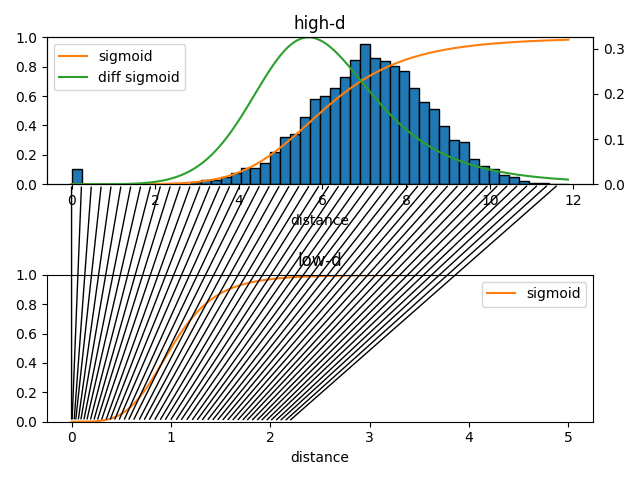

(<AxesSubplot:title={'center':'high-d'}, xlabel='distance'>,
 <AxesSubplot:>,
 <AxesSubplot:title={'center':'low-d'}, xlabel='distance'>)

In [649]:
p = em.Parameters(
main_path = em.misc.run_path('sPRE'),
tensorboard=False,
periodicity=float('inf'),
dist_sig_parameters=(6, 6, 6, 1, 4, 6)
)


em.plot.distance_histogram(trajs.normalized_sPRE[::100], p.periodicity, p.dist_sig_parameters, bins=50)

### Run

In [650]:
e_map = em.EncoderMap(p, trajs.normalized_sPRE)

/home/kevin/.conda/envs/tf2_38/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Output files are saved to sPRE/run4 as defined in 'main_path' in the parameters.


/home/kevin/.conda/envs/tf2_38/lib/python3.8/site-packages/tensorflow/python/training/tracking/data_structures.py:718: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  if not isinstance(wrapped_dict, collections.Mapping):


In [651]:
e_map.train()

/home/kevin/.conda/envs/tf2_38/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/1020 [00:00<?, ?it/s, Loss after epoch ?=?]/home/kevin/.conda/envs/tf2_38/lib/python3.8/site-packages/tensorflow/python/framework/tensor_util.py:523: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()
/home/kevin/.conda/envs/tf2_38/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  if not isinstance(values, collections.Sequence):
100%|██████

/home/kevin/.conda/envs/tf2_38/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


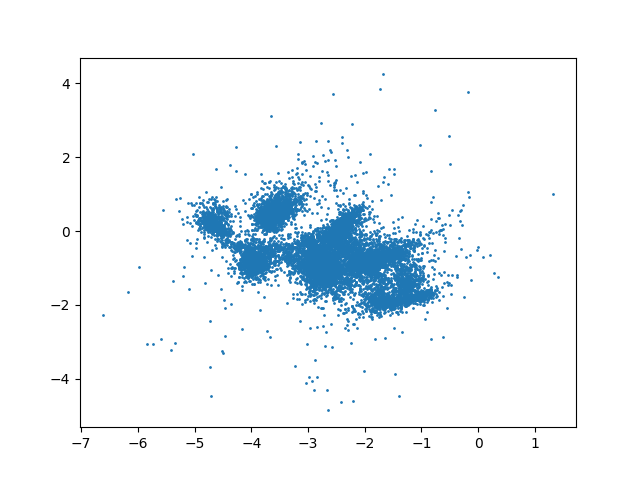

In [688]:
lowd = e_map.encode(trajs.normalized_sPRE)
trajs.load_CVs(lowd, 'lowd')
plt.close('all')
plt.scatter(*trajs.lowd.T, s=1)

### Cluster

/home/kevin/.conda/envs/tf2_38/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/kevin/.conda/envs/tf2_38/lib/python3.8/site-packages/hdbscan/hdbscan_.py:275: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  alg = KDTreeBoruvkaAlgorithm(tree, min_samples, metric=metric,
/home/kevin/.conda/envs/tf2_38/lib/python3.8/site-packages/hdbscan/hdbscan_.py:56: DeprecationWarning: `np.i

<IPython.core.display.Javascript object>


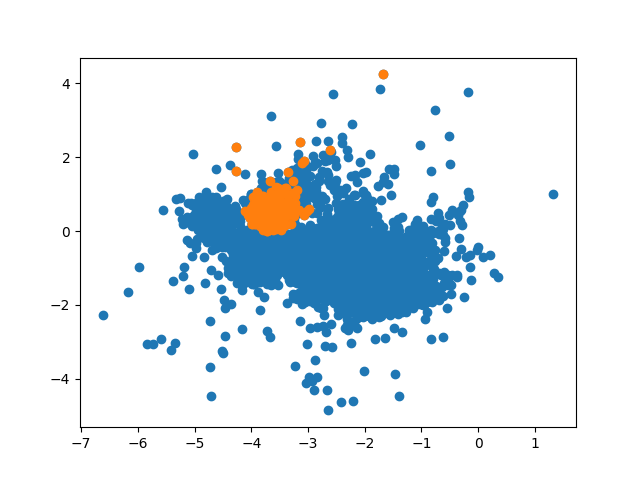

In [689]:
emap_clusterer = hdbscan.HDBSCAN(min_cluster_size=20, cluster_selection_method='leaf').fit(trajs.lowd)
trajs.load_CVs(emap_clusterer.labels_, 'cluster_membership')

plt.close('all')
plt.scatter(*trajs.lowd[:,:2].T)
plt.scatter(*trajs.lowd[clusterer.labels_ == 0,:2].T)

In [692]:
trajs[0]._CVs

<xarray.Dataset>
Dimensions:             (CALC_SPRE: 152, LOWD: 2, NORMALIZED_SPRE: 152, frame_no: 1001, traj_num: 1)
Coordinates:
  * traj_num            (traj_num) int64 0
    traj_name           (traj_num) <U25 '2017_04_27_G_2ub_k6_01_01'
  * frame_no            (frame_no) int64 0 5 10 15 20 ... 4985 4990 4995 5000
  * NORMALIZED_SPRE     (NORMALIZED_SPRE) <U27 'NORMALIZED_SPRE FEATURE 0' .....
    time                (frame_no) float32 0.0 50.0 100.0 ... 49950.0 50000.0
  * CALC_SPRE           (CALC_SPRE) <U21 'CALC_SPRE FEATURE 0' ... 'CALC_SPRE...
  * LOWD                (LOWD) <U14 'LOWD FEATURE 0' 'LOWD FEATURE 1'
    CLUSTER_MEMBERSHIP  (frame_no) <U31 'CLUSTER_MEMBERSHIP FEATURE 0' ... 'C...
Data variables:
    normalized_sPRE     (traj_num, frame_no, NORMALIZED_SPRE) float64 0.0 ......
    calc_sPRE           (traj_num, frame_no, CALC_SPRE) float64 0.0 ... 0.0
    lowd                (traj_num, frame_no, LOWD) float32 -2.9144857 ... -0....
    cluster_membership  (traj_num, frame_no) int64 -1 -1 -1 -1 ... 21 -1 21 -1

In [690]:
view, _ = em.misc.clustering.gen_dummy_traj(trajs, 0, superpose=True, shorten=True, stack_atoms=True)

/home/kevin/.conda/envs/tf2_38/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


3367


IndexError: index 1820 is out of bounds for axis 0 with size 1001

In [ ]:
view

## Encodermap with structural Data

In [160]:
ubq_site = 'k6'
traj_files = []
top_files = []
basename_func = lambda x: x.split('/')[-2]
for dir_ in glob.glob(f"/home/andrejb/Research/SIMS/2017_04_27_G_2ub_{ubq_site}*"):
    traj_file = dir_ + '/traj_nojump.xtc'
    traj_files.append(traj_file)
    top_file = dir_ + '/start.pdb'
    top_files.append(top_file)
trajs = em.Info_all(traj_files, tops=top_files, common_str=['k6'], basename_fn=basename_func)

/home/kevin/.conda/envs/tf2_38/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [161]:
feat = em.Featurizer(trajs)
feat.add_distances_ca(excluded_neighbors=2)
trajs.load_CVs(feat)
# trajs._CVs.to_netcdf(f'CA_distances_{ubq_site}.nc', format='NETCDF4', engine='h5netcdf')

/home/kevin/.conda/envs/tf2_38/lib/python3.8/site-packages/pyemma/coordinates/data/featurization/featurizer.py:240: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pair_inds = np.array(pair_inds).astype(dtype=np.int, casting='safe')


**RWMD**

In [162]:
from scipy.spatial.distance import cdist

In [163]:
for traj in trajs:
    CA = traj.select('name CA')
    CA1, CA2 = np.split(CA, 2)
    dists1 = np.vstack([np.min(cdist(traj.xyz[i, CA1], traj.xyz[i, CA2]), axis=1) for i in range(traj.n_frames)])
    dists2 = np.vstack([np.min(cdist(traj.xyz[i, CA2], traj.xyz[i, CA1]), axis=1) for i in range(traj.n_frames)])
    dists = np.hstack([dists1, dists2])
    traj.load_CV(dists, attr_name='rwmd')

In [22]:
trajs.rwmd.shape

(60012, 152)

<IPython.core.display.Javascript object>


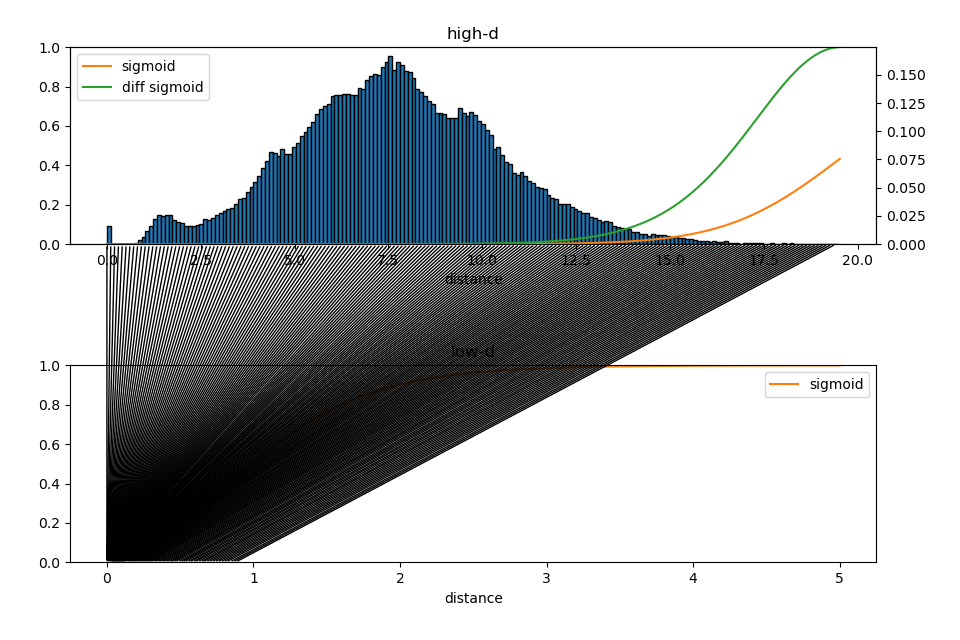

(<AxesSubplot:title={'center':'high-d'}, xlabel='distance'>,
 <AxesSubplot:label='1b97b7cf-77c8-4a6e-9dcf-6ab111647830'>,
 <AxesSubplot:title={'center':'low-d'}, xlabel='distance'>)

In [23]:
em.plot.distance_histogram(trajs.rwmd[::100], float("inf"), (20, 12, 10, 1, 2, 10))

In [159]:
p = em.Parameters(
    dist_sig_parameters = (20, 12, 10, 1, 2, 10),
    periodicity = float("inf"),
    checkpoint_step = 100,
    main_path = em.misc.run_path('RMWD/'),
    n_neurons = [300, 300, 300, 2],
    activation_functions = ['', 'tanh', 'tanh', 'tanh', ''],
    tensorboard = True,
    learning_rate = 0.0001
)
CA_e_map = em.EncoderMap(p, trajs.rwmd)
CA_e_map.add_images_to_tensorboard(trajs.rwmd[::25])

Also disabling gmx quotes
sourcing /home/soft/gromacs/gromacs-2021.1/inst/cuda_shared_20.04/bin/GMXRC.bash ...


AttributeError: 'Info_all' object has no attribute 'rwmd'

In [ ]:
# CA_e_map.train()

In [164]:
for traj in trajs:
    lowd_file = f'AA_and_CG_pairwise_distances/{traj.basename}.npy'
    traj.load_CV(lowd_file, 'lowd')

In [165]:
trajs.lowd.shape

(60012, 5)

/home/kevin/.conda/envs/tf2_38/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/kevin/.conda/envs/tf2_38/lib/python3.8/site-packages/pyemma/plots/plots2d.py:651: DeprecationWarning: Legacy mode is deprecated is will be removed in the next major release. Until then use legacy=False
  _warn(
/home/kevin/.conda/envs/tf2_38/lib/python3.8/site-packages/pyemma/plots/plots2d.py:651: DeprecationWarning: Legacy mode is deprecated is will be removed in the next major release. Until then use legacy=False
  _warn(
/home/kevin/.conda/envs/tf2_38/lib/python3.8/site-packages/pyemma/plots/plots2d.py:651: DeprecationWarning: Legacy mode is deprecated is will be removed in the next major release. Until then u

Text(0.5, 1.0, 'dimensions 4 and 5')

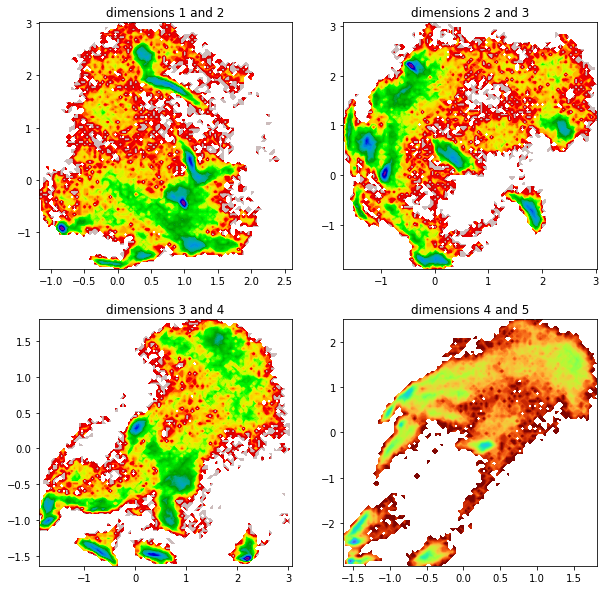

In [187]:
%matplotlib inline
plt.close('all')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
pyemma.plots.plot_free_energy(*trajs.lowd[:,0:2].T, ax=ax1, cbar=False)
ax1.set_title('dimensions 1 and 2')
pyemma.plots.plot_free_energy(*trajs.lowd[:,1:3].T, ax=ax2, cbar=False)
ax2.set_title('dimensions 2 and 3')
pyemma.plots.plot_free_energy(*trajs.lowd[:,2:4].T, ax=ax3, cbar=False)
ax3.set_title('dimensions 3 and 4')
pyemma.plots.plot_free_energy(*trajs.lowd[:,3:5].T, ax=ax4, cbar=False, cmap='turbo')
ax4.set_title('dimensions 4 and 5')

/home/kevin/.conda/envs/tf2_38/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/kevin/.conda/envs/tf2_38/lib/python3.8/site-packages/pyemma/plots/plots2d.py:651: DeprecationWarning: Legacy mode is deprecated is will be removed in the next major release. Until then use legacy=False
  _warn(


(<Figure size 720x720 with 2 Axes>, <AxesSubplot:>)

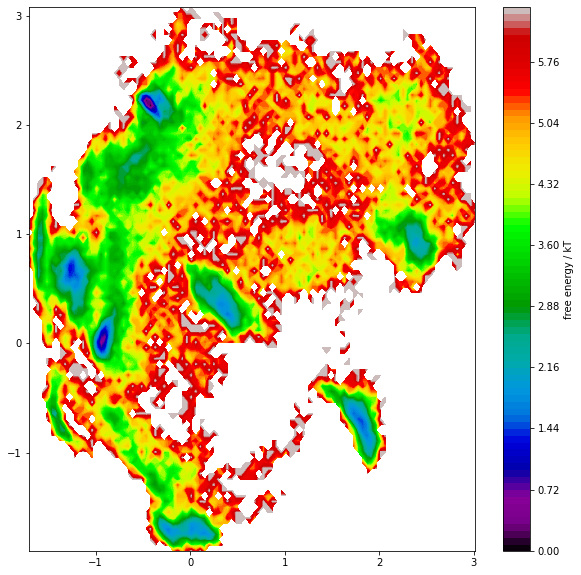

In [186]:
fig, ax = plt.subplots(figsize=(10, 10))

pyemma.plots.plot_free_energy(*trajs.lowd[:,1:3].T, ax=ax, nbins=100)

/home/kevin/.conda/envs/tf2_38/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/kevin/.conda/envs/tf2_38/lib/python3.8/site-packages/hdbscan/hdbscan_.py:275: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  alg = KDTreeBoruvkaAlgorithm(tree, min_samples, metric=metric,
/home/kevin/.conda/envs/tf2_38/lib/python3.8/site-packages/hdbscan/hdbscan_.py:56: DeprecationWarning: `np.i

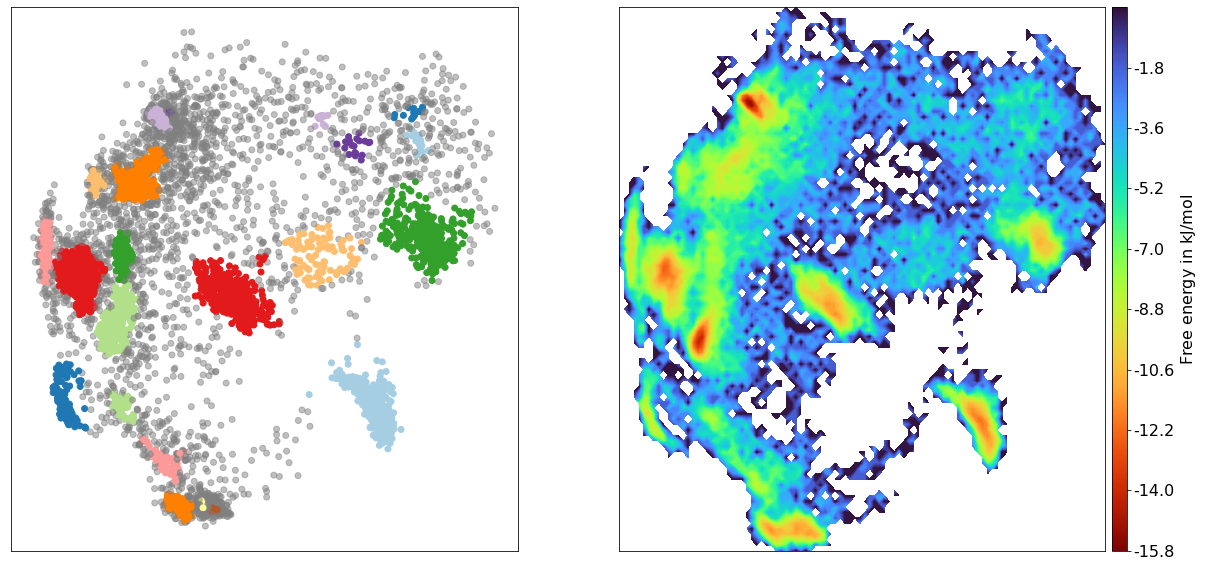

In [206]:
plt.close('all')

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(1, 2, 1)
ax = fig.add_subplot(1, 2, 2)

x, y = trajs.lowd[:,1:3].T
H, xedges, yedges = np.histogram2d(x=x, y=y, bins=100)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]] 
xcenters = np.mean(np.vstack([xedges[0:-1], xedges[1:]]), axis=0)
ycenters = np.mean(np.vstack([yedges[0:-1], yedges[1:]]), axis=0)
X, Y = np.meshgrid(xcenters, ycenters)
kT = 2.479 # kJ / mol
# kT = 1.0 # kbT
F = pyemma.plots.plots2d._to_free_energy(H, minener_zero=True) * kT
F[~np.isinf(F)] = F[~np.isinf(F)] - F[~np.isinf(F)].max() # reverse
mappable = ax.contourf(xcenters, ycenters, F.T, 100, norm=None, vmin=None, vmax=None, cmap='turbo_r', levels=None)

# colormap
norm = mpl.colors.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap='turbo_r', norm=norm)
sm.set_array([])
mappable_values = np.unique(mappable.get_array())
no_ticks = 10
if len(mappable_values) < 10:
    cmap_ticks = np.linspace(0, 1, len(mappable_values))
else:
    cmap_ticks = np.linspace(0, 1, no_ticks)
divider = make_axes_locatable(ax)
free_energy_axis_cax = divider.append_axes("right", size=0.2, pad=0.1)#, sharey=ax1)
# remove inf tick
cmap_ticks = cmap_ticks[:-1]
cb = plt.colorbar(sm, cax=free_energy_axis_cax, ticks=cmap_ticks)
idx = np.round(np.linspace(0, len(mappable_values) - 1, len(cmap_ticks) + 1)).astype(int)[:-1]
yticklabels = cb.ax.set_yticklabels(np.round(mappable_values[idx].astype(float), decimals=1), fontsize=16)

free_energy_axis_cax.set_ylabel(r'Free energy in $\mathrm{kJ/mol}$', fontsize=16)
ax.set_xticks([])
ax.set_yticks([])

clusterer = hdbscan.HDBSCAN(min_cluster_size=100, cluster_selection_method='leaf').fit(trajs.lowd[:,1:3])
color_palette = sns.color_palette('Paired', clusterer.labels_.max() + 1)
cluster_colors = [(*color_palette[x], 1.0) if x >= 0
                  else (0.5, 0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]

ax1.scatter(*trajs.lowd[::10,1:3].T, c=cluster_colors[::10])
ax1.set_xticks([])
ax1.set_yticks([])

plt.savefig("/home/kevin/projects/nice_images/ubq_internships/lowd_free_energy_and_clustering.png")

### Cluster them

In [194]:
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=100, cluster_selection_method='leaf').fit(trajs.lowd)
print(np.unique(clusterer.labels_))

/home/kevin/.conda/envs/tf2_38/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/kevin/.conda/envs/tf2_38/lib/python3.8/site-packages/hdbscan/hdbscan_.py:275: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  alg = KDTreeBoruvkaAlgorithm(tree, min_samples, metric=metric,


[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26]


/home/kevin/.conda/envs/tf2_38/lib/python3.8/site-packages/hdbscan/hdbscan_.py:56: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  condensed_tree = condense_tree(single_linkage_tree,
/home/kevin/.conda/envs/tf2_38/lib/python3.8/site-packages/hdbscan/hdbscan_.py:59: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more detail

### Render

In [142]:
trajs.load_CVs(clusterer.labels_, 'cluster_membership')

/home/kevin/.conda/envs/tf2_38/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [54]:
view = ngl.widget.NGLWidget(gui=True)

side = 'proximal'

if side == 'distal':
    _, dummy_traj = em.misc.clustering.gen_dummy_traj(trajs, 0, stack_atoms=True, nglview=True, superpose=True, max_frames=40, align_string='name CA and resid <= 75')
    com_proximal = np.mean(md.compute_center_of_geometry(dummy_traj.atom_slice(dummy_traj.top.select('resid <= 75'))), axis=0) * 10
    com_distal = np.mean(md.compute_center_of_geometry(dummy_traj.atom_slice(dummy_traj.top.select('resid > 75'))), axis=0) * 10

    view.shape.add_sphere(com_proximal.tolist(), [0, 0, 1], 15)
    selection = dummy_traj.top.select('resid <= 75 and resname LYS')
    for N in dummy_traj.top.select('resid <= 75 and resname LYS and name CA')[:7]:
        pos = (dummy_traj.xyz[0,N] * 10).tolist()
        name = str(dummy_traj.top.atom(N).residue)
        view.shape.add('text', pos, [0.5, 0.5, 0.5], 3, name)
elif side == 'proximal':
    _, dummy_traj = em.misc.clustering.gen_dummy_traj(trajs, 0, stack_atoms=True, nglview=True, superpose=True, max_frames=40, align_string='name CA and resid > 75')
    com_proximal = np.mean(md.compute_center_of_geometry(dummy_traj.atom_slice(dummy_traj.top.select('resid <= 75'))), axis=0) * 10
    com_distal = np.mean(md.compute_center_of_geometry(dummy_traj.atom_slice(dummy_traj.top.select('resid > 75'))), axis=0) * 10

    # view.shape.add_sphere(com_distal.tolist(), [0.5, 0.5, 0.5], 15)
    selection = dummy_traj.top.select('resid > 75 and resname LYS')
    for N in dummy_traj.top.select('resid > 75 and resname LYS and name CA')[:7]:
        pos = (dummy_traj.xyz[0,N] * 10).tolist()
        name = str(dummy_traj.top.atom(N).residue)
        view.shape.add('text', pos, [0.5, 0.5, 0.5], 3, name)
    N = dummy_traj.top.select('resid > 75 and resname GLQ and name CA')[0]
    pos = (dummy_traj.xyz[0,N] * 10).tolist()
    name = str(dummy_traj.top.atom(N).residue)
    view.shape.add('text', pos, [0.5, 0.5, 0.5], 3, name)
view.add_trajectory(dummy_traj)
# view.add_representation('ball+stick', selection=selection)
# view.update_representation(component=0, repr_index=0, opacity=0.2)
view

Provided alignment string results in 76 atoms. First atom is MET1-CA. Last atom is GLY76-CA.


NGLWidget()

/home/kevin/.conda/envs/tf2_38/lib/python3.8/site-packages/ipywidgets/widgets/widget_button.py:70: DeprecationWarning: icons names no longer start with 'fa-', just use the class name itself (for example, 'check' instead of 'fa-check')
  warnings.warn("icons names no longer start with 'fa-', "


In [73]:
where = np.where(clusterer.labels_ == 0)[0]
for w in where:
    # get the frame to compare to sPRE
    frame = trajs.get_single_frame(w)
    # find this frame in sPRE_norm
    traj_file = sPRE_norm['traj_file'] == frame.traj_file
    frame_no = sPRE_norm['time'] == frame.time[0]
    where_in_df = (traj_file & frame_no)
    if not any(where_in_df):
        continue
    else:
        i, j = np.split(sPRE_norm[sPRE_ind].values[where_in_df][0], 2)

/home/kevin/.conda/envs/tf2_38/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_01_04/traj_nojump.xtc  1822
/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_01_04/traj_nojump.xtc  1823
/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_01_04/traj_nojump.xtc  1824
/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_01_04/traj_nojump.xtc  1825
found
(76,) (76,)


Exception: STOP

### Plot

IndexError: boolean index did not match indexed array along dimension 0; dimension is 12012 but corresponding boolean dimension is 60012

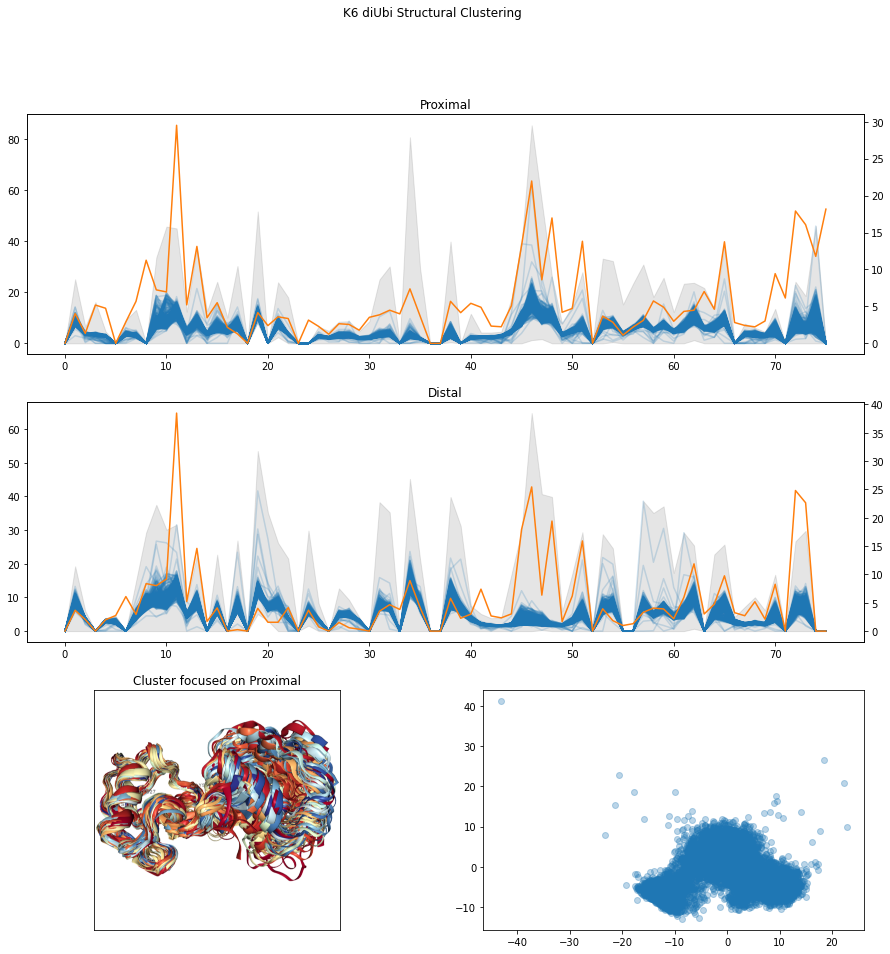

In [143]:
cluster_num = 1
from Bio.SeqUtils import seq3
plt.close('all')

fig = plt.figure(figsize=(15, 15), constrained_layout=False)

# cerate gridspecs
gs = fig.add_gridspec(ncols=1, nrows=3)
sub_gs = gs[2, 0].subgridspec(1, 2)

# create axes
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax = fig.add_subplot(sub_gs[0, 0])
ax4 = fig.add_subplot(sub_gs[0, 1])

# names
ax.set_title("Cluster focused on Proximal")
ax1.set_title('Proximal')
ax2.set_title('Distal')
fig.suptitle('K6 diUbi Structural Clustering')

# image
im = plt.imread('k6_struct_cluster_0_prox_focus.png')
ax.imshow(im)
ax.set_xticks([])
ax.set_yticks([])
# [k.set_linewidth(0) for k in ax.spines.values()]

# plots
# fill space between max and min
lbl1 = ax1.fill_between(np.arange(len(prox_max)), prox_max, prox_min, color='grey', alpha=0.2, label='Min/Max values sim')
lbl4 = ax2.fill_between(np.arange(len(dist_max)), dist_max, dist_min, color='grey', alpha=0.2, label='Min/Max values sim')

# plot closest computation
sPRE_norm = pd.read_csv(f'sPRE_{ubq_site}_normalized_via_10_min_variance.csv', index_col=0)
sPRE_ind = [i for i in sPRE_norm.columns if ' ' in i]
prox, dist = np.split(sPRE_norm[sPRE_ind].values, 2, axis=1)

where = np.where(clusterer.labels_ == 0)[0]
iter_ = 0
for w in where:
    # get the frame to compare to sPRE
    frame = trajs.get_single_frame(w)
    # find this frame in sPRE_norm
    traj_file = sPRE_norm['traj_file'] == frame.traj_file
    frame_no = sPRE_norm['time'] == frame.time[0]
    where_in_df = (traj_file & frame_no)
    if not any(where_in_df):
        continue
    i, j = np.split(sPRE_norm[sPRE_ind].values[where_in_df][0], 2)
    if iter_ == 0:
        lbl2 = ax1.plot(np.arange(len(i)), i, color='C0', label='Cluster', alpha=0.2)
        lbl5 = ax2.plot(np.arange(len(j)), j, color='C0', label='Cluster', alpha=0.2)
    else:
        ax1.plot(np.arange(len(i)), i, color='C0', alpha=0.2)
        ax2.plot(np.arange(len(j)), j, color='C0', alpha=0.2)
    iter_ += 1

# plot measurements
K6_obs_sPRE_all = pd.read_csv(f'full_observables/di_ub2_{ubq_site}_sPRE_aligned_to_full_sequence.csv', index_col=0)
prox_obs, dist_obs = np.split(K6_obs_sPRE_all['sPRE'], 2)
lbl3 = ax1.plot(np.arange(len(prox_obs)), prox_obs, color='C1', label='Measurement')
lbl6 = ax2.plot(np.arange(len(dist_obs)), dist_obs, color='C1', label='Measurement')

# plot scatter
# ax4.scatter(*lowd[:,:2].T, c='C0', label='lowd points', alpha=0.3)
pyemma.plots.plot_free_energy(*trajs.lowd[:,1:3].T, ax=ax2, cbar=False)
# ax4.scatter(*lowd[clusterer.labels_ == cluster_num,:2].T, c='red', label='selected cluster')
ax4.set_title('Encodermap values')
ax4.set_xlabel('Principal Component 1 in a.u.')
ax4.set_ylabel('Principal Component 2 in a.u.')
ax4.legend()

# legend
lns = [lbl1] + lbl2 + lbl3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)
lns = [lbl4] + lbl5 + lbl6
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc=0)

# set ticks
_ = md.load_pdb('https://files.rcsb.org/view/1UBQ.pdb')
fasta = _.top.to_fasta()[0]
labels = [f"{seq3(f)}{i + 1}" for i, f in enumerate(fasta)]
xticks = np.arange(len(labels))
numElems = 76
idx = np.round(np.linspace(0, len(xticks) - 1, numElems)).astype(int)

# a zooming box
lowd_cluster = lowd[clusterer.labels_ == cluster_num,:2]
limits = np.array([lowd_cluster[:,0].min(), lowd_cluster[:,1].min(), np.ptp(lowd_cluster[:,0]), np.ptp(lowd_cluster[:,1])])
roiKwargs = dict([('fill',False), ('linestyle','dashed'), ('color','k'), ('linewidth',2)])
rect = mpl.patches.Rectangle(limits[:2], limits[2], limits[3], **roiKwargs)
ax4.add_patch(rect)
con = mpl.patches.ConnectionPatch(xyA=(rect.get_x(), rect.get_y()), xyB=[1,0], coordsA='data', coordsB='axes fraction', axesA=ax4, axesB=ax, zorder=100)
con.set_color([0, 0, 0])
ax.add_artist(con)
con = mpl.patches.ConnectionPatch(xyA=(rect.get_x(), rect.get_y() + rect.get_height()), xyB=[1,1], coordsA='data', coordsB='axes fraction', axesA=ax4, axesB=ax, zorder=100)
con.set_color([0, 0, 0])
ax.add_artist(con)
ax4.set_zorder(-1)

# set ticks and sequence elements
for i, ax in enumerate([ax1, ax2, ax1_obs, ax2_obs]):
    ax.set_xticks(xticks[idx])
    ax.set_xticklabels(np.array(labels)[idx], rotation=90)
    if i < 2:
        if split_axes:
            ax.set_ylabel(r"Normalized Calculated sPRE")
            ax.set_xticks(xticks, minor=True)
        else:
            ax.set_ylabel(r'Measured sPRE and Normalized sPRE in $\mathrm{mM^{-1}ms^{-1}}$')
    else:
        ax.set_ylabel(r'Measured sPRE in $\mathrm{mM^{-1}ms^{-1}}$')

    ax_divider = make_axes_locatable(ax)
    # add an axes above the main axes.
    ax_bottom = ax_divider.append_axes("bottom", size="7%", pad="15%")
    graphics.plot_feature_map(
        ax_bottom, ubq_sec_annotation, multi_line=False, loc_range=(1,75),
        # Register our drawing functions
        feature_plotters=[HelixPlotter(), SheetPlotter()]
    )
    ax_bottom.set_zorder(-2)
    
# add fast exhangers as hatched hfill
fast_exchangers = pd.read_csv('fast_exchangers.csv', index_col=0)
for site, ax in zip(['prox', 'dist'], [ax1, ax2]):
    sub_df = fast_exchangers.loc[f"{site}_{ubq_site}"]
    for i, is_fast in enumerate(sub_df):
        if is_fast:
            _ = ax.axvspan(i - 0.5, i + 0.5, alpha=0.3, color='lightgrey', hatch='//', zorder=-5, label='Fast solvent exchange')
    else:
        if ax is ax1:
            lbl_fast_ax1 = _
        else:
            lbl_fast_ax2 = _
            
# color the cneters red
for c in centers_prox:
    ax1.get_xticklabels()[c].set_color("red")
for c in centers_dist - 76:
    ax2.get_xticklabels()[c].set_color("red")
    
# legend
legend_text = AnyObject("Ile3", "red", label='Min(variance) residues for normalization')
lns = [lbl1] + lbl2 + [lbl_fast_ax1] + [legend_text]
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0, ncol=4, handler_map={legend_text:AnyObjectHandler()})
# lns = [lbl3] + lbl4 + [lbl_fast_ax2]
# labs = [l.get_label() for l in lns]
# ax2.legend(lns, labs, loc=0)

plt.tight_layout()

# plt.savefig(f'images/di_ub2_{ubq_site}_structure_cluster.highq.png', dpi=600, transparent=True)
# plt.savefig(f'images/di_ub2_{ubq_site}_structure_cluster.png', dpi=300, transparent=False)
# plt.savefigf(f'images/di_ub2_{ubq_site}_structure_cluster.pdf', transparent=True)

## linear combination of clusters

In [80]:
# iterate over clusters and get mean cluster_sPRE
sPRE_norm = pd.read_csv(f'sPRE_{ubq_site}_normalized_via_10_min_variance.csv', index_col=0)
sPRE_ind = [i for i in sPRE_norm.columns if ' ' in i]
# cluster_membership_sPRE = np.full(sPRE_norm[sPRE_ind].values.shape, -1)
print(sPRE_norm[sPRE_ind].shape)
cluster_membership_sPRE = []

for traj in trajs:
    cluster_membership_sPRE.append(traj.cluster_membership[::5])
cluster_membership_sPRE = np.hstack(cluster_membership_sPRE)
sPRE_norm['cluster_membership'] = cluster_membership_sPRE

(12012, 152)


In [86]:
cluster_means = []

for cluster_num in range(int(sPRE_norm['cluster_membership'].max())):
    mean = np.mean(sPRE_norm[sPRE_ind][sPRE_norm['cluster_membership'] == cluster_num], axis=0)
    cluster_means.append(mean)
cluster_means = np.vstack(cluster_means)
print(cluster_means.shape)

(26, 152)


/home/kevin/.conda/envs/tf2_38/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [90]:
sPRE_obs = pd.read_csv(f'full_observables/di_ub2_{ubq_site}_sPRE_aligned_to_full_sequence.csv', index_col=0)
sPRE_obs['primary sequence'] = sPRE_obs['primary sequence'].str.upper()
sPRE_obs = sPRE_obs.set_index('primary sequence')
sPRE_obs.index = column_names
sPRE_obs['sPRE'].values

/home/kevin/.conda/envs/tf2_38/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(152,)

In [92]:
import scipy

In [ ]:
fast_exchangers = pd.read_csv('fast_exchangers.csv', index_col=0)

ubq_site = 'k6'
fast_exchange = np.hstack(fast_exchangers.loc[[i for i in fast_exchangers.index if ubq_site in i]].values)
fast_exchange.shape

In [121]:
x = scipy.optimize.lsq_linear(cluster_means.T[~fast_exchange], sPRE_obs['sPRE'].values[~fast_exchange], bounds=(0, 1))

In [155]:
argsort = np.argsort(x.x)[::-1]
print(argsort)
print(x.x[argsort])

/home/kevin/.conda/envs/tf2_38/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[ 9 11 22 10  1  0 16  8 12 13 14 25 21  5 24 23  7 18 20 17  2  4  3 15
  6 19]
[4.57326283e-01 1.53276841e-01 5.32812736e-02 3.10287049e-17
 3.16759074e-20 2.74138067e-20 5.64230397e-21 9.70679586e-22
 4.38690333e-22 1.62729787e-22 4.21404952e-23 4.07667949e-23
 3.63632928e-23 2.87200408e-23 2.77122466e-23 9.56578926e-24
 7.11155010e-24 5.08399485e-24 4.41865290e-24 2.02814117e-24
 1.29084019e-24 7.19543796e-25 3.12405860e-25 7.87913440e-26
 7.40555770e-27 1.64573685e-30]


In [132]:
cluster_nums = []

for i in argsort[:3]:
    cluster_nums.append(i)

## Matploltib animation

<IPython.core.display.Javascript object>


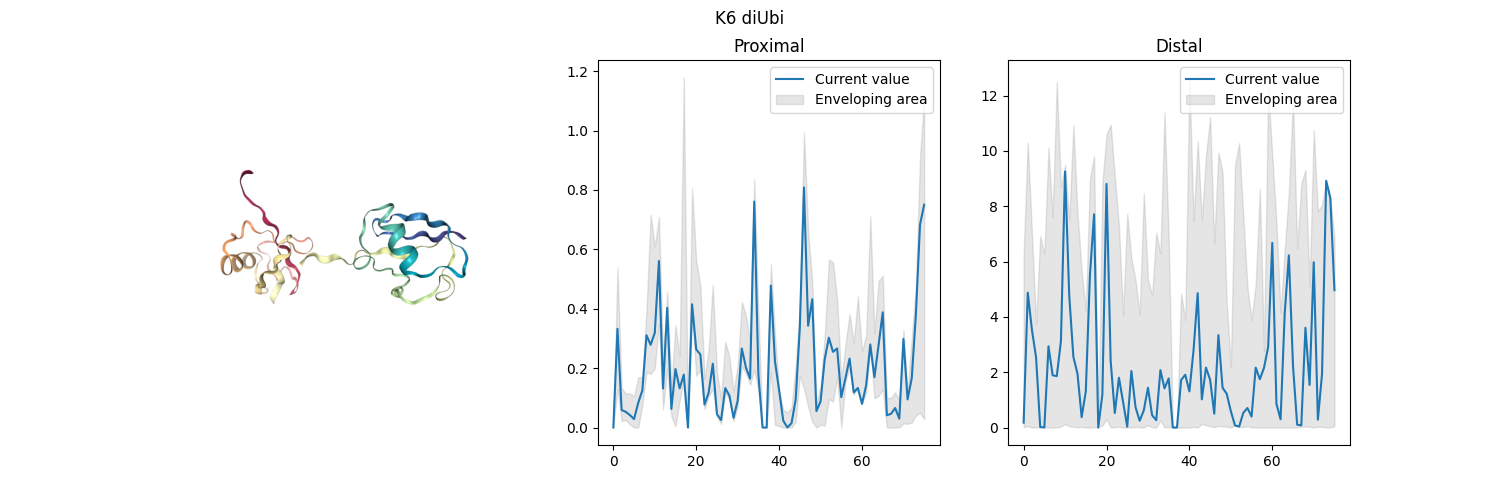

In [33]:
from matplotlib.animation import FuncAnimation

fig, (ax, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 5))

ax1.set_title('Proximal')
ax2.set_title('Distal')
fig.suptitle('K6 diUbi')

# plots
# fill space between max and min
ax1.fill_between(np.arange(len(prox_max)), prox_max, prox_min, color='grey', alpha=0.2, label='Enveloping area')
ax2.fill_between(np.arange(len(dist_max)), dist_max, dist_min, color='grey', alpha=0.2, label='Enveloping area')
# plot the lines
ln1, = ax1.plot([], [], c='C0', label='Current value')
ln2, = ax2.plot([], [], c='C0', label='Current value')
# turn on legends
ax1.legend()
ax2.legend()
ax.set_xticks([])
ax.set_yticks([])
[k.set_linewidth(0) for k in ax.spines.values()]

image = plt.imread('values_from_every_frame/render/Screenshot0.png')
im_shape = image.shape
white_image = np.full(im_shape, 1)
im = ax.imshow(image, animated=True)

def init():
    im.set_array(image)
    return ln1, ln2, im,

def frame_generator():
    for i, file in enumerate(glob.glob('values_from_every_frame/render/Screenshot*.png')):
        yield i, file

def update(frame):
    xdata = np.arange(len(prox[frame]))
    ydata = prox[frame]
    ln1.set_data(xdata, ydata)
    xdata = np.arange(len(dist[frame]))
    ydata = dist[frame]
    ln2.set_data(xdata, ydata)
    new_im = plt.imread(f'values_from_every_frame/render/Screenshot{i}.png')
    im.set_array(new_im)
    return ln1, ln2, im,

ani = FuncAnimation(fig, update, frames=np.arange(prox.shape[0]),
                    init_func=init, blit=True, interval=500)
plt.show()

<IPython.core.display.Javascript object>


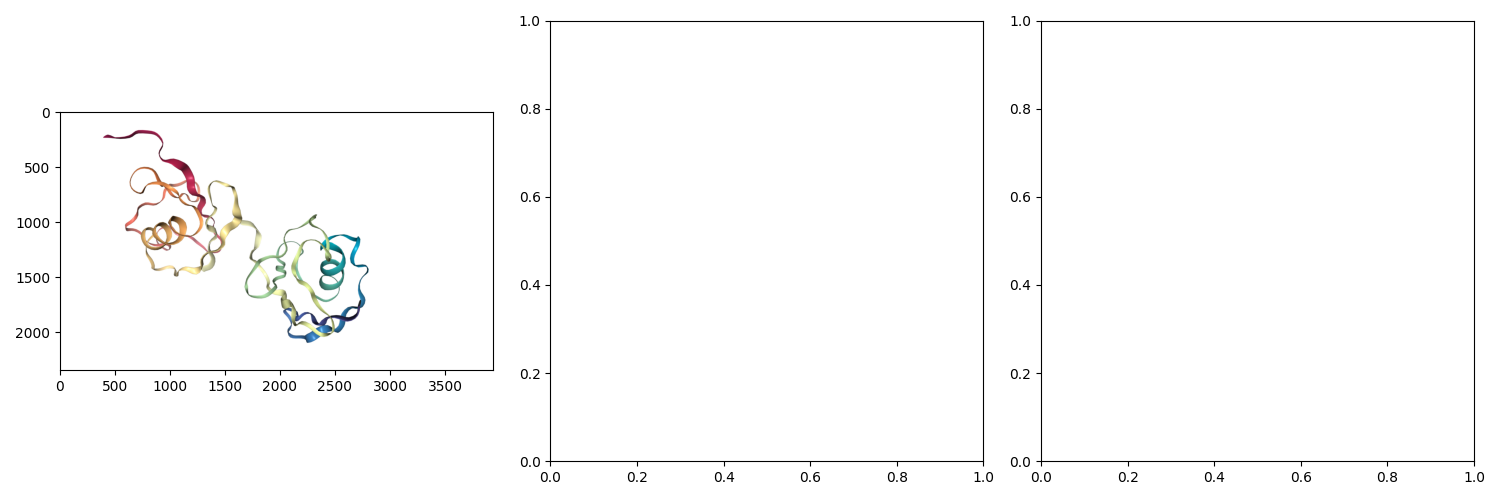

In [34]:
import matplotlib.animation as animation

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 5))
im_shape = plt.imread('values_from_every_frame/render/Screenshot0.png').shape
white_image = np.full(im_shape, 1)
im = ax1.imshow(white_image, animated=True)

def init():
    im.set_array(white_image)
    return im,

def frame_generator():
    for i, file in enumerate(glob.glob('values_from_every_frame/render/Screenshot*.png')):
        yield file

def updatefig(image_file):
    new_im = plt.imread(image_file)
    im.set_array(new_im)
    return im,

ani = animation.FuncAnimation(fig, updatefig, frame_generator, init_func=init, interval=50, blit=True)
plt.tight_layout()
plt.show()

# Normalization example

Mock some data. For Prolines, there is no sPRE, because protons are missing.

In [25]:
data = np.array([
    [0, 5, 0, 3, 0],
    [0, 3, 0, 2, 0],
    [0, 1, 0, 4, 0],
    [0, 8, 0, 2, 0]
])
residues = ['MET1', 'GLY2', 'PRO3', 'LYS4', 'PRO5']
indices = [f'Frame {i} of MD sim' for i in range(4)]
df = pd.DataFrame(data, columns=residues, index=indices)
df

MET1  GLY2  PRO3  LYS4  PRO5
Frame 0 of MD sim     0     5     0     3     0
Frame 1 of MD sim     0     3     0     2     0
Frame 2 of MD sim     0     1     0     4     0
Frame 3 of MD sim     0     8     0     2     0

Get the non-zero residue with the smallest min and max values

Expected output: `[3, 2, 1, 2]`

In [19]:
norm_sub = np.min(np.where(data==0, data.max(), data), axis=1)
norm_sub

array([3, 2, 1, 2])

This subtrahend will be subtracted from every non-zero values on a row-wise basis.

Expected output:

```
[0, 2, 0, 0, 0]
[0, 1, 0, 0, 0]
[0, 0, 0, 3, 0]
[0, 6, 0, 0, 0]
```

In [27]:
normalized_data = (data.T - norm_sub).T
normalized_data[np.where(data == 0)] = 0.
df = pd.DataFrame(normalized_data, columns=residues, index=indices)
df

MET1  GLY2  PRO3  LYS4  PRO5
Frame 0 of MD sim     0     2     0     0     0
Frame 1 of MD sim     0     1     0     0     0
Frame 2 of MD sim     0     0     0     3     0
Frame 3 of MD sim     0     6     0     0     0

# Normalization Example

Mock some data. For Prolines, there is no sPRE, because protons are missing.

In [696]:
data = np.array([
    [0, 5, 0, 3, 0],
    [0, 3, 0, 2, 0],
    [0, 2, 0, 4, 0],
    [0, 8, 0, 2, 0]
])
residues = ['MET1', 'GLY2', 'PRO3', 'LYS4', 'PRO5']
indices = [f'Frame {i} of MD sim' for i in range(4)]
df = pd.DataFrame(data, columns=residues, index=indices)
df

MET1  GLY2  PRO3  LYS4  PRO5
Frame 0 of MD sim     0     5     0     3     0
Frame 1 of MD sim     0     3     0     2     0
Frame 2 of MD sim     0     2     0     4     0
Frame 3 of MD sim     0     8     0     2     0

Get the non-zero residue with the smallest min and max values

Expected output: `LYS4`

In [706]:
min_column = np.where(np.ptp(data, axis=0) == np.min(np.ptp(data, axis=0)[np.nonzero(np.ptp(data, axis=0))]))[0]
min_column = df.columns[min_column].values[0]
print(min_column)

LYS4


Find the highest value for this residue and divide everything by this value.

Expected result: The value of `LYS` for `Frame 2 of MD sim` should be `1.0` the remaining values should be divided by this `4.0`.

In [707]:
normalized_data = data / max(df[min_column])
df = pd.DataFrame(normalized_data, columns=residues, index=indices)
df

MET1  GLY2  PRO3  LYS4  PRO5
Frame 0 of MD sim   0.0  1.25   0.0  0.75   0.0
Frame 1 of MD sim   0.0  0.75   0.0  0.50   0.0
Frame 2 of MD sim   0.0  0.50   0.0  1.00   0.0
Frame 3 of MD sim   0.0  2.00   0.0  0.50   0.0

# Normalization new Example

$\mathbf{sPRE}$ is a $n_{frames} \times n_{residues}$ matrix.

$\vec{v}_{calc}$ is the $n_{residues}$-long vector of column means of $\mathbf{sPRE}$.

$\vec{v}_{exp}$ is the $n_{residues}$-long vector of experimental sPRE values.

Take the 10 lowest non-zero values from $\vec{v}_{calc}$ and divide them by the same values from $\vec{v}_{exp}$.

From these 10 correction factors $\vec{f}$ the mean is calculated which gives the correction-factor $f$.

Mock some data. First the experimental

In [36]:
data = np.array([[0, 0.2, 0, 0.3, 0, 0.1, 0.8, 0.1, 0.95]])

residues = ['MET1', 'GLY2', 'PRO3', 'LYS4', 'PRO5', 'THR6', 'ARG7', 'MET8', 'GLY9']
fast_exchangers = [False, True, False, False, False, False, False, True, False]
indices = ['Experimental Data']
header = pd.MultiIndex.from_arrays([residues, fast_exchangers], names=['resSeq','fast exchange (New Mexico)'])

v_exp = pd.DataFrame(data, columns=header, index=indices)
v_exp

resSeq                      MET1  GLY2  PRO3  LYS4  PRO5  THR6  ARG7  MET8  \
fast exchange (New Mexico) False True  False False False False False True    
Experimental Data            0.0   0.2   0.0   0.3   0.0   0.1   0.8   0.1   

resSeq                      GLY9  
fast exchange (New Mexico) False  
Experimental Data           0.95

Then the calculated.

In [37]:
data = np.array([
    [0, 5, 0, 3, 0, 4, 10, 0, 20],
    [0, 3, 0, 2, 0, 3, 5, 1, 4],
    [0, 2, 0, 4, 0, 10, 2, 0, 4],
    [0, 8, 0, 2, 0, 3, 4, 1, 5],
    [0, 2, 0, 10, 0, 2, 5, 0, 0]
])

indices = [f'Frame {i} of MD sim' for i in range(len(data))]
df = pd.DataFrame(data, columns=header, index=indices)

def highlight_col(x):
    r = 'background-color: grey'
    df1 = pd.DataFrame('', index=x.index, columns=x.columns)
    df1.loc[:, [i for i in x.columns.get_level_values(1)]] = r
    return df1
styled_df = df.style.apply(highlight_col, axis=None)

styled_df

In [38]:
v_calc = df.mean(axis='rows')
v_calc

resSeq  fast exchange (New Mexico)
MET1    False                         0.0
GLY2    True                          4.0
PRO3    False                         0.0
LYS4    False                         4.2
PRO5    False                         0.0
THR6    False                         4.4
ARG7    False                         5.2
MET8    True                          0.4
GLY9    False                         6.6
dtype: float64

Choose a number of residues to be used for normalization.

In [39]:
norm_res_count = 3

Find the <norm_res_count> residues with the lowest non-zero $\vec{v}_{calc}$.

Expected residues are MET8, GLY2 and LYS4.

In [40]:
threshold = np.partition(v_calc.values[np.nonzero(v_calc.values)], norm_res_count)[norm_res_count - 1]
print(f"Selecting residues with mean sPRE values lower or equal to {threshold}")
min_columns = (v_calc <= threshold) & (v_calc != 0.0)
min_columns = df.columns[min_columns].values
print("Result:")
print(min_columns)

Selecting residues with mean sPRE values lower or equal to 4.2
Result:
[('GLY2', True) ('LYS4', False) ('MET8', True)]


Divide these Datapoints with experimental data

In [45]:
f = v_exp[min_columns] / v_calc[min_columns]
print(f"Resulting normalization factors are {f.values}")
f = np.mean(f)[0]
print(f"Resulting normalization factor is {f}")

Resulting normalization factors are [[0.05       0.07142857 0.25      ]]
Resulting normalization factor is 0.05


In [46]:
df_norm = df * f
styled_df = df_norm.style.apply(highlight_col, axis=None)
styled_df

# Fast exchangers

K6-Ub2 proximal: Q2, L8, T9, G10, K11, T12, T14, V17, T22, D39, A46, G47, Q49, E51, K63, T66, R72, L73, R74, G75, G76

K6-Ub2 distal: L8, T9, G10, K11, T12, T14, E16, S20, T22, D39, A46, G47, Q49, E51, K63, T66, L73, R74

K29-Ub2 proximal: L8, T9, G10, K11, T12, T14, V17, S20, T22, A46, G47, Q49, E51, D58, T66, R72, L73, R74, G75, G76

K29-Ub2 distal: L8, T9, G10, K11, T12, T14, S20, T22, R42, A46, G47, Q49, E51, T55, K63, S65, T66, L73, R74 

In [144]:
prox_k6 = 'Q2, L8, T9, G10, K11, T12, T14, V17, T22, D39, A46, G47, Q49, E51, K63, T66, R72, L73, R74, G75, G76'
dist_k6 = 'L8, T9, G10, K11, T12, T14, E16, S20, T22, D39, A46, G47, Q49, E51, K63, T66, L73, R74'
prox_k29 = 'L8, T9, G10, K11, T12, T14, V17, S20, T22, A46, G47, Q49, E51, D58, T66, R72, L73, R74, G75, G76'
dist_k29 = 'L8, T9, G10, K11, T12, T14, S20, T22, R42, A46, G47, Q49, E51, T55, K63, S65, T66, L73, R74'

_ = md.load_pdb('https://files.rcsb.org/view/1UBQ.pdb')
fasta = [i for i in _.top.to_fasta()[0]]
AAs = np.genfromtxt('/home/kevin/projects/paper_2019/amino_acid_names_3_1_letter.txt', delimiter=' - ', dtype=str)
AAs = pd.DataFrame(AAs, columns=['name', '3letter', '1letter'])
AAs = AAs.set_index('1letter')
residues = np.array([f'{n}{i + 1}' for i, n in enumerate(AAs.loc[fasta]['3letter'].str.upper())])

fast_exchangers = []

for data in [prox_k6, dist_k6, prox_k29, dist_k29]:
    append = []
    aas = data.split(', ')
    aas = [AAs.loc[a[0]]['3letter'].upper() + a[1:] for a in aas]
    for r in residues:
        if r in aas:
            append.append(True)
        else:
            append.append(False)
    fast_exchangers.append(append)
    
fast_exchangers = pd.DataFrame(fast_exchangers, columns=residues, index=['prox_k6', 'dist_k6', 'prox_k29', 'dist_k29'])
fast_exchangers.to_csv('fast_exchangers.csv')
fast_exchangers

MET1   GLN2   ILE3   PHE4   VAL5   LYS6   THR7  LEU8  THR9  GLY10  \
prox_k6   False   True  False  False  False  False  False  True  True   True   
dist_k6   False  False  False  False  False  False  False  True  True   True   
prox_k29  False  False  False  False  False  False  False  True  True   True   
dist_k29  False  False  False  False  False  False  False  True  True   True   

          ...  LEU67  HIS68  LEU69  VAL70  LEU71  ARG72  LEU73  ARG74  GLY75  \
prox_k6   ...  False  False  False  False  False   True   True   True   True   
dist_k6   ...  False  False  False  False  False  False   True   True  False   
prox_k29  ...  False  False  False  False  False   True   True   True   True   
dist_k29  ...  False  False  False  False  False  False   True   True  False   

          GLY76  
prox_k6    True  
dist_k6   False  
prox_k29   True  
dist_k29  False  

[4 rows x 76 columns]

In [132]:
fast_exchangers = pd.read_csv('fast_exchangers.csv', index_col=0)
fast_exchangers

MET1   GLN2   ILE3   PHE4   VAL5   LYS6   THR7  LEU8  THR9  GLY10  \
prox_k6   False   True  False  False  False   True  False  True  True  False   
dist_k6   False  False  False  False  False   True  False  True  True  False   
prox_k29  False  False  False  False  False  False  False  True  True  False   
dist_k29  False  False  False  False  False   True  False  True  True  False   

          ...  LEU67  HIS68  LEU69  VAL70  LEU71  ARG72  LEU73  ARG74  GLY75  \
prox_k6   ...  False  False  False  False  False  False  False  False  False   
dist_k6   ...  False  False  False  False  False  False  False  False  False   
prox_k29  ...  False  False  False  False  False  False  False  False  False   
dist_k29  ...  False  False  False  False  False  False  False  False  False   

          GLY76  
prox_k6   False  
dist_k6   False  
prox_k29  False  
dist_k29  False  

[4 rows x 76 columns]